## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.56602513  6.27601402 -0.01920242]
 Conferindo: (1.755618483289971+0j)
Iteração: 2
Mínimo: [ 3.15346133  6.25314202 -1.56602513]
 Conferindo: (1.7519718867114518+0j)
Iteração: 3
Mínimo: [3.12288712 6.22740139 3.15346133]
 Conferindo: (1.7457398563876207+0j)
Iteração: 4
Mínimo: [3.12172264 6.19973253 3.12288712]
 Conferindo: (1.7395490697194784+0j)
Iteração: 5
Mínimo: [3.10673413 6.17366676 3.12172264]
 Conferindo: (1.7333932985805314+0j)
Iteração: 6
Mínimo: [3.0881433  6.14225169 3.10673413]
 Conferindo: (1.7272899541066606+0j)
Iteração: 7
Mínimo: [3.08157441 6.08970471 3.0881433 ]
 Conferindo: (1.7212461810859419+0j)
Iteração: 8
Mínimo: [3.05338638 6.04346957 3.08157441]
 Conferindo: (1.7152746193882622+0j)
Iteração: 9
Mínimo: [3.03407897 5.986691   3.05338638]
 Conferindo: (1.7093921377494565+0j)
Iteração: 10
Mínimo: [3.00820339 5.92444549 3.03407897]
 Conferindo: (1.7036035412844273+0j)
Iteração: 11
Mínimo: [2.97747378 5.86241602 3.00820339]
 Conferindo: (1.69

Mínimo: [0.51090607 0.51341444 0.38700072]
 Conferindo: (1.563206293750616+0j)
Iteração: 91
Mínimo: [0.22394501 0.69183593 0.51090607]
 Conferindo: (1.563126935261323+0j)
Iteração: 92
Mínimo: [0.35178317 0.67301858 0.22394501]
 Conferindo: (1.5630591412838108+0j)
Iteração: 93
Mínimo: [0.465023   0.46741877 0.35178317]
 Conferindo: (1.5629842535931813+0j)
Iteração: 94
Mínimo: [0.19653102 0.64413956 0.465023  ]
 Conferindo: (1.562918552799159+0j)
Iteração: 95
Mínimo: [0.32580345 0.61426829 0.19653102]
 Conferindo: (1.5628620228175607+0j)
Iteração: 96
Mínimo: [0.42411082 0.42775628 0.32580345]
 Conferindo: (1.5627991310339726+0j)
Iteração: 97
Mínimo: [0.18662183 0.57306508 0.42411082]
 Conferindo: (1.5627444252397638+0j)
Iteração: 98
Mínimo: [0.41245195 0.37062729 0.18662183]
 Conferindo: (1.562699111524657+0j)
Iteração: 99
Mínimo: [0.15986737 0.53983933 0.41245195]
 Conferindo: (1.5626515152538811+0j)
Iteração: 100
Mínimo: [0.3896291  0.34456045 0.15986737]
 Conferindo: (1.56261265545601

Mínimo: [0.00671927 0.00671927 0.00671927]
 Conferindo: (1.5620350608639524+0j)
Iteração: 181
Mínimo: [0.03664243 0.02877192 0.00671927]
 Conferindo: (1.5620346482963785+0j)
Iteração: 182
Mínimo: [0.03664243 0.03664243 0.03664243]
 Conferindo: (1.56203438882082+0j)
Iteração: 183
Mínimo: [0.00785968 0.02274996 0.03664243]
 Conferindo: (1.5620342002178975+0j)
Iteração: 184
Mínimo: [0.00785968 0.00785968 0.00785968]
 Conferindo: (1.5620341375597129+0j)
Iteração: 185
Mínimo: [0.00785968 0.00785968 0.00785968]
 Conferindo: (1.5620340009345837+0j)
Iteração: 186
Mínimo: [0.03925995 0.02937398 0.00785968]
 Conferindo: (1.5620335385230508+0j)
Iteração: 187
Mínimo: [0.03925995 0.03925995 0.03925995]
 Conferindo: (1.5620333175956618+0j)
Iteração: 188
Mínimo: [0.00221691 0.01959513 0.03925995]
 Conferindo: (1.5620331335422293+0j)
Iteração: 189
Mínimo: [0.00221691 0.00221691 0.00221691]
 Conferindo: (1.5620331431393755+0j)
Iteração: 190
Mínimo: [0.03010478 0.02214764 0.00221691]
 Conferindo: (1.562

Mínimo: [-0.01605857 -0.00051306  0.02371622]
 Conferindo: (1.5620301995223138+0j)
Iteração: 270
Mínimo: [-0.01605857 -0.01605857 -0.01605857]
 Conferindo: (1.5620302915984379+0j)
Iteração: 271
Mínimo: [ 0.01717013  0.00433177 -0.01605857]
 Conferindo: (1.56203018732388+0j)
Iteração: 272
Mínimo: [0.01717013 0.01717013 0.01717013]
 Conferindo: (1.5620302332513327+0j)
Iteração: 273
Mínimo: [-0.01213468 -0.00045106  0.01717013]
 Conferindo: (1.56203016574221+0j)
Iteração: 274
Mínimo: [-0.01213468 -0.01213468 -0.01213468]
 Conferindo: (1.5620302137199773+0j)
Iteração: 275
Mínimo: [-0.01213468 -0.01213468 -0.01213468]
 Conferindo: (1.5620303226226517+0j)
Iteração: 276
Mínimo: [ 0.02409602  0.00907731 -0.01213468]
 Conferindo: (1.5620301736818756+0j)
Iteração: 277
Mínimo: [0.02409602 0.02409602 0.02409602]
 Conferindo: (1.5620302642610582+0j)
Iteração: 278
Mínimo: [-0.01714999 -0.00110987  0.02409602]
 Conferindo: (1.562030130031709+0j)
Iteração: 279
Mínimo: [-0.01714999 -0.01714999 -0.01714

Mínimo: [-0.01613053 -0.00177709  0.02124902]
 Conferindo: (1.5620296615102554+0j)
Iteração: 360
Mínimo: [-0.01613053 -0.01613053 -0.01613053]
 Conferindo: (1.5620297246433337+0j)
Iteração: 361
Mínimo: [ 0.01383614  0.00212155 -0.01613053]
 Conferindo: (1.5620296466530448+0j)
Iteração: 362
Mínimo: [0.01383614 0.01383614 0.01383614]
 Conferindo: (1.5620296878680922+0j)
Iteração: 363
Mínimo: [0.01383614 0.01383614 0.01383614]
 Conferindo: (1.5620298048141965+0j)
Iteração: 364
Mínimo: [-0.02225579 -0.00711074  0.01383614]
 Conferindo: (1.5620296650923022+0j)
Iteração: 365
Mínimo: [-0.02225579 -0.02225579 -0.02225579]
 Conferindo: (1.5620297477628229+0j)
Iteração: 366
Mínimo: [ 0.01657139  0.00167567 -0.02225579]
 Conferindo: (1.5620296216916816+0j)
Iteração: 367
Mínimo: [0.01657139 0.01657139 0.01657139]
 Conferindo: (1.562029686978426+0j)
Iteração: 368
Mínimo: [-0.01391223 -0.00200515  0.01657139]
 Conferindo: (1.562029606395909+0j)
Iteração: 369
Mínimo: [-0.01391223 -0.01391223 -0.01391

Mínimo: [-0.01290317 -0.00208729  0.01469072]
 Conferindo: (1.5620291722719637+0j)
Iteração: 446
Mínimo: [-0.01290317 -0.01290317 -0.01290317]
 Conferindo: (1.5620292106927227+0j)
Iteração: 447
Mínimo: [-0.01290317 -0.01290317 -0.01290317]
 Conferindo: (1.5620293146036794+0j)
Iteração: 448
Mínimo: [ 0.02221624  0.00749251 -0.01290317]
 Conferindo: (1.5620291888103068+0j)
Iteração: 449
Mínimo: [0.02221624 0.02221624 0.02221624]
 Conferindo: (1.562029286051509+0j)
Iteração: 450
Mínimo: [-0.01759914 -0.00221851  0.02221624]
 Conferindo: (1.5620291537696809+0j)
Iteração: 451
Mínimo: [-0.01759914 -0.01759914 -0.01759914]
 Conferindo: (1.5620292273348633+0j)
Iteração: 452
Mínimo: [ 0.01501091  0.00227024 -0.01759914]
 Conferindo: (1.5620291368608776+0j)
Iteração: 453
Mínimo: [0.01501091 0.01501091 0.01501091]
 Conferindo: (1.5620291883344313+0j)
Iteração: 454
Mínimo: [-0.01269163 -0.00186796  0.01501091]
 Conferindo: (1.5620291215875763+0j)
Iteração: 455
Mínimo: [-0.01269163 -0.01269163 -0.0

Mínimo: [-0.02246273 -0.00731308  0.01357507]
 Conferindo: (1.5620287256295455+0j)
Iteração: 533
Mínimo: [-0.02246273 -0.02246273 -0.02246273]
 Conferindo: (1.5620288174982684+0j)
Iteração: 534
Mínimo: [ 0.01726598  0.00200319 -0.02246273]
 Conferindo: (1.5620286858489134+0j)
Iteração: 535
Mínimo: [0.01726598 0.01726598 0.01726598]
 Conferindo: (1.5620287569268019+0j)
Iteração: 536
Mínimo: [-0.01452673 -0.00209593  0.01726598]
 Conferindo: (1.5620286696604975+0j)
Iteração: 537
Mínimo: [-0.01452673 -0.01452673 -0.01452673]
 Conferindo: (1.5620287157526493+0j)
Iteração: 538
Mínimo: [ 0.01256865  0.00207016 -0.01452673]
 Conferindo: (1.5620286538423178+0j)
Iteração: 539
Mínimo: [0.01256865 0.01256865 0.01256865]
 Conferindo: (1.5620286917041302+0j)
Iteração: 540
Mínimo: [0.01256865 0.01256865 0.01256865]
 Conferindo: (1.5620287910787463+0j)
Iteração: 541
Mínimo: [-0.02091386 -0.00686791  0.01256865]
 Conferindo: (1.5620286705599806+0j)
Iteração: 542
Mínimo: [-0.02091386 -0.02091386 -0.020

 Conferindo: (1.5620282461382657+0j)
Iteração: 622
Mínimo: [0.01379065 0.01379065 0.01379065]
 Conferindo: (1.562028362371896+0j)
Iteração: 623
Mínimo: [-0.0227063  -0.0073814   0.01379065]
 Conferindo: (1.5620282236350012+0j)
Iteração: 624
Mínimo: [-0.0227063 -0.0227063 -0.0227063]
 Conferindo: (1.5620283181225214+0j)
Iteração: 625
Mínimo: [ 0.01798022  0.00230214 -0.0227063 ]
 Conferindo: (1.56202818315661+0j)
Iteração: 626
Mínimo: [0.01798022 0.01798022 0.01798022]
 Conferindo: (1.5620282654066215+0j)
Iteração: 627
Mínimo: [-0.01552555 -0.00234234  0.01798022]
 Conferindo: (1.5620281689286453+0j)
Iteração: 628
Mínimo: [-0.01552555 -0.01552555 -0.01552555]
 Conferindo: (1.5620282223306772+0j)
Iteração: 629
Mínimo: [ 0.01290742  0.00189624 -0.01552555]
 Conferindo: (1.562028151809904+0j)
Iteração: 630
Mínimo: [0.01290742 0.01290742 0.01290742]
 Conferindo: (1.5620281871505122+0j)
Iteração: 631
Mínimo: [0.01290742 0.01290742 0.01290742]
 Conferindo: (1.5620282881242262+0j)
Iteração: 63

Mínimo: [-0.01587923 -0.00178071  0.02054831]
 Conferindo: (1.5620277115521475+0j)
Iteração: 710
Mínimo: [-0.01587923 -0.01587923 -0.01587923]
 Conferindo: (1.5620277749206086+0j)
Iteração: 711
Mínimo: [ 0.01396755  0.00233301 -0.01587923]
 Conferindo: (1.5620276982626837+0j)
Iteração: 712
Mínimo: [0.01396755 0.01396755 0.01396755]
 Conferindo: (1.5620277417937944+0j)
Iteração: 713
Mínimo: [-0.01174002 -0.00171521  0.01396755]
 Conferindo: (1.5620276838589513+0j)
Iteração: 714
Mínimo: [-0.01174002 -0.01174002 -0.01174002]
 Conferindo: (1.5620277133882583+0j)
Iteração: 715
Mínimo: [-0.01174002 -0.01174002 -0.01174002]
 Conferindo: (1.5620277973775578+0j)
Iteração: 716
Mínimo: [ 0.01934023  0.00628194 -0.01174002]
 Conferindo: (1.5620276942649889+0j)
Iteração: 717
Mínimo: [0.01934023 0.01934023 0.01934023]
 Conferindo: (1.562027759255002+0j)
Iteração: 718
Mínimo: [-0.01525557 -0.00191697  0.01934023]
 Conferindo: (1.5620276617139344+0j)
Iteração: 719
Mínimo: [-0.01525557 -0.01525557 -0.0

Mínimo: [-0.01260658 -0.00186042  0.01490662]
 Conferindo: (1.5620272329975742+0j)
Iteração: 796
Mínimo: [-0.01260658 -0.01260658 -0.01260658]
 Conferindo: (1.5620272697337767+0j)
Iteração: 797
Mínimo: [-0.01260658 -0.01260658 -0.01260658]
 Conferindo: (1.5620273687719473+0j)
Iteração: 798
Mínimo: [ 0.02072498  0.00676432 -0.01260658]
 Conferindo: (1.5620272485382283+0j)
Iteração: 799
Mínimo: [0.02072498 0.02072498 0.02072498]
 Conferindo: (1.5620273201070347+0j)
Iteração: 800
Mínimo: [-0.01571721 -0.00171854  0.02072498]
 Conferindo: (1.5620272101513124+0j)
Iteração: 801
Mínimo: [-0.01571721 -0.01571721 -0.01571721]
 Conferindo: (1.5620272711919305+0j)
Iteração: 802
Mínimo: [ 0.01413519  0.00243367 -0.01571721]
 Conferindo: (1.5620271969465658+0j)
Iteração: 803
Mínimo: [0.01413519 0.01413519 0.01413519]
 Conferindo: (1.5620272461933116+0j)
Iteração: 804
Mínimo: [-0.01321496 -0.00250933  0.01413519]
 Conferindo: (1.562027184512052+0j)
Iteração: 805
Mínimo: [-0.01321496 -0.01321496 -0.0

Mínimo: [-0.01582231 -0.01582231 -0.01582231]
 Conferindo: (1.5620268168858968+0j)
Iteração: 883
Mínimo: [ 0.0138481   0.00227317 -0.01582231]
 Conferindo: (1.5620267438784232+0j)
Iteração: 884
Mínimo: [0.0138481 0.0138481 0.0138481]
 Conferindo: (1.5620267917739215+0j)
Iteração: 885
Mínimo: [-0.01239255 -0.00215602  0.0138481 ]
 Conferindo: (1.5620267318301295+0j)
Iteração: 886
Mínimo: [-0.01239255 -0.01239255 -0.01239255]
 Conferindo: (1.5620267655049735+0j)
Iteração: 887
Mínimo: [-0.01239255 -0.01239255 -0.01239255]
 Conferindo: (1.5620268595565772+0j)
Iteração: 888
Mínimo: [ 0.02039255  0.00662433 -0.01239255]
 Conferindo: (1.5620267455692651+0j)
Iteração: 889
Mínimo: [0.02039255 0.02039255 0.02039255]
 Conferindo: (1.5620268189943212+0j)
Iteração: 890
Mínimo: [-0.01587368 -0.0018548   0.02039255]
 Conferindo: (1.5620267102213374+0j)
Iteração: 891
Mínimo: [-0.01587368 -0.01587368 -0.01587368]
 Conferindo: (1.5620267723806016+0j)
Iteração: 892
Mínimo: [ 0.01352197  0.00198983 -0.015

 Conferindo: (1.5620263032609354+0j)
Iteração: 971
Mínimo: [0.02214515 0.02214515 0.02214515]
 Conferindo: (1.5620263873608384+0j)
Iteração: 972
Mínimo: [-0.01667367 -0.00171422  0.02214515]
 Conferindo: (1.5620262624825667+0j)
Iteração: 973
Mínimo: [-0.01667367 -0.01667367 -0.01667367]
 Conferindo: (1.5620263309421687+0j)
Iteração: 974
Mínimo: [ 0.01430146  0.00224302 -0.01667367]
 Conferindo: (1.562026247422686+0j)
Iteração: 975
Mínimo: [0.01430146 0.01430146 0.01430146]
 Conferindo: (1.5620262908405937+0j)
Iteração: 976
Mínimo: [-0.01198886 -0.00174786  0.01430146]
 Conferindo: (1.5620262317383329+0j)
Iteração: 977
Mínimo: [-0.01198886 -0.01198886 -0.01198886]
 Conferindo: (1.5620262651736527+0j)
Iteração: 978
Mínimo: [-0.01198886 -0.01198886 -0.01198886]
 Conferindo: (1.562026355109412+0j)
Iteração: 979
Mínimo: [ 0.01998874  0.00656043 -0.01198886]
 Conferindo: (1.5620262445090847+0j)
Iteração: 980
Mínimo: [0.01998874 0.01998874 0.01998874]
 Conferindo: (1.5620263118945603+0j)
Iter

Mínimo: [ 0.01221659  0.00185877 -0.01428725]
 Conferindo: (1.5620257683832595+0j)
Iteração: 1061
Mínimo: [0.01221659 0.01221659 0.01221659]
 Conferindo: (1.562025801487425+0j)
Iteração: 1062
Mínimo: [0.01221659 0.01221659 0.01221659]
 Conferindo: (1.5620258935622027+0j)
Iteração: 1063
Mínimo: [-0.02001449 -0.00644351  0.01221659]
 Conferindo: (1.5620257809061053+0j)
Iteração: 1064
Mínimo: [-0.02001449 -0.02001449 -0.02001449]
 Conferindo: (1.5620258470369492+0j)
Iteração: 1065
Mínimo: [ 0.01510698  0.00159872 -0.02001449]
 Conferindo: (1.5620257446983346+0j)
Iteração: 1066
Mínimo: [0.01510698 0.01510698 0.01510698]
 Conferindo: (1.5620258011104011+0j)
Iteração: 1067
Mínimo: [-0.01310524 -0.00213171  0.01510698]
 Conferindo: (1.5620257317515072+0j)
Iteração: 1068
Mínimo: [-0.01310524 -0.01310524 -0.01310524]
 Conferindo: (1.5620257688317163+0j)
Iteração: 1069
Mínimo: [-0.01310524 -0.01310524 -0.01310524]
 Conferindo: (1.5620258740003061+0j)
Iteração: 1070
Mínimo: [ 0.0213023   0.006858

Mínimo: [-0.02247015 -0.00752736  0.01321585]
 Conferindo: (1.5620253374454491+0j)
Iteração: 1146
Mínimo: [-0.02247015 -0.02247015 -0.02247015]
 Conferindo: (1.5620254298645162+0j)
Iteração: 1147
Mínimo: [ 0.01772082  0.0021951  -0.02247015]
 Conferindo: (1.5620252981262837+0j)
Iteração: 1148
Mínimo: [0.01772082 0.01772082 0.01772082]
 Conferindo: (1.5620253783141997+0j)
Iteração: 1149
Mínimo: [-0.01548281 -0.00248185  0.01772082]
 Conferindo: (1.562025283829974+0j)
Iteração: 1150
Mínimo: [-0.01548281 -0.01548281 -0.01548281]
 Conferindo: (1.5620253373330812+0j)
Iteração: 1151
Mínimo: [ 0.01300711  0.00189187 -0.01548281]
 Conferindo: (1.5620252673337922+0j)
Iteração: 1152
Mínimo: [0.01300711 0.01300711 0.01300711]
 Conferindo: (1.5620253048772685+0j)
Iteração: 1153
Mínimo: [0.01300711 0.01300711 0.01300711]
 Conferindo: (1.5620254090589965+0j)
Iteração: 1154
Mínimo: [-0.02125836 -0.00687673  0.01300711]
 Conferindo: (1.5620252833692185+0j)
Iteração: 1155
Mínimo: [-0.02125836 -0.021258

 Conferindo: (1.5620248664537577+0j)
Iteração: 1235
Mínimo: [-0.01268379 -0.00203659  0.01453831]
 Conferindo: (1.5620248013219775+0j)
Iteração: 1236
Mínimo: [-0.01268379 -0.01268379 -0.01268379]
 Conferindo: (1.5620248351948236+0j)
Iteração: 1237
Mínimo: [-0.01268379 -0.01268379 -0.01268379]
 Conferindo: (1.5620249327197802+0j)
Iteração: 1238
Mínimo: [ 0.02037829  0.00658044 -0.01268379]
 Conferindo: (1.5620248148934843+0j)
Iteração: 1239
Mínimo: [0.02037829 0.02037829 0.02037829]
 Conferindo: (1.5620248835520965+0j)
Iteração: 1240
Mínimo: [-0.01532619 -0.00154418  0.02037829]
 Conferindo: (1.5620247771740265+0j)
Iteração: 1241
Mínimo: [-0.01532619 -0.01532619 -0.01532619]
 Conferindo: (1.5620248338806237+0j)
Iteração: 1242
Mínimo: [ 0.01320426  0.00201213 -0.01532619]
 Conferindo: (1.562024763687924+0j)
Iteração: 1243
Mínimo: [0.01320426 0.01320426 0.01320426]
 Conferindo: (1.5620248027268246+0j)
Iteração: 1244
Mínimo: [0.01320426 0.01320426 0.01320426]
 Conferindo: (1.56202491089596

Mínimo: [-0.01996468 -0.00639274  0.01226866]
 Conferindo: (1.5620243578622115+0j)
Iteração: 1322
Mínimo: [-0.01996468 -0.01996468 -0.01996468]
 Conferindo: (1.562024425250074+0j)
Iteração: 1323
Mínimo: [ 0.01546798  0.00189884 -0.01996468]
 Conferindo: (1.5620243217057965+0j)
Iteração: 1324
Mínimo: [0.01546798 0.01546798 0.01546798]
 Conferindo: (1.5620243812465215+0j)
Iteração: 1325
Mínimo: [-0.01333208 -0.00205426  0.01546798]
 Conferindo: (1.5620243094181572+0j)
Iteração: 1326
Mínimo: [-0.01333208 -0.01333208 -0.01333208]
 Conferindo: (1.5620243487968524+0j)
Iteração: 1327
Mínimo: [-0.01333208 -0.01333208 -0.01333208]
 Conferindo: (1.5620244591302928+0j)
Iteração: 1328
Mínimo: [ 0.02186343  0.00717346 -0.01333208]
 Conferindo: (1.56202432488347+0j)
Iteração: 1329
Mínimo: [0.02186343 0.02186343 0.02186343]
 Conferindo: (1.5620244027972747+0j)
Iteração: 1330
Mínimo: [-0.01627214 -0.00154915  0.02186343]
 Conferindo: (1.562024282943716+0j)
Iteração: 1331
Mínimo: [-0.01627214 -0.016272

Mínimo: [ 0.02077428  0.00680285 -0.01256836]
 Conferindo: (1.5620238627085983+0j)
Iteração: 1411
Mínimo: [0.02077428 0.02077428 0.02077428]
 Conferindo: (1.562023933767064+0j)
Iteração: 1412
Mínimo: [-0.01561103 -0.00163421  0.02077428]
 Conferindo: (1.5620238239687545+0j)
Iteração: 1413
Mínimo: [-0.01561103 -0.01561103 -0.01561103]
 Conferindo: (1.5620238840639622+0j)
Iteração: 1414
Mínimo: [ 0.01411173  0.00249283 -0.01561103]
 Conferindo: (1.5620238106072157+0j)
Iteração: 1415
Mínimo: [0.01411173 0.01411173 0.01411173]
 Conferindo: (1.5620238598552296+0j)
Iteração: 1416
Mínimo: [-0.01239077 -0.00204833  0.01411173]
 Conferindo: (1.5620237982737737+0j)
Iteração: 1417
Mínimo: [-0.01239077 -0.01239077 -0.01239077]
 Conferindo: (1.5620238311041486+0j)
Iteração: 1418
Mínimo: [-0.01239077 -0.01239077 -0.01239077]
 Conferindo: (1.5620239246198035+0j)
Iteração: 1419
Mínimo: [ 0.0211656   0.00714146 -0.01239077]
 Conferindo: (1.5620238113174043+0j)
Iteração: 1420
Mínimo: [0.0211656 0.021165

Mínimo: [-0.01327362 -0.01327362 -0.01327362]
 Conferindo: (1.562023534312418+0j)
Iteração: 1496
Mínimo: [ 0.02223932  0.00732465 -0.01327362]
 Conferindo: (1.5620234003063462+0j)
Iteração: 1497
Mínimo: [0.02223932 0.02223932 0.02223932]
 Conferindo: (1.5620234871485148+0j)
Iteração: 1498
Mínimo: [-0.01682062 -0.00179465  0.02223932]
 Conferindo: (1.562023360095913+0j)
Iteração: 1499
Mínimo: [-0.01682062 -0.01682062 -0.01682062]
 Conferindo: (1.5620234284262704+0j)
Iteração: 1500
Mínimo: [ 0.01446602  0.00223166 -0.01682062]
 Conferindo: (1.5620233443747984+0j)
Iteração: 1501
Mínimo: [0.01446602 0.01446602 0.01446602]
 Conferindo: (1.5620233909248693+0j)
Iteração: 1502
Mínimo: [-0.01226729 -0.00179484  0.01446602]
 Conferindo: (1.562023329408619+0j)
Iteração: 1503
Mínimo: [-0.01226729 -0.01226729 -0.01226729]
 Conferindo: (1.5620233635379184+0j)
Iteração: 1504
Mínimo: [-0.01226729 -0.01226729 -0.01226729]
 Conferindo: (1.5620234569174498+0j)
Iteração: 1505
Mínimo: [ 0.0201645   0.00653

Mínimo: [-0.01241737 -0.01241737 -0.01241737]
 Conferindo: (1.5620230380396438+0j)
Iteração: 1582
Mínimo: [ 0.02107325  0.00700413 -0.01241737]
 Conferindo: (1.562022918684793+0j)
Iteração: 1583
Mínimo: [0.02107325 0.02107325 0.02107325]
 Conferindo: (1.5620229977424853+0j)
Iteração: 1584
Mínimo: [-0.01634635 -0.00191905  0.02107325]
 Conferindo: (1.5620228821647792+0j)
Iteração: 1585
Mínimo: [-0.01634635 -0.01634635 -0.01634635]
 Conferindo: (1.5620229484905668+0j)
Iteração: 1586
Mínimo: [ 0.01460259  0.00253906 -0.01634635]
 Conferindo: (1.562022868277358+0j)
Iteração: 1587
Mínimo: [0.01460259 0.01460259 0.01460259]
 Conferindo: (1.5620229197308844+0j)
Iteração: 1588
Mínimo: [-0.01312802 -0.00231385  0.01460259]
 Conferindo: (1.5620228549160602+0j)
Iteração: 1589
Mínimo: [-0.01312802 -0.01312802 -0.01312802]
 Conferindo: (1.5620228962423601+0j)
Iteração: 1590
Mínimo: [-0.01312802 -0.01312802 -0.01312802]
 Conferindo: (1.5620230049034491+0j)
Iteração: 1591
Mínimo: [ 0.02167407  0.0070

 Conferindo: (1.5620224159722216+0j)
Iteração: 1668
Mínimo: [0.01235659 0.01235659 0.01235659]
 Conferindo: (1.5620224527414601+0j)
Iteração: 1669
Mínimo: [0.01235659 0.01235659 0.01235659]
 Conferindo: (1.5620225487249577+0j)
Iteração: 1670
Mínimo: [-0.02113789 -0.00705938  0.01235659]
 Conferindo: (1.5620224324855267+0j)
Iteração: 1671
Mínimo: [-0.02113789 -0.02113789 -0.02113789]
 Conferindo: (1.5620225181568257+0j)
Iteração: 1672
Mínimo: [ 0.01688291  0.00219219 -0.02113789]
 Conferindo: (1.5620223982517365+0j)
Iteração: 1673
Mínimo: [0.01688291 0.01688291 0.01688291]
 Conferindo: (1.5620224672351641+0j)
Iteração: 1674
Mínimo: [-0.01488431 -0.00247704  0.01688291]
 Conferindo: (1.5620223835449947+0j)
Iteração: 1675
Mínimo: [-0.01488431 -0.01488431 -0.01488431]
 Conferindo: (1.5620224385717165+0j)
Iteração: 1676
Mínimo: [ 0.01291301  0.00207995 -0.01488431]
 Conferindo: (1.5620223700932292+0j)
Iteração: 1677
Mínimo: [0.01291301 0.01291301 0.01291301]
 Conferindo: (1.562022403823818+

Mínimo: [ 0.02159682  0.00720204 -0.01271722]
 Conferindo: (1.5620219654941112+0j)
Iteração: 1755
Mínimo: [0.02159682 0.02159682 0.02159682]
 Conferindo: (1.562022058019948+0j)
Iteração: 1756
Mínimo: [-0.01733288 -0.00229272  0.02159682]
 Conferindo: (1.5620219318867985+0j)
Iteração: 1757
Mínimo: [-0.01733288 -0.01733288 -0.01733288]
 Conferindo: (1.562022003721434+0j)
Iteração: 1758
Mínimo: [ 0.01478032  0.00216983 -0.01733288]
 Conferindo: (1.562021915955071+0j)
Iteração: 1759
Mínimo: [0.01478032 0.01478032 0.01478032]
 Conferindo: (1.5620219660963772+0j)
Iteração: 1760
Mínimo: [-0.01261221 -0.00192799  0.01478032]
 Conferindo: (1.5620219007554081+0j)
Iteração: 1761
Mínimo: [-0.01261221 -0.01261221 -0.01261221]
 Conferindo: (1.5620219350533944+0j)
Iteração: 1762
Mínimo: [-0.01261221 -0.01261221 -0.01261221]
 Conferindo: (1.5620220318767368+0j)
Iteração: 1763
Mínimo: [ 0.02045801  0.00655564 -0.01261221]
 Conferindo: (1.5620219151248742+0j)
Iteração: 1764
Mínimo: [0.02045801 0.0204580

Mínimo: [ 0.02103274  0.00688841 -0.01284522]
 Conferindo: (1.5620214927379417+0j)
Iteração: 1841
Mínimo: [0.02103274 0.02103274 0.02103274]
 Conferindo: (1.5620215687455374+0j)
Iteração: 1842
Mínimo: [-0.01593091 -0.00169082  0.02103274]
 Conferindo: (1.562021455058117+0j)
Iteração: 1843
Mínimo: [-0.01593091 -0.01593091 -0.01593091]
 Conferindo: (1.5620215168012652+0j)
Iteração: 1844
Mínimo: [ 0.01365269  0.00206014 -0.01593091]
 Conferindo: (1.5620214407384583+0j)
Iteração: 1845
Mínimo: [0.01365269 0.01365269 0.01365269]
 Conferindo: (1.562021480950448+0j)
Iteração: 1846
Mínimo: [0.01365269 0.01365269 0.01365269]
 Conferindo: (1.5620215950524352+0j)
Iteração: 1847
Mínimo: [-0.02247363 -0.00735098  0.01365269]
 Conferindo: (1.562021458159217+0j)
Iteração: 1848
Mínimo: [-0.02247363 -0.02247363 -0.02247363]
 Conferindo: (1.562021548824492+0j)
Iteração: 1849
Mínimo: [ 0.01728308  0.00199496 -0.02247363]
 Conferindo: (1.5620214177271865+0j)
Iteração: 1850
Mínimo: [0.01728308 0.01728308 0.

Mínimo: [-0.01434865 -0.00236775  0.01624814]
 Conferindo: (1.5620209801290987+0j)
Iteração: 1929
Mínimo: [-0.01434865 -0.01434865 -0.01434865]
 Conferindo: (1.5620210238796353+0j)
Iteração: 1930
Mínimo: [ 0.01216487  0.0018434  -0.01434865]
 Conferindo: (1.5620209643455791+0j)
Iteração: 1931
Mínimo: [0.01216487 0.01216487 0.01216487]
 Conferindo: (1.5620209997243206+0j)
Iteração: 1932
Mínimo: [0.01216487 0.01216487 0.01216487]
 Conferindo: (1.5620210930502756+0j)
Iteração: 1933
Mínimo: [-0.02054384 -0.0068039   0.01216487]
 Conferindo: (1.5620209785962689+0j)
Iteração: 1934
Mínimo: [-0.02054384 -0.02054384 -0.02054384]
 Conferindo: (1.562021052526955+0j)
Iteração: 1935
Mínimo: [ 0.01552798  0.0016571  -0.02054384]
 Conferindo: (1.5620209430366794+0j)
Iteração: 1936
Mínimo: [0.01552798 0.01552798 0.01552798]
 Conferindo: (1.5620209995625847+0j)
Iteração: 1937
Mínimo: [-0.0136155  -0.00223493  0.01552798]
 Conferindo: (1.5620209281886583+0j)
Iteração: 1938
Mínimo: [-0.0136155 -0.0136155

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-4.57117564  6.073296    6.33507046 -0.73217566]
 Conferindo: (1.755618483289971+0j)
Iteração: 2
Mínimo: [ 3.08338093  6.19342753  6.1813325  -4.57117564]
 Conferindo: (1.7519718867114518+0j)
Iteração: 3
Mínimo: [3.14271174 6.11490775 6.18988375 3.08338093]
 Conferindo: (1.7457398563876207+0j)
Iteração: 4
Mínimo: [3.14382585 6.0141607  6.25482713 3.14271174]
 Conferindo: (1.7395490697194784+0j)
Iteração: 5
Mínimo: [3.11256988 5.97453641 6.20528784 3.14382585]
 Conferindo: (1.7333932985805314+0j)
Iteração: 6
Mínimo: [3.09401469 5.93676488 6.1741199  3.11256988]
 Conferindo: (1.7272899541066606+0j)
Iteração: 7
Mínimo: [3.06407229 5.89285881 6.12165511 3.09401469]
 Conferindo: (1.7212461810859419+0j)
Iteração: 8
Mínimo: [3.04608812 5.84656438 6.06221499 3.06407229]
 Conferindo: (1.7152746193882622+0j)
Iteração: 9
Mínimo: [3.02565051 5.79467566 5.99876854 3.04608812]
 Conferindo: (1.7093921377494565+0j)
Iteração: 10
Mínimo: [2.92693794 5.93044494 5.77027434 3.02565051]

Mínimo: [0.50813006 0.94424882 0.94754852 0.52768462]
 Conferindo: (1.5644468046991482+0j)
Iteração: 81
Mínimo: [0.49626912 0.91460398 0.91623896 0.50813006]
 Conferindo: (1.5642849340879583+0j)
Iteração: 82
Mínimo: [0.47822585 0.8871616  0.8899664  0.49626912]
 Conferindo: (1.5641323177913788+0j)
Iteração: 83
Mínimo: [0.46680717 0.86287812 0.86440883 0.47822585]
 Conferindo: (1.5639894210809797+0j)
Iteração: 84
Mínimo: [0.44975291 0.83353547 0.83589667 0.46680717]
 Conferindo: (1.563855185455914+0j)
Iteração: 85
Mínimo: [0.43792739 0.80723254 0.80868711 0.44975291]
 Conferindo: (1.5637294424254362+0j)
Iteração: 86
Mínimo: [0.42193054 0.78229355 0.78454282 0.43792739]
 Conferindo: (1.563611321446147+0j)
Iteração: 87
Mínimo: [0.41003514 0.75779372 0.75931737 0.42193054]
 Conferindo: (1.5635003267489596+0j)
Iteração: 88
Mínimo: [0.39793018 0.73444678 0.7359762  0.41003514]
 Conferindo: (1.5633956275861416+0j)
Iteração: 89
Mínimo: [0.38690325 0.71367042 0.71456648 0.39793018]
 Conferindo:

Mínimo: [0.03182898 0.04405337 0.04926043 0.04846717]
 Conferindo: (1.562045648170729+0j)
Iteração: 160
Mínimo: [0.04126678 0.04789765 0.04452119 0.03182898]
 Conferindo: (1.5620447042869012+0j)
Iteração: 161
Mínimo: [0.04126678 0.04126678 0.04126678 0.04126678]
 Conferindo: (1.5620440199658117+0j)
Iteração: 162
Mínimo: [0.04126678 0.04126678 0.04126678 0.04126678]
 Conferindo: (1.5620435483363433+0j)
Iteração: 163
Mínimo: [0.04126678 0.04126678 0.04126678 0.04126678]
 Conferindo: (1.56204262322562+0j)
Iteração: 164
Mínimo: [0.04126678 0.04126678 0.04126678 0.04126678]
 Conferindo: (1.5620418934084812+0j)
Iteração: 165
Mínimo: [0.02310308 0.03459523 0.04033114 0.04126678]
 Conferindo: (1.5620413625926854+0j)
Iteração: 166
Mínimo: [0.03439183 0.03955821 0.03563258 0.02310308]
 Conferindo: (1.5620410002378102+0j)
Iteração: 167
Mínimo: [0.03439183 0.03439183 0.03439183 0.03439183]
 Conferindo: (1.5620404631151505+0j)
Iteração: 168
Mínimo: [0.03439183 0.03439183 0.03439183 0.03439183]
 Con

 Conferindo: (1.5620305438834508+0j)
Iteração: 242
Mínimo: [ 0.01026203  0.00736084  0.00147895 -0.00754258]
 Conferindo: (1.5620304505431677+0j)
Iteração: 243
Mínimo: [0.01026203 0.01026203 0.01026203 0.01026203]
 Conferindo: (1.5620305470520335+0j)
Iteração: 244
Mínimo: [0.01026203 0.01026203 0.01026203 0.01026203]
 Conferindo: (1.5620304160601322+0j)
Iteração: 245
Mínimo: [-0.00641266 -0.0017628   0.00372555  0.01026203]
 Conferindo: (1.5620304769324183+0j)
Iteração: 246
Mínimo: [-0.00641266 -0.00641266 -0.00641266 -0.00641266]
 Conferindo: (1.5620303971883476+0j)
Iteração: 247
Mínimo: [ 0.0081335   0.00579607  0.0010053  -0.00641266]
 Conferindo: (1.5620304682839452+0j)
Iteração: 248
Mínimo: [0.0081335 0.0081335 0.0081335 0.0081335]
 Conferindo: (1.5620303775482565+0j)
Iteração: 249
Mínimo: [0.0081335 0.0081335 0.0081335 0.0081335]
 Conferindo: (1.5620304079746434+0j)
Iteração: 250
Mínimo: [0.0081335 0.0081335 0.0081335 0.0081335]
 Conferindo: (1.5620303554247053+0j)
Iteração: 251


Mínimo: [-0.0113198  -0.00684498 -0.00127179  0.00548111]
 Conferindo: (1.5620298900683443+0j)
Iteração: 324
Mínimo: [-0.0113198 -0.0113198 -0.0113198 -0.0113198]
 Conferindo: (1.562029972942681+0j)
Iteração: 325
Mínimo: [ 0.00664677  0.00313281 -0.00279937 -0.0113198 ]
 Conferindo: (1.5620298516659108+0j)
Iteração: 326
Mínimo: [0.00664677 0.00664677 0.00664677 0.00664677]
 Conferindo: (1.5620299125856463+0j)
Iteração: 327
Mínimo: [0.00664677 0.00664677 0.00664677 0.00664677]
 Conferindo: (1.5620298359232692+0j)
Iteração: 328
Mínimo: [-0.00873033 -0.0049064   0.00015828  0.00664677]
 Conferindo: (1.562029880316416+0j)
Iteração: 329
Mínimo: [-0.00873033 -0.00873033 -0.00873033 -0.00873033]
 Conferindo: (1.562029821876724+0j)
Iteração: 330
Mínimo: [ 0.00623865  0.00323711 -0.00172028 -0.00873033]
 Conferindo: (1.5620298508169994+0j)
Iteração: 331
Mínimo: [0.00623865 0.00623865 0.00623865 0.00623865]
 Conferindo: (1.562029936000696+0j)
Iteração: 332
Mínimo: [0.00623865 0.00623865 0.006238

Mínimo: [-0.00508365 -0.00508365 -0.00508365 -0.00508365]
 Conferindo: (1.562029413346807+0j)
Iteração: 403
Mínimo: [ 0.0092496   0.00555313  0.00081939 -0.00508365]
 Conferindo: (1.5620294581216154+0j)
Iteração: 404
Mínimo: [0.0092496 0.0092496 0.0092496 0.0092496]
 Conferindo: (1.5620295751510034+0j)
Iteração: 405
Mínimo: [-0.00519186 -0.00242561  0.00231363  0.0092496 ]
 Conferindo: (1.5620294345323127+0j)
Iteração: 406
Mínimo: [-0.00519186 -0.00519186 -0.00519186 -0.00519186]
 Conferindo: (1.5620295241523776+0j)
Iteração: 407
Mínimo: [-0.00519186 -0.00519186 -0.00519186 -0.00519186]
 Conferindo: (1.562029391659372+0j)
Iteração: 408
Mínimo: [-0.00519186 -0.00519186 -0.00519186 -0.00519186]
 Conferindo: (1.5620294609896266+0j)
Iteração: 409
Mínimo: [ 0.0118072   0.00731459  0.00168871 -0.00519186]
 Conferindo: (1.5620293755844719+0j)
Iteração: 410
Mínimo: [0.0118072 0.0118072 0.0118072 0.0118072]
 Conferindo: (1.5620294292797252+0j)
Iteração: 411
Mínimo: [-0.00649405 -0.00286815  0.0

Mínimo: [-0.0065475  -0.00327274  0.00221908  0.01009069]
 Conferindo: (1.562029005362091+0j)
Iteração: 483
Mínimo: [-0.0065475 -0.0065475 -0.0065475 -0.0065475]
 Conferindo: (1.5620291021679233+0j)
Iteração: 484
Mínimo: [-0.0065475 -0.0065475 -0.0065475 -0.0065475]
 Conferindo: (1.5620289857635912+0j)
Iteração: 485
Mínimo: [ 0.00923579  0.00534245  0.00011316 -0.0065475 ]
 Conferindo: (1.5620290700253672+0j)
Iteração: 486
Mínimo: [0.00923579 0.00923579 0.00923579 0.00923579]
 Conferindo: (1.5620289516768053+0j)
Iteração: 487
Mínimo: [-0.00480681 -0.00204402  0.00256698  0.00923579]
 Conferindo: (1.5620290144639677+0j)
Iteração: 488
Mínimo: [-0.00480681 -0.00480681 -0.00480681 -0.00480681]
 Conferindo: (1.5620289358370147+0j)
Iteração: 489
Mínimo: [-0.00480681 -0.00480681 -0.00480681 -0.00480681]
 Conferindo: (1.562028978528767+0j)
Iteração: 490
Mínimo: [-0.00480681 -0.00480681 -0.00480681 -0.00480681]
 Conferindo: (1.562028921225967+0j)
Iteração: 491
Mínimo: [ 0.00912116  0.005525    

Mínimo: [0.00739435 0.00739435 0.00739435 0.00739435]
 Conferindo: (1.5620285720702212+0j)
Iteração: 563
Mínimo: [0.00739435 0.00739435 0.00739435 0.00739435]
 Conferindo: (1.5620286892412802+0j)
Iteração: 564
Mínimo: [-9.36587546e-03 -5.46057914e-03  7.19239914e-05  7.39435460e-03]
 Conferindo: (1.5620285492719048+0j)
Iteração: 565
Mínimo: [-0.00936588 -0.00936588 -0.00936588 -0.00936588]
 Conferindo: (1.5620286345927596+0j)
Iteração: 566
Mínimo: [ 0.00629948  0.00304561 -0.00213721 -0.00936588]
 Conferindo: (1.5620285063862183+0j)
Iteração: 567
Mínimo: [0.00629948 0.00629948 0.00629948 0.00629948]
 Conferindo: (1.5620285894530217+0j)
Iteração: 568
Mínimo: [0.00629948 0.00629948 0.00629948 0.00629948]
 Conferindo: (1.5620284945312979+0j)
Iteração: 569
Mínimo: [-8.30479027e-03 -4.80128777e-03  7.31504891e-05  6.29948374e-03]
 Conferindo: (1.5620285492877581+0j)
Iteração: 570
Mínimo: [-0.00830479 -0.00830479 -0.00830479 -0.00830479]
 Conferindo: (1.5620284774987698+0j)
Iteração: 571
Mín

Mínimo: [ 0.00438128  0.00156033 -0.00310948 -0.00985688]
 Conferindo: (1.5620281336934867+0j)
Iteração: 640
Mínimo: [0.00438128 0.00438128 0.00438128 0.00438128]
 Conferindo: (1.5620282253679707+0j)
Iteração: 641
Mínimo: [0.00438128 0.00438128 0.00438128 0.00438128]
 Conferindo: (1.562028114769514+0j)
Iteração: 642
Mínimo: [0.00438128 0.00438128 0.00438128 0.00438128]
 Conferindo: (1.5620281819356636+0j)
Iteração: 643
Mínimo: [-0.00909657 -0.0056178  -0.00115053  0.00438128]
 Conferindo: (1.5620280794858248+0j)
Iteração: 644
Mínimo: [-0.00909657 -0.00909657 -0.00909657 -0.00909657]
 Conferindo: (1.5620281316946807+0j)
Iteração: 645
Mínimo: [ 0.00411929  0.00155644 -0.00280422 -0.00909657]
 Conferindo: (1.5620280655361707+0j)
Iteração: 646
Mínimo: [0.00411929 0.00411929 0.00411929 0.00411929]
 Conferindo: (1.562028102981204+0j)
Iteração: 647
Mínimo: [0.00411929 0.00411929 0.00411929 0.00411929]
 Conferindo: (1.5620282050981844+0j)
Iteração: 648
Mínimo: [0.00411929 0.00411929 0.00411929

 Conferindo: (1.5620277973775578+0j)
Iteração: 716
Mínimo: [0.00991562 0.00991562 0.00991562 0.00991562]
 Conferindo: (1.5620276942649889+0j)
Iteração: 717
Mínimo: [-0.00467585 -0.00185962  0.0029223   0.00991562]
 Conferindo: (1.562027759255002+0j)
Iteração: 718
Mínimo: [-0.00467585 -0.00467585 -0.00467585 -0.00467585]
 Conferindo: (1.5620276617139344+0j)
Iteração: 719
Mínimo: [-0.00467585 -0.00467585 -0.00467585 -0.00467585]
 Conferindo: (1.5620277220666066+0j)
Iteração: 720
Mínimo: [-0.00467585 -0.00467585 -0.00467585 -0.00467585]
 Conferindo: (1.5620276501311179+0j)
Iteração: 721
Mínimo: [ 0.00887608  0.0053168   0.00082486 -0.00467585]
 Conferindo: (1.5620276917011582+0j)
Iteração: 722
Mínimo: [0.00887608 0.00887608 0.00887608 0.00887608]
 Conferindo: (1.5620278067550566+0j)
Iteração: 723
Mínimo: [-0.00423511 -0.00171518  0.00258574  0.00887608]
 Conferindo: (1.5620276681503955+0j)
Iteração: 724
Mínimo: [-0.00423511 -0.00423511 -0.00423511 -0.00423511]
 Conferindo: (1.562027753281

Mínimo: [-0.0050219  -0.00228287  0.00232816  0.00902795]
 Conferindo: (1.5620273368255302+0j)
Iteração: 793
Mínimo: [-0.0050219 -0.0050219 -0.0050219 -0.0050219]
 Conferindo: (1.5620272493241938+0j)
Iteração: 794
Mínimo: [-0.0050219 -0.0050219 -0.0050219 -0.0050219]
 Conferindo: (1.5620272976109715+0j)
Iteração: 795
Mínimo: [-0.0050219 -0.0050219 -0.0050219 -0.0050219]
 Conferindo: (1.5620272329975742+0j)
Iteração: 796
Mínimo: [ 0.00982207  0.00591278  0.00102145 -0.0050219 ]
 Conferindo: (1.5620272697337767+0j)
Iteração: 797
Mínimo: [0.00982207 0.00982207 0.00982207 0.00982207]
 Conferindo: (1.5620273687719473+0j)
Iteração: 798
Mínimo: [-0.00553469 -0.00262606  0.00243862  0.00982207]
 Conferindo: (1.5620272485382283+0j)
Iteração: 799
Mínimo: [-0.00553469 -0.00553469 -0.00553469 -0.00553469]
 Conferindo: (1.5620273201070347+0j)
Iteração: 800
Mínimo: [-0.00553469 -0.00553469 -0.00553469 -0.00553469]
 Conferindo: (1.5620272101513124+0j)
Iteração: 801
Mínimo: [ 0.0079259   0.0045655   0

Mínimo: [ 8.18361496e-03  4.76581114e-03  9.99328811e-05 -5.96762897e-03]
 Conferindo: (1.5620269911641995+0j)
Iteração: 870
Mínimo: [0.00818361 0.00818361 0.00818361 0.00818361]
 Conferindo: (1.5620268527431094+0j)
Iteração: 871
Mínimo: [0.00818361 0.00818361 0.00818361 0.00818361]
 Conferindo: (1.5620269393708064+0j)
Iteração: 872
Mínimo: [-0.00920571 -0.00515011  0.00060807  0.00818361]
 Conferindo: (1.5620268110508553+0j)
Iteração: 873
Mínimo: [-0.00920571 -0.00920571 -0.00920571 -0.00920571]
 Conferindo: (1.5620268843019396+0j)
Iteração: 874
Mínimo: [ 0.00496713  0.00212498 -0.00255508 -0.00920571]
 Conferindo: (1.5620267965657582+0j)
Iteração: 875
Mínimo: [0.00496713 0.00496713 0.00496713 0.00496713]
 Conferindo: (1.5620268450813293+0j)
Iteração: 876
Mínimo: [0.00496713 0.00496713 0.00496713 0.00496713]
 Conferindo: (1.562026780743141+0j)
Iteração: 877
Mínimo: [0.00496713 0.00496713 0.00496713 0.00496713]
 Conferindo: (1.562026816644688+0j)
Iteração: 878
Mínimo: [-0.0096447  -0.0

Mínimo: [ 0.01074141  0.00673442  0.0015477  -0.00492045]
 Conferindo: (1.5620265062877356+0j)
Iteração: 949
Mínimo: [0.01074141 0.01074141 0.01074141 0.01074141]
 Conferindo: (1.5620263913883239+0j)
Iteração: 950
Mínimo: [-0.00674365 -0.00319829  0.00256292  0.01074141]
 Conferindo: (1.562026452429148+0j)
Iteração: 951
Mínimo: [-0.00674365 -0.00674365 -0.00674365 -0.00674365]
 Conferindo: (1.562026376679793+0j)
Iteração: 952
Mínimo: [-0.00674365 -0.00674365 -0.00674365 -0.00674365]
 Conferindo: (1.5620264190533177+0j)
Iteração: 953
Mínimo: [ 0.00981327  0.00578385  0.00028397 -0.00674365]
 Conferindo: (1.5620265364488475+0j)
Iteração: 954
Mínimo: [0.00981327 0.00981327 0.00981327 0.00981327]
 Conferindo: (1.562026396265734+0j)
Iteração: 955
Mínimo: [-0.00467481 -0.00180738  0.00296539  0.00981327]
 Conferindo: (1.5620264823104724+0j)
Iteração: 956
Mínimo: [-0.00467481 -0.00467481 -0.00467481 -0.00467481]
 Conferindo: (1.5620263531557912+0j)
Iteração: 957
Mínimo: [-0.00467481 -0.004674

Mínimo: [ 0.00515956  0.00210255 -0.00285323 -0.00991663]
 Conferindo: (1.5620260402902892+0j)
Iteração: 1026
Mínimo: [0.00515956 0.00515956 0.00515956 0.00515956]
 Conferindo: (1.5620259602093423+0j)
Iteração: 1027
Mínimo: [0.00515956 0.00515956 0.00515956 0.00515956]
 Conferindo: (1.5620260047932628+0j)
Iteração: 1028
Mínimo: [0.00515956 0.00515956 0.00515956 0.00515956]
 Conferindo: (1.5620259450308878+0j)
Iteração: 1029
Mínimo: [-0.0104114  -0.00644157 -0.00125768  0.00515956]
 Conferindo: (1.5620259746536318+0j)
Iteração: 1030
Mínimo: [-0.0104114 -0.0104114 -0.0104114 -0.0104114]
 Conferindo: (1.562026060265424+0j)
Iteração: 1031
Mínimo: [ 0.00586067  0.00268762 -0.00266182 -0.0104114 ]
 Conferindo: (1.5620259567533101+0j)
Iteração: 1032
Mínimo: [0.00586067 0.00586067 0.00586067 0.00586067]
 Conferindo: (1.5620260339133256+0j)
Iteração: 1033
Mínimo: [0.00586067 0.00586067 0.00586067 0.00586067]
 Conferindo: (1.5620259262837817+0j)
Iteração: 1034
Mínimo: [-0.008804   -0.00519482 -0

Mínimo: [0.00420658 0.00420658 0.00420658 0.00420658]
 Conferindo: (1.562025574235335+0j)
Iteração: 1103
Mínimo: [0.00420658 0.00420658 0.00420658 0.00420658]
 Conferindo: (1.562025666431432+0j)
Iteração: 1104
Mínimo: [-0.01212651 -0.00773305 -0.00232259  0.00420658]
 Conferindo: (1.5620255534447303+0j)
Iteração: 1105
Mínimo: [-0.01212651 -0.01212651 -0.01212651 -0.01212651]
 Conferindo: (1.5620256226560565+0j)
Iteração: 1106
Mínimo: [ 0.00630011  0.00261862 -0.0034405  -0.01212651]
 Conferindo: (1.5620255176188196+0j)
Iteração: 1107
Mínimo: [0.00630011 0.00630011 0.00630011 0.00630011]
 Conferindo: (1.5620255712620006+0j)
Iteração: 1108
Mínimo: [0.00630011 0.00630011 0.00630011 0.00630011]
 Conferindo: (1.5620255035809687+0j)
Iteração: 1109
Mínimo: [-0.0095855  -0.00574122 -0.00047314  0.00630011]
 Conferindo: (1.5620255572388064+0j)
Iteração: 1110
Mínimo: [-0.0095855 -0.0095855 -0.0095855 -0.0095855]
 Conferindo: (1.5620254937658113+0j)
Iteração: 1111
Mínimo: [ 0.00568494  0.002536  

Mínimo: [-0.00732676 -0.0037469   0.00207036  0.01034878]
 Conferindo: (1.5620252463560662+0j)
Iteração: 1179
Mínimo: [-0.00732676 -0.00732676 -0.00732676 -0.00732676]
 Conferindo: (1.5620251388936892+0j)
Iteração: 1180
Mínimo: [ 0.00547565  0.00263693 -0.00157413 -0.00732676]
 Conferindo: (1.5620252197725546+0j)
Iteração: 1181
Mínimo: [0.00547565 0.00547565 0.00547565 0.00547565]
 Conferindo: (1.5620251079675105+0j)
Iteração: 1182
Mínimo: [0.00547565 0.00547565 0.00547565 0.00547565]
 Conferindo: (1.5620251679538768+0j)
Iteração: 1183
Mínimo: [0.00547565 0.00547565 0.00547565 0.00547565]
 Conferindo: (1.5620250922524432+0j)
Iteração: 1184
Mínimo: [-0.01051624 -0.00648451 -0.0011796   0.00547565]
 Conferindo: (1.562025131022497+0j)
Iteração: 1185
Mínimo: [-0.01051624 -0.01051624 -0.01051624 -0.01051624]
 Conferindo: (1.5620252415560452+0j)
Iteração: 1186
Mínimo: [ 0.00599991  0.00270482 -0.00272598 -0.01051624]
 Conferindo: (1.5620251086234103+0j)
Iteração: 1187
Mínimo: [0.00599991 0.0

Iteração: 1256
Mínimo: [ 0.00510359  0.00223931 -0.00235507 -0.00891022]
 Conferindo: (1.5620247104057579+0j)
Iteração: 1257
Mínimo: [0.00510359 0.00510359 0.00510359 0.00510359]
 Conferindo: (1.5620247781774341+0j)
Iteração: 1258
Mínimo: [0.00510359 0.00510359 0.00510359 0.00510359]
 Conferindo: (1.5620246774054543+0j)
Iteração: 1259
Mínimo: [0.00510359 0.00510359 0.00510359 0.00510359]
 Conferindo: (1.5620247298141487+0j)
Iteração: 1260
Mínimo: [-0.0109244  -0.00677502 -0.0014866   0.00510359]
 Conferindo: (1.5620246633098331+0j)
Iteração: 1261
Mínimo: [-0.0109244 -0.0109244 -0.0109244 -0.0109244]
 Conferindo: (1.5620246993517894+0j)
Iteração: 1262
Mínimo: [ 0.00596015  0.00258703 -0.0029843  -0.0109244 ]
 Conferindo: (1.5620247997716319+0j)
Iteração: 1263
Mínimo: [0.00596015 0.00596015 0.00596015 0.00596015]
 Conferindo: (1.5620246776293254+0j)
Iteração: 1264
Mínimo: [0.00596015 0.00596015 0.00596015 0.00596015]
 Conferindo: (1.5620247632105677+0j)
Iteração: 1265
Mínimo: [-0.0076763

Mínimo: [-0.0051847  -0.00227062  0.00243824  0.00919274]
 Conferindo: (1.5620242689503683+0j)
Iteração: 1333
Mínimo: [-0.0051847 -0.0051847 -0.0051847 -0.0051847]
 Conferindo: (1.5620243120335227+0j)
Iteração: 1334
Mínimo: [-0.0051847 -0.0051847 -0.0051847 -0.0051847]
 Conferindo: (1.56202425363679+0j)
Iteração: 1335
Mínimo: [-0.0051847 -0.0051847 -0.0051847 -0.0051847]
 Conferindo: (1.5620242850538264+0j)
Iteração: 1336
Mínimo: [ 0.01040703  0.00638774  0.00120344 -0.0051847 ]
 Conferindo: (1.5620243714217867+0j)
Iteração: 1337
Mínimo: [0.01040703 0.01040703 0.01040703 0.01040703]
 Conferindo: (1.5620242648199596+0j)
Iteração: 1338
Mínimo: [-0.00623116 -0.0029564   0.00249474  0.01040703]
 Conferindo: (1.5620243274069363+0j)
Iteração: 1339
Mínimo: [-0.00623116 -0.00623116 -0.00623116 -0.00623116]
 Conferindo: (1.5620242302878973+0j)
Iteração: 1340
Mínimo: [-0.00623116 -0.00623116 -0.00623116 -0.00623116]
 Conferindo: (1.562024289879643+0j)
Iteração: 1341
Mínimo: [ 0.01008159  0.00603

Mínimo: [-0.00578692 -0.00246155  0.00300557  0.01082111]
 Conferindo: (1.562023983619202+0j)
Iteração: 1410
Mínimo: [-0.00578692 -0.00578692 -0.00578692 -0.00578692]
 Conferindo: (1.5620238627085983+0j)
Iteração: 1411
Mínimo: [-0.00578692 -0.00578692 -0.00578692 -0.00578692]
 Conferindo: (1.562023933767064+0j)
Iteração: 1412
Mínimo: [ 0.00723879  0.00406271 -0.00022878 -0.00578692]
 Conferindo: (1.5620238239687545+0j)
Iteração: 1413
Mínimo: [0.00723879 0.00723879 0.00723879 0.00723879]
 Conferindo: (1.5620238840639622+0j)
Iteração: 1414
Mínimo: [0.00723879 0.00723879 0.00723879 0.00723879]
 Conferindo: (1.5620238106072157+0j)
Iteração: 1415
Mínimo: [-0.0081245  -0.0045864   0.00050316  0.00723879]
 Conferindo: (1.5620238598552296+0j)
Iteração: 1416
Mínimo: [-0.0081245 -0.0081245 -0.0081245 -0.0081245]
 Conferindo: (1.5620237982737737+0j)
Iteração: 1417
Mínimo: [-0.0081245 -0.0081245 -0.0081245 -0.0081245]
 Conferindo: (1.5620238311041486+0j)
Iteração: 1418
Mínimo: [ 0.00880971  0.0048

Mínimo: [ 0.00987884  0.00601796  0.00116711 -0.00477271]
 Conferindo: (1.562023476495676+0j)
Iteração: 1486
Mínimo: [0.00987884 0.00987884 0.00987884 0.00987884]
 Conferindo: (1.562023418224931+0j)
Iteração: 1487
Mínimo: [-0.00535358 -0.00235296  0.00263532  0.00987884]
 Conferindo: (1.5620234490747225+0j)
Iteração: 1488
Mínimo: [-0.00535358 -0.00535358 -0.00535358 -0.00535358]
 Conferindo: (1.562023536766758+0j)
Iteração: 1489
Mínimo: [-0.00535358 -0.00535358 -0.00535358 -0.00535358]
 Conferindo: (1.5620234300329554+0j)
Iteração: 1490
Mínimo: [-0.00535358 -0.00535358 -0.00535358 -0.00535358]
 Conferindo: (1.5620234999867462+0j)
Iteração: 1491
Mínimo: [ 0.01071185  0.00649666  0.00116803 -0.00535358]
 Conferindo: (1.562023396905595+0j)
Iteração: 1492
Mínimo: [0.01071185 0.01071185 0.01071185 0.01071185]
 Conferindo: (1.5620234530673667+0j)
Iteração: 1493
Mínimo: [-0.00634453 -0.00300399  0.00261596  0.01071185]
 Conferindo: (1.5620233831849824+0j)
Iteração: 1494
Mínimo: [-0.00634453 -

Mínimo: [-0.00475286 -0.00207203  0.00244202  0.00898641]
 Conferindo: (1.5620231003971774+0j)
Iteração: 1566
Mínimo: [-0.00475286 -0.00475286 -0.00475286 -0.00475286]
 Conferindo: (1.562023000263857+0j)
Iteração: 1567
Mínimo: [-0.00475286 -0.00475286 -0.00475286 -0.00475286]
 Conferindo: (1.5620230619775228+0j)
Iteração: 1568
Mínimo: [-0.00475286 -0.00475286 -0.00475286 -0.00475286]
 Conferindo: (1.5620229681401177+0j)
Iteração: 1569
Mínimo: [ 0.00956274  0.00580751  0.00106107 -0.00475286]
 Conferindo: (1.5620230275110794+0j)
Iteração: 1570
Mínimo: [0.00956274 0.00956274 0.00956274 0.00956274]
 Conferindo: (1.5620229572672377+0j)
Iteração: 1571
Mínimo: [-0.00488319 -0.00210738  0.00264277  0.00956274]
 Conferindo: (1.5620229945642512+0j)
Iteração: 1572
Mínimo: [-0.00488319 -0.00488319 -0.00488319 -0.00488319]
 Conferindo: (1.5620231018611408+0j)
Iteração: 1573
Mínimo: [-0.00488319 -0.00488319 -0.00488319 -0.00488319]
 Conferindo: (1.5620229718841117+0j)
Iteração: 1574
Mínimo: [-0.004

Mínimo: [-0.00743866 -0.00743866 -0.00743866 -0.00743866]
 Conferindo: (1.562022602712684+0j)
Iteração: 1642
Mínimo: [ 0.00902454  0.00519956 -0.00022245 -0.00743866]
 Conferindo: (1.5620227071149173+0j)
Iteração: 1643
Mínimo: [0.00902454 0.00902454 0.00902454 0.00902454]
 Conferindo: (1.562022580974303+0j)
Iteração: 1644
Mínimo: [-0.0053291  -0.00234677  0.00236723  0.00902454]
 Conferindo: (1.5620226581519114+0j)
Iteração: 1645
Mínimo: [-0.0053291 -0.0053291 -0.0053291 -0.0053291]
 Conferindo: (1.5620225417610123+0j)
Iteração: 1646
Mínimo: [-0.0053291 -0.0053291 -0.0053291 -0.0053291]
 Conferindo: (1.5620226065073899+0j)
Iteração: 1647
Mínimo: [-0.0053291 -0.0053291 -0.0053291 -0.0053291]
 Conferindo: (1.562022527932524+0j)
Iteração: 1648
Mínimo: [ 0.01063218  0.00654198  0.00123424 -0.0053291 ]
 Conferindo: (1.5620225790887283+0j)
Iteração: 1649
Mínimo: [0.01063218 0.01063218 0.01063218 0.01063218]
 Conferindo: (1.562022514820053+0j)
Iteração: 1650
Mínimo: [-0.00473449 -0.00172962  

Mínimo: [-0.00795861 -0.00795861 -0.00795861 -0.00795861]
 Conferindo: (1.5620221834237604+0j)
Iteração: 1719
Mínimo: [ 0.00981863  0.00570993 -0.00016835 -0.00795861]
 Conferindo: (1.5620222965791917+0j)
Iteração: 1720
Mínimo: [0.00981863 0.00981863 0.00981863 0.00981863]
 Conferindo: (1.562022159363884+0j)
Iteração: 1721
Mínimo: [-0.00667699 -0.00324122  0.00216622  0.00981863]
 Conferindo: (1.5620222408190276+0j)
Iteração: 1722
Mínimo: [-0.00667699 -0.00667699 -0.00667699 -0.00667699]
 Conferindo: (1.5620221164638877+0j)
Iteração: 1723
Mínimo: [-0.00667699 -0.00667699 -0.00667699 -0.00667699]
 Conferindo: (1.5620221816801256+0j)
Iteração: 1724
Mínimo: [ 0.00981616  0.00583015  0.00035955 -0.00667699]
 Conferindo: (1.5620221012902302+0j)
Iteração: 1725
Mínimo: [0.00981616 0.00981616 0.00981616 0.00981616]
 Conferindo: (1.5620221462091801+0j)
Iteração: 1726
Mínimo: [-0.0063938  -0.00306968  0.00224891  0.00981616]
 Conferindo: (1.562022086745837+0j)
Iteração: 1727
Mínimo: [-0.0063938 

Mínimo: [ 0.0050991   0.00202877 -0.00319856 -0.01075779]
 Conferindo: (1.562021737673199+0j)
Iteração: 1798
Mínimo: [0.0050991 0.0050991 0.0050991 0.0050991]
 Conferindo: (1.562021832331792+0j)
Iteração: 1799
Mínimo: [0.0050991 0.0050991 0.0050991 0.0050991]
 Conferindo: (1.562021717298385+0j)
Iteração: 1800
Mínimo: [0.0050991 0.0050991 0.0050991 0.0050991]
 Conferindo: (1.5620217877377058+0j)
Iteração: 1801
Mínimo: [-0.01051939 -0.00647295 -0.001292    0.0050991 ]
 Conferindo: (1.5620216805231049+0j)
Iteração: 1802
Mínimo: [-0.01051939 -0.01051939 -0.01051939 -0.01051939]
 Conferindo: (1.5620217422405234+0j)
Iteração: 1803
Mínimo: [ 0.00460411  0.00169284 -0.00329792 -0.01051939]
 Conferindo: (1.5620216678843901+0j)
Iteração: 1804
Mínimo: [0.00460411 0.00460411 0.00460411 0.00460411]
 Conferindo: (1.5620217163746108+0j)
Iteração: 1805
Mínimo: [0.00460411 0.00460411 0.00460411 0.00460411]
 Conferindo: (1.5620216548876655+0j)
Iteração: 1806
Mínimo: [0.00460411 0.00460411 0.00460411 0.0

Mínimo: [-0.0057187  -0.00264309  0.00226642  0.00925817]
 Conferindo: (1.562021402278047+0j)
Iteração: 1874
Mínimo: [-0.0057187 -0.0057187 -0.0057187 -0.0057187]
 Conferindo: (1.562021298465512+0j)
Iteração: 1875
Mínimo: [-0.0057187 -0.0057187 -0.0057187 -0.0057187]
 Conferindo: (1.562021360755173+0j)
Iteração: 1876
Mínimo: [ 0.00736467  0.0042323  -0.00010335 -0.0057187 ]
 Conferindo: (1.562021264829302+0j)
Iteração: 1877
Mínimo: [0.00736467 0.00736467 0.00736467 0.00736467]
 Conferindo: (1.56202131336667+0j)
Iteração: 1878
Mínimo: [0.00736467 0.00736467 0.00736467 0.00736467]
 Conferindo: (1.562021251322142+0j)
Iteração: 1879
Mínimo: [-0.00844857 -0.00474353  0.00047026  0.00736467]
 Conferindo: (1.5620212851191324+0j)
Iteração: 1880
Mínimo: [-0.00844857 -0.00844857 -0.00844857 -0.00844857]
 Conferindo: (1.5620213788048922+0j)
Iteração: 1881
Mínimo: [ 0.00448092  0.00183409 -0.00241227 -0.00844857]
 Conferindo: (1.5620212635776507+0j)
Iteração: 1882
Mínimo: [0.00448092 0.00448092 0.

Mínimo: [-0.00661579 -0.0029211   0.00308278  0.01170372]
 Conferindo: (1.5620208978989805+0j)
Iteração: 1950
Mínimo: [-0.00661579 -0.00661579 -0.00661579 -0.00661579]
 Conferindo: (1.5620209842588708+0j)
Iteração: 1951
Mínimo: [-0.00661579 -0.00661579 -0.00661579 -0.00661579]
 Conferindo: (1.5620208789884766+0j)
Iteração: 1952
Mínimo: [ 0.00973764  0.00575099  0.00034052 -0.00661579]
 Conferindo: (1.5620209434011996+0j)
Iteração: 1953
Mínimo: [0.00973764 0.00973764 0.00973764 0.00973764]
 Conferindo: (1.5620208452675084+0j)
Iteração: 1954
Mínimo: [-0.00578535 -0.00261318  0.0025111   0.00973764]
 Conferindo: (1.5620208963990359+0j)
Iteração: 1955
Mínimo: [-0.00578535 -0.00578535 -0.00578535 -0.00578535]
 Conferindo: (1.562020831772831+0j)
Iteração: 1956
Mínimo: [-0.00578535 -0.00578535 -0.00578535 -0.00578535]
 Conferindo: (1.5620208696703122+0j)
Iteração: 1957
Mínimo: [ 7.77122386e-03  4.48235125e-03  1.02866733e-05 -5.78534859e-03]
 Conferindo: (1.5620209719391382+0j)
Iteração: 1958

In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-7.67160699  6.10049641  6.3418038   6.08767235 -0.66198236]
 Conferindo: (2.914462697148922+0j)
Iteração: 2
Mínimo: [ 3.15823479  6.23772087  6.00625137  6.15906573 -0.66198236]
 Conferindo: (2.901374177537097+0j)
Iteração: 3
Mínimo: [ 3.11321032  6.19724798  5.98633819  6.14473859 -0.66198236]
 Conferindo: (2.877768418502572+0j)
Iteração: 4
Mínimo: [ 3.08405837  6.16873589  5.97131432  6.130201   -0.66198236]
 Conferindo: (2.8543659811887996+0j)
Iteração: 5
Mínimo: [ 3.06074009  6.14190932  5.95324529  6.11081307 -0.66198236]
 Conferindo: (2.831133940704566+0j)
Iteração: 6
Mínimo: [ 3.10241286  6.10282706  5.90986592  5.99139916 -0.66198236]
 Conferindo: (2.808073586033772+0j)
Iteração: 7
Mínimo: [ 3.04820795  6.05165023  5.87265323  5.96292032 -0.66198236]
 Conferindo: (2.7852314491854084+0j)
Iteração: 8
Mínimo: [ 3.05196232  6.00758774  5.81978342  5.84979543 -0.66198236]
 Conferindo: (2.7627276280523567+0j)
Iteração: 9
Mínimo: [ 3.01945458  5.95355941  5.77107

Mínimo: [ 0.71760297  1.4101064   1.20524047  1.14779748 -0.66198236]
 Conferindo: (2.2042061753297015+0j)
Iteração: 71
Mínimo: [ 0.66895693  1.3638091   1.17120631  1.12652331 -0.66198236]
 Conferindo: (2.2030832570555563+0j)
Iteração: 72
Mínimo: [ 0.63462825  1.32827071  1.14379359  1.10789818 -0.66198236]
 Conferindo: (2.2020372733229263+0j)
Iteração: 73
Mínimo: [ 0.60935309  1.29819467  1.11880082  1.08954191 -0.66198236]
 Conferindo: (2.201051429557675+0j)
Iteração: 74
Mínimo: [ 0.65339188  1.25437     1.05731027  1.01090547 -0.66198236]
 Conferindo: (2.200115365091416+0j)
Iteração: 75
Mínimo: [ 0.60147252  1.20613816  1.02267474  0.989821   -0.66198236]
 Conferindo: (2.199230578780648+0j)
Iteração: 76
Mínimo: [ 0.56546344  1.17087457  0.99669579  0.9726749  -0.66198236]
 Conferindo: (2.198414626473466+0j)
Iteração: 77
Mínimo: [ 0.53898387  1.14204073  0.97413221  0.9564515  -0.66198236]
 Conferindo: (2.197650221960366+0j)
Iteração: 78
Mínimo: [ 0.52004963  1.1174839   0.95329975 

Mínimo: [ 0.11780122  0.17341998  0.10259269  0.12456077 -0.66198236]
 Conferindo: (2.185989398710621+0j)
Iteração: 142
Mínimo: [ 0.09284389  0.15208912  0.08907789  0.11681229 -0.66198236]
 Conferindo: (2.1859745529656935+0j)
Iteração: 143
Mínimo: [ 0.07624993  0.13907872  0.08211619  0.11265809 -0.66198236]
 Conferindo: (2.1859629949031594+0j)
Iteração: 144
Mínimo: [ 0.06543513  0.13140606  0.07919327  0.11056333 -0.66198236]
 Conferindo: (2.1859532120487652+0j)
Iteração: 145
Mínimo: [ 0.06543513  0.13140606  0.07919327  0.11056333 -0.66198236]
 Conferindo: (2.185944441588798+0j)
Iteração: 146
Mínimo: [ 0.05457925  0.12332239  0.07541934  0.10781442 -0.66198236]
 Conferindo: (2.185936265881484+0j)
Iteração: 147
Mínimo: [ 0.05457925  0.12332239  0.07541934  0.10781442 -0.66198236]
 Conferindo: (2.1859286768841377+0j)
Iteração: 148
Mínimo: [ 0.05457925  0.12332239  0.07541934  0.10781442 -0.66198236]
 Conferindo: (2.1859213601297003+0j)
Iteração: 149
Mínimo: [ 0.05457925  0.12332239  0

Mínimo: [ 0.00904784  0.05440432  0.01561026  0.05733867 -0.66198236]
 Conferindo: (2.1857705831728387+0j)
Iteração: 212
Mínimo: [ 0.00410303  0.04387478  0.00551703  0.04849618 -0.66198236]
 Conferindo: (2.18577013583192+0j)
Iteração: 213
Mínimo: [ 0.00410303  0.04387478  0.00551703  0.04849618 -0.66198236]
 Conferindo: (2.1857698900393028+0j)
Iteração: 214
Mínimo: [ 0.00410303  0.04387478  0.00551703  0.04849618 -0.66198236]
 Conferindo: (2.1857696456195264+0j)
Iteração: 215
Mínimo: [ 0.00410303  0.04387478  0.00551703  0.04849618 -0.66198236]
 Conferindo: (2.1857694031378196+0j)
Iteração: 216
Mínimo: [ 0.01834109  0.04769871  0.00559839  0.0441434  -0.66198236]
 Conferindo: (2.1857690720512792+0j)
Iteração: 217
Mínimo: [ 0.01105722  0.03739281 -0.00289946  0.0372728  -0.66198236]
 Conferindo: (2.185768655289202+0j)
Iteração: 218
Mínimo: [ 0.01105722  0.03739281 -0.00289946  0.0372728  -0.66198236]
 Conferindo: (2.1857684264497785+0j)
Iteração: 219
Mínimo: [ 0.01105722  0.03739281 -0

Mínimo: [ 0.00401532  0.01513522 -0.01354931  0.01500943 -0.66198236]
 Conferindo: (2.185766441909247+0j)
Iteração: 282
Mínimo: [ 0.00401532  0.01513522 -0.01354931  0.01500943 -0.66198236]
 Conferindo: (2.185766429873686+0j)
Iteração: 283
Mínimo: [ 0.00401532  0.01513522 -0.01354931  0.01500943 -0.66198236]
 Conferindo: (2.1857664307838007+0j)
Iteração: 284
Mínimo: [ 0.00401532  0.01513522 -0.01354931  0.01500943 -0.66198236]
 Conferindo: (2.185766444948711+0j)
Iteração: 285
Mínimo: [ 0.00401532  0.01513522 -0.01354931  0.01500943 -0.66198236]
 Conferindo: (2.1857664726644557+0j)
Iteração: 286
Mínimo: [-0.00543138  0.00694497 -0.01869149  0.01147273 -0.66198236]
 Conferindo: (2.185766393213145+0j)
Iteração: 287
Mínimo: [-0.00543138  0.00694497 -0.01869149  0.01147273 -0.66198236]
 Conferindo: (2.1857663927106414+0j)
Iteração: 288
Mínimo: [-0.00543138  0.00694497 -0.01869149  0.01147273 -0.66198236]
 Conferindo: (2.1857664152942213+0j)
Iteração: 289
Mínimo: [ 0.00232838  0.01299037 -0.

Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.1857659640342684+0j)
Iteração: 352
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.1857659551908415+0j)
Iteração: 353
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.185765950174032+0j)
Iteração: 354
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.1857659490771915+0j)
Iteração: 355
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.185765951989801+0j)
Iteração: 356
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.185765958997388+0j)
Iteração: 357
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.1857659701814307+0j)
Iteração: 358
Mínimo: [ 0.00219484  0.00996433 -0.00825288  0.00897003 -0.66198236]
 Conferindo: (2.1857659856192964+0j)
Iteração: 359
Mínimo: [-0.00625453  0.00288451 -0

Mínimo: [ 0.00224672  0.00789779 -0.00465513  0.0062287  -0.66198236]
 Conferindo: (2.1857655815331056+0j)
Iteração: 420
Mínimo: [-0.00624182  0.00083939 -0.00933767  0.00348377 -0.66198236]
 Conferindo: (2.185765506441847+0j)
Iteração: 421
Mínimo: [-0.00624182  0.00083939 -0.00933767  0.00348377 -0.66198236]
 Conferindo: (2.185765503783462+0j)
Iteração: 422
Mínimo: [-0.00624182  0.00083939 -0.00933767  0.00348377 -0.66198236]
 Conferindo: (2.185765532112913+0j)
Iteração: 423
Mínimo: [ 0.00274099  0.0080672  -0.00381867  0.00609317 -0.66198236]
 Conferindo: (2.185765485063982+0j)
Iteração: 424
Mínimo: [ 0.00274099  0.0080672  -0.00381867  0.00609317 -0.66198236]
 Conferindo: (2.185765476594133+0j)
Iteração: 425
Mínimo: [ 0.00274099  0.0080672  -0.00381867  0.00609317 -0.66198236]
 Conferindo: (2.185765474029744+0j)
Iteração: 426
Mínimo: [ 0.00274099  0.0080672  -0.00381867  0.00609317 -0.66198236]
 Conferindo: (2.185765477514624+0j)
Iteração: 427
Mínimo: [ 0.00274099  0.0080672  -0.003

Mínimo: [-3.97898213e-03 -3.23344925e-04 -6.37253657e-03  1.35561787e-03
 -6.61982364e-01]
 Conferindo: (2.185765045233698+0j)
Iteração: 489
Mínimo: [-3.97898213e-03 -3.23344925e-04 -6.37253657e-03  1.35561787e-03
 -6.61982364e-01]
 Conferindo: (2.1857650396328974+0j)
Iteração: 490
Mínimo: [-3.97898213e-03 -3.23344925e-04 -6.37253657e-03  1.35561787e-03
 -6.61982364e-01]
 Conferindo: (2.185765046389786+0j)
Iteração: 491
Mínimo: [-3.97898213e-03 -3.23344925e-04 -6.37253657e-03  1.35561787e-03
 -6.61982364e-01]
 Conferindo: (2.1857650658020367+0j)
Iteração: 492
Mínimo: [-3.97898213e-03 -3.23344925e-04 -6.37253657e-03  1.35561787e-03
 -6.61982364e-01]
 Conferindo: (2.1857650981548336+0j)
Iteração: 493
Mínimo: [ 0.00563292  0.00732041 -0.00074271  0.00414765 -0.66198236]
 Conferindo: (2.185765022092705+0j)
Iteração: 494
Mínimo: [ 0.00563292  0.00732041 -0.00074271  0.00414765 -0.66198236]
 Conferindo: (2.1857650139955216+0j)
Iteração: 495
Mínimo: [ 0.00563292  0.00732041 -0.00074271  0.004

Mínimo: [ 0.00381762  0.00429761 -0.00099611  0.00244705 -0.66198236]
 Conferindo: (2.185764636177584+0j)
Iteração: 551
Mínimo: [ 0.00381762  0.00429761 -0.00099611  0.00244705 -0.66198236]
 Conferindo: (2.1857646322313347+0j)
Iteração: 552
Mínimo: [ 0.00381762  0.00429761 -0.00099611  0.00244705 -0.66198236]
 Conferindo: (2.1857646401337756+0j)
Iteração: 553
Mínimo: [ 0.00381762  0.00429761 -0.00099611  0.00244705 -0.66198236]
 Conferindo: (2.185764660156746+0j)
Iteração: 554
Mínimo: [-3.81321093e-03 -1.91510441e-03 -5.27297528e-03  1.28542475e-04
 -6.61982364e-01]
 Conferindo: (2.1857646127662207+0j)
Iteração: 555
Mínimo: [-3.81321093e-03 -1.91510441e-03 -5.27297528e-03  1.28542475e-04
 -6.61982364e-01]
 Conferindo: (2.1857646041975882+0j)
Iteração: 556
Mínimo: [-3.81321093e-03 -1.91510441e-03 -5.27297528e-03  1.28542475e-04
 -6.61982364e-01]
 Conferindo: (2.185764606896951+0j)
Iteração: 557
Mínimo: [-3.81321093e-03 -1.91510441e-03 -5.27297528e-03  1.28542475e-04
 -6.61982364e-01]
 C

Mínimo: [ 0.00430708  0.0043526   0.0007191   0.00225467 -0.66198236]
 Conferindo: (2.1857642315966967+0j)
Iteração: 612
Mínimo: [ 0.00430708  0.0043526   0.0007191   0.00225467 -0.66198236]
 Conferindo: (2.1857642276037974+0j)
Iteração: 613
Mínimo: [ 0.00430708  0.0043526   0.0007191   0.00225467 -0.66198236]
 Conferindo: (2.185764238462831+0j)
Iteração: 614
Mínimo: [ 0.00430708  0.0043526   0.0007191   0.00225467 -0.66198236]
 Conferindo: (2.1857642645207322+0j)
Iteração: 615
Mínimo: [-4.14446946e-03 -2.54800669e-03 -4.13605217e-03 -3.75202582e-04
 -6.61982364e-01]
 Conferindo: (2.1857642066060854+0j)
Iteração: 616
Mínimo: [-4.14446946e-03 -2.54800669e-03 -4.13605217e-03 -3.75202582e-04
 -6.61982364e-01]
 Conferindo: (2.185764198255179+0j)
Iteração: 617
Mínimo: [-4.14446946e-03 -2.54800669e-03 -4.13605217e-03 -3.75202582e-04
 -6.61982364e-01]
 Conferindo: (2.185764203396157+0j)
Iteração: 618
Mínimo: [-4.14446946e-03 -2.54800669e-03 -4.13605217e-03 -3.75202582e-04
 -6.61982364e-01]
 C

Mínimo: [-0.00517349 -0.00374245 -0.00402042 -0.00093945 -0.66198236]
 Conferindo: (2.1857637931275793+0j)
Iteração: 678
Mínimo: [-0.00517349 -0.00374245 -0.00402042 -0.00093945 -0.66198236]
 Conferindo: (2.185763786558385+0j)
Iteração: 679
Mínimo: [-0.00517349 -0.00374245 -0.00402042 -0.00093945 -0.66198236]
 Conferindo: (2.1857638011608973+0j)
Iteração: 680
Mínimo: [-0.00517349 -0.00374245 -0.00402042 -0.00093945 -0.66198236]
 Conferindo: (2.185763837439338+0j)
Iteração: 681
Mínimo: [ 0.00449435  0.00417577  0.00172197  0.00202147 -0.66198236]
 Conferindo: (2.1857637641707863+0j)
Iteração: 682
Mínimo: [ 0.00449435  0.00417577  0.00172197  0.00202147 -0.66198236]
 Conferindo: (2.1857637556855862+0j)
Iteração: 683
Mínimo: [ 0.00449435  0.00417577  0.00172197  0.00202147 -0.66198236]
 Conferindo: (2.18576376318735+0j)
Iteração: 684
Mínimo: [ 0.00449435  0.00417577  0.00172197  0.00202147 -0.66198236]
 Conferindo: (2.1857637870585984+0j)
Iteração: 685
Mínimo: [-0.00418132 -0.00298587 -0.

Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.1857633431806427+0j)
Iteração: 745
Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.1857633388591187+0j)
Iteração: 746
Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.1857633387124373+0j)
Iteração: 747
Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.185763342841303+0j)
Iteração: 748
Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.185763351342205+0j)
Iteração: 749
Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.1857633643073147+0j)
Iteração: 750
Mínimo: [-0.00233157 -0.00260976 -0.00306133 -0.00102294 -0.66198236]
 Conferindo: (2.185763381824401+0j)
Iteração: 751
Mínimo: [ 0.00620897  0.00430073  0.00187473  0.0015484  -0.66198236]
 Conferindo: (2.185763307102841+0j)
Iteração: 752
Mínimo: [ 0.00620897  0.00430073  0.

Mínimo: [ 0.00404046  0.00337879  0.00204861  0.00155322 -0.66198236]
 Conferindo: (2.1857628896697014+0j)
Iteração: 813
Mínimo: [ 0.00404046  0.00337879  0.00204861  0.00155322 -0.66198236]
 Conferindo: (2.1857628820284263+0j)
Iteração: 814
Mínimo: [ 0.00404046  0.00337879  0.00204861  0.00155322 -0.66198236]
 Conferindo: (2.185762887267649+0j)
Iteração: 815
Mínimo: [ 0.00404046  0.00337879  0.00204861  0.00155322 -0.66198236]
 Conferindo: (2.185762905696228+0j)
Iteração: 816
Mínimo: [ 0.00404046  0.00337879  0.00204861  0.00155322 -0.66198236]
 Conferindo: (2.1857629376100034+0j)
Iteração: 817
Mínimo: [-0.0054327  -0.00427698 -0.00338085 -0.00130918 -0.66198236]
 Conferindo: (2.1857628617063356+0j)
Iteração: 818
Mínimo: [-0.0054327  -0.00427698 -0.00338085 -0.00130918 -0.66198236]
 Conferindo: (2.185762853328632+0j)
Iteração: 819
Mínimo: [-0.0054327  -0.00427698 -0.00338085 -0.00130918 -0.66198236]
 Conferindo: (2.185762868381095+0j)
Iteração: 820
Mínimo: [-0.0054327  -0.00427698 -0.

Mínimo: [ 0.00451124  0.00389246  0.0026071   0.00164053 -0.66198236]
 Conferindo: (2.185762429515054+0j)
Iteração: 882
Mínimo: [ 0.00451124  0.00389246  0.0026071   0.00164053 -0.66198236]
 Conferindo: (2.1857624208395943+0j)
Iteração: 883
Mínimo: [ 0.00451124  0.00389246  0.0026071   0.00164053 -0.66198236]
 Conferindo: (2.1857624281833776+0j)
Iteração: 884
Mínimo: [ 0.00451124  0.00389246  0.0026071   0.00164053 -0.66198236]
 Conferindo: (2.1857624519320673+0j)
Iteração: 885
Mínimo: [-0.00357237 -0.00278434 -0.00219394 -0.00090514 -0.66198236]
 Conferindo: (2.185762398896833+0j)
Iteração: 886
Mínimo: [-0.00357237 -0.00278434 -0.00219394 -0.00090514 -0.66198236]
 Conferindo: (2.1857623912338737+0j)
Iteração: 887
Mínimo: [-0.00357237 -0.00278434 -0.00219394 -0.00090514 -0.66198236]
 Conferindo: (2.1857623936812813+0j)
Iteração: 888
Mínimo: [-0.00357237 -0.00278434 -0.00219394 -0.00090514 -0.66198236]
 Conferindo: (2.1857624064807952+0j)
Iteração: 889
Mínimo: [-0.00357237 -0.00278434 -

Mínimo: [ 0.00485088  0.00394906  0.00264672  0.00153589 -0.66198236]
 Conferindo: (2.1857619656733553+0j)
Iteração: 951
Mínimo: [ 0.00485088  0.00394906  0.00264672  0.00153589 -0.66198236]
 Conferindo: (2.185761958783669+0j)
Iteração: 952
Mínimo: [ 0.00485088  0.00394906  0.00264672  0.00153589 -0.66198236]
 Conferindo: (2.1857619705844087+0j)
Iteração: 953
Mínimo: [ 0.00485088  0.00394906  0.00264672  0.00153589 -0.66198236]
 Conferindo: (2.185762001519138+0j)
Iteração: 954
Mínimo: [-0.00418776 -0.00344824 -0.00265955 -0.00125215 -0.66198236]
 Conferindo: (2.185761937246866+0j)
Iteração: 955
Mínimo: [-0.00418776 -0.00344824 -0.00265955 -0.00125215 -0.66198236]
 Conferindo: (2.1857619288398293+0j)
Iteração: 956
Mínimo: [-0.00418776 -0.00344824 -0.00265955 -0.00125215 -0.66198236]
 Conferindo: (2.1857619342409116+0j)
Iteração: 957
Mínimo: [-0.00418776 -0.00344824 -0.00265955 -0.00125215 -0.66198236]
 Conferindo: (2.185761953782564+0j)
Iteração: 958
Mínimo: [ 0.00336012  0.00277427  0.

Mínimo: [ 0.00408626  0.00355307  0.00245737  0.00140639 -0.66198236]
 Conferindo: (2.185761501973486+0j)
Iteração: 1020
Mínimo: [ 0.00408626  0.00355307  0.00245737  0.00140639 -0.66198236]
 Conferindo: (2.1857614932406+0j)
Iteração: 1021
Mínimo: [ 0.00408626  0.00355307  0.00245737  0.00140639 -0.66198236]
 Conferindo: (2.185761497638155+0j)
Iteração: 1022
Mínimo: [ 0.00408626  0.00355307  0.00245737  0.00140639 -0.66198236]
 Conferindo: (2.1857615154831356+0j)
Iteração: 1023
Mínimo: [ 0.00408626  0.00355307  0.00245737  0.00140639 -0.66198236]
 Conferindo: (2.1857615470792577+0j)
Iteração: 1024
Mínimo: [-0.00530964 -0.0040811  -0.00296334 -0.00143949 -0.66198236]
 Conferindo: (2.185761471762072+0j)
Iteração: 1025
Mínimo: [-0.00530964 -0.0040811  -0.00296334 -0.00143949 -0.66198236]
 Conferindo: (2.185761463663259+0j)
Iteração: 1026
Mínimo: [-0.00530964 -0.0040811  -0.00296334 -0.00143949 -0.66198236]
 Conferindo: (2.185761477960038+0j)
Iteração: 1027
Mínimo: [-0.00530964 -0.0040811 

Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.185761038858492+0j)
Iteração: 1089
Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.1857610319624876+0j)
Iteração: 1090
Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.185761030525585+0j)
Iteração: 1091
Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.1857610346835776+0j)
Iteração: 1092
Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.185761044566712+0j)
Iteração: 1093
Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.185761060299605+0j)
Iteração: 1094
Mínimo: [-0.00267602 -0.0031292  -0.00277938 -0.00156374 -0.66198236]
 Conferindo: (2.1857610820010973+0j)
Iteração: 1095
Mínimo: [ 0.0062446   0.00407505  0.00236974  0.00114632 -0.66198236]
 Conferindo: (2.1857610011791775+0j)
Iteração: 1096
Mínimo: [ 0.0062446   0.0040

Mínimo: [ 0.0051007   0.00361641  0.00254378  0.00142488 -0.66198236]
 Conferindo: (2.1857605687405206+0j)
Iteração: 1160
Mínimo: [ 0.0051007   0.00361641  0.00254378  0.00142488 -0.66198236]
 Conferindo: (2.185760561867309+0j)
Iteração: 1161
Mínimo: [ 0.0051007   0.00361641  0.00254378  0.00142488 -0.66198236]
 Conferindo: (2.185760575698934+0j)
Iteração: 1162
Mínimo: [ 0.0051007   0.00361641  0.00254378  0.00142488 -0.66198236]
 Conferindo: (2.1857606107256915+0j)
Iteração: 1163
Mínimo: [-0.00441358 -0.00412097 -0.00296685 -0.00147664 -0.66198236]
 Conferindo: (2.1857605422577686+0j)
Iteração: 1164
Mínimo: [-0.00441358 -0.00412097 -0.00296685 -0.00147664 -0.66198236]
 Conferindo: (2.185760533049685+0j)
Iteração: 1165
Mínimo: [-0.00441358 -0.00412097 -0.00296685 -0.00147664 -0.66198236]
 Conferindo: (2.1857605391489288+0j)
Iteração: 1166
Mínimo: [-0.00441358 -0.00412097 -0.00296685 -0.00147664 -0.66198236]
 Conferindo: (2.185760560925326+0j)
Iteração: 1167
Mínimo: [ 0.00366877  0.0025

Mínimo: [ 0.00528306  0.00410609  0.00304018  0.00163631 -0.66198236]
 Conferindo: (2.185760106375015+0j)
Iteração: 1229
Mínimo: [ 0.00528306  0.00410609  0.00304018  0.00163631 -0.66198236]
 Conferindo: (2.1857600977071465+0j)
Iteração: 1230
Mínimo: [ 0.00528306  0.00410609  0.00304018  0.00163631 -0.66198236]
 Conferindo: (2.185760111137279+0j)
Iteração: 1231
Mínimo: [ 0.00528306  0.00410609  0.00304018  0.00163631 -0.66198236]
 Conferindo: (2.1857601471933004+0j)
Iteração: 1232
Mínimo: [-0.00443952 -0.00387141 -0.00269364 -0.00137792 -0.66198236]
 Conferindo: (2.18576007592287+0j)
Iteração: 1233
Mínimo: [-0.00443952 -0.00387141 -0.00269364 -0.00137792 -0.66198236]
 Conferindo: (2.185760067922315+0j)
Iteração: 1234
Mínimo: [-0.00443952 -0.00387141 -0.00269364 -0.00137792 -0.66198236]
 Conferindo: (2.185760075474145+0j)
Iteração: 1235
Mínimo: [-0.00443952 -0.00387141 -0.00269364 -0.00137792 -0.66198236]
 Conferindo: (2.1857600989511954+0j)
Iteração: 1236
Mínimo: [ 0.00388489  0.003019

Mínimo: [-0.00606252 -0.00379216 -0.0022074  -0.00101457 -0.66198236]
 Conferindo: (2.1857596495485607+0j)
Iteração: 1298
Mínimo: [-0.00606252 -0.00379216 -0.0022074  -0.00101457 -0.66198236]
 Conferindo: (2.1857596448269674+0j)
Iteração: 1299
Mínimo: [-0.00606252 -0.00379216 -0.0022074  -0.00101457 -0.66198236]
 Conferindo: (2.1857596698418873+0j)
Iteração: 1300
Mínimo: [ 0.00249288  0.00324278  0.00280784  0.00161786 -0.66198236]
 Conferindo: (2.1857596238472494+0j)
Iteração: 1301
Mínimo: [ 0.00249288  0.00324278  0.00280784  0.00161786 -0.66198236]
 Conferindo: (2.185759615187734+0j)
Iteração: 1302
Mínimo: [ 0.00249288  0.00324278  0.00280784  0.00161786 -0.66198236]
 Conferindo: (2.185759611178905+0j)
Iteração: 1303
Mínimo: [ 0.00249288  0.00324278  0.00280784  0.00161786 -0.66198236]
 Conferindo: (2.1857596119405076+0j)
Iteração: 1304
Mínimo: [ 0.00249288  0.00324278  0.00280784  0.00161786 -0.66198236]
 Conferindo: (2.1857596175875766+0j)
Iteração: 1305
Mínimo: [ 0.00249288  0.00

Mínimo: [ 0.00233193  0.00325872  0.00273153  0.00149665 -0.66198236]
 Conferindo: (2.1857592535631727+0j)
Iteração: 1369
Mínimo: [-0.00682997 -0.00422391 -0.00262732 -0.0013186  -0.66198236]
 Conferindo: (2.185759179081227+0j)
Iteração: 1370
Mínimo: [-0.00682997 -0.00422391 -0.00262732 -0.0013186  -0.66198236]
 Conferindo: (2.1857591828866854+0j)
Iteração: 1371
Mínimo: [-0.00682997 -0.00422391 -0.00262732 -0.0013186  -0.66198236]
 Conferindo: (2.18575922442235+0j)
Iteração: 1372
Mínimo: [ 0.00401798  0.00463447  0.00369671  0.00199737 -0.66198236]
 Conferindo: (2.18575915685859+0j)
Iteração: 1373
Mínimo: [ 0.00401798  0.00463447  0.00369671  0.00199737 -0.66198236]
 Conferindo: (2.1857591495946154+0j)
Iteração: 1374
Mínimo: [ 0.00401798  0.00463447  0.00369671  0.00199737 -0.66198236]
 Conferindo: (2.185759154817484+0j)
Iteração: 1375
Mínimo: [ 0.00401798  0.00463447  0.00369671  0.00199737 -0.66198236]
 Conferindo: (2.185759172832471+0j)
Iteração: 1376
Mínimo: [ 0.00401798  0.0046344

Mínimo: [-0.00401011 -0.00298601 -0.00237343 -0.00130341 -0.66198236]
 Conferindo: (2.1857587149174122+0j)
Iteração: 1438
Mínimo: [-0.00401011 -0.00298601 -0.00237343 -0.00130341 -0.66198236]
 Conferindo: (2.1857587070384534+0j)
Iteração: 1439
Mínimo: [-0.00401011 -0.00298601 -0.00237343 -0.00130341 -0.66198236]
 Conferindo: (2.1857587118105197+0j)
Iteração: 1440
Mínimo: [-0.00401011 -0.00298601 -0.00237343 -0.00130341 -0.66198236]
 Conferindo: (2.1857587295380703+0j)
Iteração: 1441
Mínimo: [-0.00401011 -0.00298601 -0.00237343 -0.00130341 -0.66198236]
 Conferindo: (2.1857587605127735+0j)
Iteração: 1442
Mínimo: [ 0.00534637  0.00457638  0.0029861   0.0014899  -0.66198236]
 Conferindo: (2.18575868724061+0j)
Iteração: 1443
Mínimo: [ 0.00534637  0.00457638  0.0029861   0.0014899  -0.66198236]
 Conferindo: (2.18575867900633+0j)
Iteração: 1444
Mínimo: [ 0.00534637  0.00457638  0.0029861   0.0014899  -0.66198236]
 Conferindo: (2.1857586935040954+0j)
Iteração: 1445
Mínimo: [ 0.00534637  0.0045

Mínimo: [ 0.00634456  0.00499026  0.0032045   0.00157163 -0.66198236]
 Conferindo: (2.18575826700485+0j)
Iteração: 1506
Mínimo: [ 0.00634456  0.00499026  0.0032045   0.00157163 -0.66198236]
 Conferindo: (2.1857582588124167+0j)
Iteração: 1507
Mínimo: [ 0.00634456  0.00499026  0.0032045   0.00157163 -0.66198236]
 Conferindo: (2.1857582827652067+0j)
Iteração: 1508
Mínimo: [-0.00229111 -0.00224382 -0.0020176  -0.00118636 -0.66198236]
 Conferindo: (2.1857582329544605+0j)
Iteração: 1509
Mínimo: [-0.00229111 -0.00224382 -0.0020176  -0.00118636 -0.66198236]
 Conferindo: (2.1857582255593653+0j)
Iteração: 1510
Mínimo: [-0.00229111 -0.00224382 -0.0020176  -0.00118636 -0.66198236]
 Conferindo: (2.185758222179521+0j)
Iteração: 1511
Mínimo: [-0.00229111 -0.00224382 -0.0020176  -0.00118636 -0.66198236]
 Conferindo: (2.1857582229151413+0j)
Iteração: 1512
Mínimo: [-0.00229111 -0.00224382 -0.0020176  -0.00118636 -0.66198236]
 Conferindo: (2.1857582278624+0j)
Iteração: 1513
Mínimo: [-0.00229111 -0.002243

Mínimo: [-0.00553079 -0.00460678 -0.00330378 -0.00176002 -0.66198236]
 Conferindo: (2.1857578011991254+0j)
Iteração: 1575
Mínimo: [-0.00553079 -0.00460678 -0.00330378 -0.00176002 -0.66198236]
 Conferindo: (2.185757791710357+0j)
Iteração: 1576
Mínimo: [-0.00553079 -0.00460678 -0.00330378 -0.00176002 -0.66198236]
 Conferindo: (2.185757806405639+0j)
Iteração: 1577
Mínimo: [-0.00553079 -0.00460678 -0.00330378 -0.00176002 -0.66198236]
 Conferindo: (2.18575784586408+0j)
Iteração: 1578
Mínimo: [ 0.00452383  0.00370805  0.0026612   0.00138063 -0.66198236]
 Conferindo: (2.18575776829073+0j)
Iteração: 1579
Mínimo: [ 0.00452383  0.00370805  0.0026612   0.00138063 -0.66198236]
 Conferindo: (2.1857577600876823+0j)
Iteração: 1580
Mínimo: [ 0.00452383  0.00370805  0.0026612   0.00138063 -0.66198236]
 Conferindo: (2.185757768038968+0j)
Iteração: 1581
Mínimo: [ 0.00452383  0.00370805  0.0026612   0.00138063 -0.66198236]
 Conferindo: (2.1857577925318625+0j)
Iteração: 1582
Mínimo: [-0.00371113 -0.0030869

Mínimo: [-0.00551763 -0.00423427 -0.00288823 -0.00154612 -0.66198236]
 Conferindo: (2.185757335271546+0j)
Iteração: 1644
Mínimo: [-0.00551763 -0.00423427 -0.00288823 -0.00154612 -0.66198236]
 Conferindo: (2.185757330276643+0j)
Iteração: 1645
Mínimo: [-0.00551763 -0.00423427 -0.00288823 -0.00154612 -0.66198236]
 Conferindo: (2.1857573495713867+0j)
Iteração: 1646
Mínimo: [ 0.00238687  0.00236804  0.00188645  0.00098972 -0.66198236]
 Conferindo: (2.185757307009229+0j)
Iteração: 1647
Mínimo: [ 0.00238687  0.00236804  0.00188645  0.00098972 -0.66198236]
 Conferindo: (2.185757300205922+0j)
Iteração: 1648
Mínimo: [ 0.00238687  0.00236804  0.00188645  0.00098972 -0.66198236]
 Conferindo: (2.1857572978333044+0j)
Iteração: 1649
Mínimo: [ 0.00238687  0.00236804  0.00188645  0.00098972 -0.66198236]
 Conferindo: (2.1857572999993784+0j)
Iteração: 1650
Mínimo: [ 0.00238687  0.00236804  0.00188645  0.00098972 -0.66198236]
 Conferindo: (2.185757306807695+0j)
Iteração: 1651
Mínimo: [ 0.00238687  0.00236

Mínimo: [-0.00367851 -0.00298287 -0.00210252 -0.00113355 -0.66198236]
 Conferindo: (2.18575686696571+0j)
Iteração: 1713
Mínimo: [-0.00367851 -0.00298287 -0.00210252 -0.00113355 -0.66198236]
 Conferindo: (2.1857568591319696+0j)
Iteração: 1714
Mínimo: [-0.00367851 -0.00298287 -0.00210252 -0.00113355 -0.66198236]
 Conferindo: (2.1857568619897574+0j)
Iteração: 1715
Mínimo: [-0.00367851 -0.00298287 -0.00210252 -0.00113355 -0.66198236]
 Conferindo: (2.1857568757955197+0j)
Iteração: 1716
Mínimo: [-0.00367851 -0.00298287 -0.00210252 -0.00113355 -0.66198236]
 Conferindo: (2.1857569007948885+0j)
Iteração: 1717
Mínimo: [ 0.00482417  0.00390026  0.00280114  0.00143075 -0.66198236]
 Conferindo: (2.1857568379573027+0j)
Iteração: 1718
Mínimo: [ 0.00482417  0.00390026  0.00280114  0.00143075 -0.66198236]
 Conferindo: (2.185756829588275+0j)
Iteração: 1719
Mínimo: [ 0.00482417  0.00390026  0.00280114  0.00143075 -0.66198236]
 Conferindo: (2.185756839653224+0j)
Iteração: 1720
Mínimo: [ 0.00482417  0.0039

Mínimo: [-0.00502346 -0.00424747 -0.00308619 -0.00163585 -0.66198236]
 Conferindo: (2.185756390560154+0j)
Iteração: 1785
Mínimo: [-0.00502346 -0.00424747 -0.00308619 -0.00163585 -0.66198236]
 Conferindo: (2.1857563811772054+0j)
Iteração: 1786
Mínimo: [-0.00502346 -0.00424747 -0.00308619 -0.00163585 -0.66198236]
 Conferindo: (2.1857563916766+0j)
Iteração: 1787
Mínimo: [-0.00502346 -0.00424747 -0.00308619 -0.00163585 -0.66198236]
 Conferindo: (2.185756422536624+0j)
Iteração: 1788
Mínimo: [ 0.00403928  0.00324109  0.00228848  0.00119766 -0.66198236]
 Conferindo: (2.1857563583441566+0j)
Iteração: 1789
Mínimo: [ 0.00403928  0.00324109  0.00228848  0.00119766 -0.66198236]
 Conferindo: (2.1857563506821513+0j)
Iteração: 1790
Mínimo: [ 0.00403928  0.00324109  0.00228848  0.00119766 -0.66198236]
 Conferindo: (2.185756355939733+0j)
Iteração: 1791
Mínimo: [ 0.00403928  0.00324109  0.00228848  0.00119766 -0.66198236]
 Conferindo: (2.1857563744255306+0j)
Iteração: 1792
Mínimo: [ 0.00403928  0.003241

Mínimo: [-0.00417766 -0.00357117 -0.00262185 -0.00138105 -0.66198236]
 Conferindo: (2.1857559104934747+0j)
Iteração: 1856
Mínimo: [-0.00417766 -0.00357117 -0.00262185 -0.00138105 -0.66198236]
 Conferindo: (2.185755902378636+0j)
Iteração: 1857
Mínimo: [-0.00417766 -0.00357117 -0.00262185 -0.00138105 -0.66198236]
 Conferindo: (2.185755907992892+0j)
Iteração: 1858
Mínimo: [-0.00417766 -0.00357117 -0.00262185 -0.00138105 -0.66198236]
 Conferindo: (2.1857559276667704+0j)
Iteração: 1859
Mínimo: [ 0.00334001  0.00262643  0.00185294  0.00096822 -0.66198236]
 Conferindo: (2.185755880807694+0j)
Iteração: 1860
Mínimo: [ 0.00334001  0.00262643  0.00185294  0.00096822 -0.66198236]
 Conferindo: (2.185755873395758+0j)
Iteração: 1861
Mínimo: [ 0.00334001  0.00262643  0.00185294  0.00096822 -0.66198236]
 Conferindo: (2.1857558748323336+0j)
Iteração: 1862
Mínimo: [ 0.00334001  0.00262643  0.00185294  0.00096822 -0.66198236]
 Conferindo: (2.185755885328693+0j)
Iteração: 1863
Mínimo: [ 0.00334001  0.00262

Mínimo: [-0.0065923  -0.00441995 -0.00277809 -0.00134493 -0.66198236]
 Conferindo: (2.185755505416239+0j)
Iteração: 1925
Mínimo: [ 0.00303659  0.00351768  0.00290454  0.00165423 -0.66198236]
 Conferindo: (2.1857554452420893+0j)
Iteração: 1926
Mínimo: [ 0.00303659  0.00351768  0.00290454  0.00165423 -0.66198236]
 Conferindo: (2.185755436051851+0j)
Iteração: 1927
Mínimo: [ 0.00303659  0.00351768  0.00290454  0.00165423 -0.66198236]
 Conferindo: (2.185755433895287+0j)
Iteração: 1928
Mínimo: [ 0.00303659  0.00351768  0.00290454  0.00165423 -0.66198236]
 Conferindo: (2.1857554389492475+0j)
Iteração: 1929
Mínimo: [ 0.00303659  0.00351768  0.00290454  0.00165423 -0.66198236]
 Conferindo: (2.1857554513834163+0j)
Iteração: 1930
Mínimo: [ 0.00303659  0.00351768  0.00290454  0.00165423 -0.66198236]
 Conferindo: (2.1857554713602463+0j)
Iteração: 1931
Mínimo: [-0.00535994 -0.003367   -0.00204965 -0.00095078 -0.66198236]
 Conferindo: (2.1857554068796685+0j)
Iteração: 1932
Mínimo: [-0.00535994 -0.003

Mínimo: [-0.00568858 -0.00323384 -0.0019833  -0.00095817 -0.66198236]
 Conferindo: (2.1857549930495486+0j)
Iteração: 1995
Mínimo: [-0.00568858 -0.00323384 -0.0019833  -0.00095817 -0.66198236]
 Conferindo: (2.185754988099495+0j)
Iteração: 1996
Mínimo: [-0.00568858 -0.00323384 -0.0019833  -0.00095817 -0.66198236]
 Conferindo: (2.1857550092537745+0j)
Iteração: 1997
Mínimo: [ 0.00232699  0.00334712  0.00270763  0.00150115 -0.66198236]
 Conferindo: (2.1857549693271783+0j)
Iteração: 1998
Mínimo: [ 0.00232699  0.00334712  0.00270763  0.00150115 -0.66198236]
 Conferindo: (2.1857549609926457+0j)
Iteração: 1999
Mínimo: [ 0.00232699  0.00334712  0.00270763  0.00150115 -0.66198236]
 Conferindo: (2.185754956741227+0j)
Iteração: 2000
Mínimo: [ 0.00232699  0.00334712  0.00270763  0.00150115 -0.66198236]
 Conferindo: (2.1857549566772563+0j)


In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-10.60414598   6.07951778   6.19925992   6.03869149   6.19522642
   0.45160568]
 Conferindo: (3.486531005909405+0j)
Iteração: 2
Mínimo: [3.14531798 6.13612724 5.97030081 6.15243861 6.03434535 0.45160568]
 Conferindo: (3.466944794666924+0j)
Iteração: 3
Mínimo: [3.14114798 6.07277569 5.96771053 6.0912659  5.99250855 0.45160568]
 Conferindo: (3.4312187014609896+0j)
Iteração: 4
Mínimo: [3.0895761  6.02379383 5.93089061 6.05749882 5.97155571 0.45160568]
 Conferindo: (3.39581944713748+0j)
Iteração: 5
Mínimo: [3.09180267 6.00562051 5.9160695  5.96444914 5.87563213 0.45160568]
 Conferindo: (3.3607959253740267+0j)
Iteração: 6
Mínimo: [3.04031865 5.95790747 5.87741867 5.92857106 5.85094864 0.45160568]
 Conferindo: (3.3261250326917384+0j)
Iteração: 7
Mínimo: [3.05682505 5.94727171 5.84438112 5.82214044 5.73357858 0.45160568]
 Conferindo: (3.2918794859119664+0j)
Iteração: 8
Mínimo: [2.99648062 5.89097266 5.79699545 5.78003485 5.70383936 0.45160568]
 Conferindo: (3.258052725096

Mínimo: [0.76074105 1.55477406 1.36285838 1.21503396 1.16304797 0.45160568]
 Conferindo: (2.4253762818071345+0j)
Iteração: 68
Mínimo: [0.71881722 1.50757997 1.32375174 1.18471744 1.14099285 0.45160568]
 Conferindo: (2.4233868790215016+0j)
Iteração: 69
Mínimo: [0.73710239 1.46352411 1.27713771 1.13290436 1.07858186 0.45160568]
 Conferindo: (2.4215157742937183+0j)
Iteração: 70
Mínimo: [0.68934837 1.41556684 1.23935319 1.10570926 1.06075667 0.45160568]
 Conferindo: (2.4197502631857475+0j)
Iteração: 71
Mínimo: [0.65455165 1.37919492 1.20888574 1.08242676 1.04529937 0.45160568]
 Conferindo: (2.4181035900097716+0j)
Iteração: 72
Mínimo: [0.66959918 1.33479121 1.16088885 1.02885469 0.98283207 0.45160568]
 Conferindo: (2.416553489251243+0j)
Iteração: 73
Mínimo: [0.62657077 1.29123434 1.12664092 1.00419008 0.96644997 0.45160568]
 Conferindo: (2.4150913477173117+0j)
Iteração: 74
Mínimo: [0.59520901 1.25818559 1.09898851 0.98303157 0.95227316 0.45160568]
 Conferindo: (2.4137272977464552+0j)
Iteraç

Mínimo: [0.10224022 0.211157   0.15087726 0.12933795 0.15549826 0.45160568]
 Conferindo: (2.3933193160579007+0j)
Iteração: 133
Mínimo: [0.09451665 0.20424644 0.14632442 0.12649242 0.15345558 0.45160568]
 Conferindo: (2.393288916074008+0j)
Iteração: 134
Mínimo: [0.08699633 0.19746799 0.14177158 0.12354527 0.15131127 0.45160568]
 Conferindo: (2.3932609899209476+0j)
Iteração: 135
Mínimo: [0.08099024 0.19190905 0.13806223 0.12109608 0.14937022 0.45160568]
 Conferindo: (2.393235014022154+0j)
Iteração: 136
Mínimo: [0.07662033 0.18758995 0.13519638 0.11911438 0.14761209 0.45160568]
 Conferindo: (2.39321053933868+0j)
Iteração: 137
Mínimo: [0.07355123 0.18417532 0.13288947 0.11740706 0.14593526 0.45160568]
 Conferindo: (2.393187252955376+0j)
Iteração: 138
Mínimo: [0.07355123 0.18417532 0.13288947 0.11740706 0.14593526 0.45160568]
 Conferindo: (2.393165012655695+0j)
Iteração: 139
Mínimo: [0.06936424 0.17926679 0.12895655 0.11427698 0.14338445 0.45160568]
 Conferindo: (2.3931436166267006+0j)
Iter

Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.3928029450108452+0j)
Iteração: 199
Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.392802164525498+0j)
Iteração: 200
Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.392801422302508+0j)
Iteração: 201
Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.3928007216198917+0j)
Iteração: 202
Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.3928000657146775+0j)
Iteração: 203
Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.3927994577797023+0j)
Iteração: 204
Mínimo: [0.01063015 0.05478943 0.01797425 0.01472848 0.05011712 0.45160568]
 Conferindo: (2.392798900960467+0j)
Iteração: 205
Mínimo: [0.00678928 0.04775711 0.0112017  0.00866102 0.04507018 0.45160568]
 Conferindo: (2.3927982720357504+0j)
I

Mínimo: [-0.00122439  0.02392244 -0.00967148 -0.01079163  0.02473264  0.45160568]
 Conferindo: (2.3927902239938996+0j)
Iteração: 265
Mínimo: [-0.00122439  0.02392244 -0.00967148 -0.01079163  0.02473264  0.45160568]
 Conferindo: (2.3927902235355725+0j)
Iteração: 266
Mínimo: [-0.00122439  0.02392244 -0.00967148 -0.01079163  0.02473264  0.45160568]
 Conferindo: (2.3927902246463093+0j)
Iteração: 267
Mínimo: [-0.00122439  0.02392244 -0.00967148 -0.01079163  0.02473264  0.45160568]
 Conferindo: (2.39279022735194+0j)
Iteração: 268
Mínimo: [-0.00122439  0.02392244 -0.00967148 -0.01079163  0.02473264  0.45160568]
 Conferindo: (2.392790231676717+0j)
Iteração: 269
Mínimo: [-0.00122439  0.02392244 -0.00967148 -0.01079163  0.02473264  0.45160568]
 Conferindo: (2.3927902376432986+0j)
Iteração: 270
Mínimo: [ 0.00226138  0.02601593 -0.00781172 -0.00962293  0.02465134  0.45160568]
 Conferindo: (2.3927902027767702+0j)
Iteração: 271
Mínimo: [ 0.00226138  0.02601593 -0.00781172 -0.00962293  0.02465134  0.

Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.3927899162361155+0j)
Iteração: 327
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.392789911587869+0j)
Iteração: 328
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.392789906978316+0j)
Iteração: 329
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.392789902420195+0j)
Iteração: 330
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.392789897926196+0j)
Iteração: 331
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.392789893508941+0j)
Iteração: 332
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.45160568]
 Conferindo: (2.39278988918098+0j)
Iteração: 333
Mínimo: [-0.00081789  0.01964399 -0.01146009 -0.01255992  0.01997655  0.4516

Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.3927897241802687+0j)
Iteração: 392
Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.3927897279262+0j)
Iteração: 393
Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.392789732577323+0j)
Iteração: 394
Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.3927897381543124+0j)
Iteração: 395
Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.3927897446769326+0j)
Iteração: 396
Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.3927897521640116+0j)
Iteração: 397
Mínimo: [-0.0011939   0.01807895 -0.0120292  -0.01299691  0.01859444  0.45160568]
 Conferindo: (2.392789760633427+0j)
Iteração: 398
Mínimo: [ 0.00238333  0.02055862 -0.00968164 -0.01137089  0.01889931  0.45

Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.3927893791596864+0j)
Iteração: 458
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.392789364299427+0j)
Iteração: 459
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.3927893529058015+0j)
Iteração: 460
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.3927893450493833+0j)
Iteração: 461
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.392789340797257+0j)
Iteração: 462
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.3927893402129556+0j)
Iteração: 463
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0.45160568]
 Conferindo: (2.3927893433563874+0j)
Iteração: 464
Mínimo: [ 0.0017126   0.01762163 -0.00941741 -0.01084244  0.01624688  0

Mínimo: [ 0.00164146  0.01581269 -0.00825888 -0.00956195  0.01437696  0.45160568]
 Conferindo: (2.392788946229889+0j)
Iteração: 522
Mínimo: [ 0.00164146  0.01581269 -0.00825888 -0.00956195  0.01437696  0.45160568]
 Conferindo: (2.3927889492015826+0j)
Iteração: 523
Mínimo: [ 0.00164146  0.01581269 -0.00825888 -0.00956195  0.01437696  0.45160568]
 Conferindo: (2.3927889555073043+0j)
Iteração: 524
Mínimo: [ 0.00164146  0.01581269 -0.00825888 -0.00956195  0.01437696  0.45160568]
 Conferindo: (2.392788965194745+0j)
Iteração: 525
Mínimo: [-0.00208821  0.01237773 -0.01056578 -0.0110965   0.0131981   0.45160568]
 Conferindo: (2.3927889114295766+0j)
Iteração: 526
Mínimo: [-0.00208821  0.01237773 -0.01056578 -0.0110965   0.0131981   0.45160568]
 Conferindo: (2.392788896806509+0j)
Iteração: 527
Mínimo: [-0.00208821  0.01237773 -0.01056578 -0.0110965   0.0131981   0.45160568]
 Conferindo: (2.392788885639889+0j)
Iteração: 528
Mínimo: [-0.00208821  0.01237773 -0.01056578 -0.0110965   0.0131981   0.4

Mínimo: [ 0.00234268  0.0146948  -0.00691741 -0.00823065  0.01282208  0.45160568]
 Conferindo: (2.3927885486480984+0j)
Iteração: 584
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.45160568]
 Conferindo: (2.3927885051143636+0j)
Iteração: 585
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.45160568]
 Conferindo: (2.3927884941480304+0j)
Iteração: 586
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.45160568]
 Conferindo: (2.392788484114473+0j)
Iteração: 587
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.45160568]
 Conferindo: (2.392788475049409+0j)
Iteração: 588
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.45160568]
 Conferindo: (2.3927884669876063+0j)
Iteração: 589
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.45160568]
 Conferindo: (2.392788459962834+0j)
Iteração: 590
Mínimo: [-0.00120407  0.01141229 -0.00918367 -0.00974488  0.01169404  0.

Mínimo: [ 0.00182439  0.01274359 -0.00648042 -0.00757008  0.01120623  0.45160568]
 Conferindo: (2.392788079660989+0j)
Iteração: 649
Mínimo: [ 0.00182439  0.01274359 -0.00648042 -0.00757008  0.01120623  0.45160568]
 Conferindo: (2.3927880864735274+0j)
Iteração: 650
Mínimo: [ 0.00182439  0.01274359 -0.00648042 -0.00757008  0.01120623  0.45160568]
 Conferindo: (2.392788097286126+0j)
Iteração: 651
Mínimo: [-0.00191545  0.00936961 -0.00881782 -0.00912496  0.01009851  0.45160568]
 Conferindo: (2.39278804580132+0j)
Iteração: 652
Mínimo: [-0.00191545  0.00936961 -0.00881782 -0.00912496  0.01009851  0.45160568]
 Conferindo: (2.3927880308958613+0j)
Iteração: 653
Mínimo: [-0.00191545  0.00936961 -0.00881782 -0.00912496  0.01009851  0.45160568]
 Conferindo: (2.392788018909165+0j)
Iteração: 654
Mínimo: [-0.00191545  0.00936961 -0.00881782 -0.00912496  0.01009851  0.45160568]
 Conferindo: (2.392788009928989+0j)
Iteração: 655
Mínimo: [-0.00191545  0.00936961 -0.00881782 -0.00912496  0.01009851  0.451

Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.3927876156208416+0j)
Iteração: 711
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.3927876012705727+0j)
Iteração: 712
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.392787589903205+0j)
Iteração: 713
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.3927875816041686+0j)
Iteração: 714
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.392787576455872+0j)
Iteração: 715
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.392787574537596+0j)
Iteração: 716
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.45160568]
 Conferindo: (2.3927875759254604+0j)
Iteração: 717
Mínimo: [-0.00189512  0.00830253 -0.00776091 -0.00800708  0.00900095  0.

Mínimo: [-0.00204756  0.00711351 -0.00712067 -0.00725504  0.00788306  0.45160568]
 Conferindo: (2.3927871501831692+0j)
Iteração: 776
Mínimo: [-0.00204756  0.00711351 -0.00712067 -0.00725504  0.00788306  0.45160568]
 Conferindo: (2.392787157579009+0j)
Iteração: 777
Mínimo: [-0.00204756  0.00711351 -0.00712067 -0.00725504  0.00788306  0.45160568]
 Conferindo: (2.3927871690585163+0j)
Iteração: 778
Mínimo: [ 0.00149918  0.00994887 -0.00462067 -0.00546643  0.00857412  0.45160568]
 Conferindo: (2.392787126187868+0j)
Iteração: 779
Mínimo: [ 0.00149918  0.00994887 -0.00462067 -0.00546643  0.00857412  0.45160568]
 Conferindo: (2.392787112015183+0j)
Iteração: 780
Mínimo: [ 0.00149918  0.00994887 -0.00462067 -0.00546643  0.00857412  0.45160568]
 Conferindo: (2.3927871001661676+0j)
Iteração: 781
Mínimo: [ 0.00149918  0.00994887 -0.00462067 -0.00546643  0.00857412  0.45160568]
 Conferindo: (2.3927870906963395+0j)
Iteração: 782
Mínimo: [ 0.00149918  0.00994887 -0.00462067 -0.00546643  0.00857412  0.

Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.3927866902196797+0j)
Iteração: 838
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.3927866748146456+0j)
Iteração: 839
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.3927866621293905+0j)
Iteração: 840
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.3927866522303822+0j)
Iteração: 841
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.3927866451813387+0j)
Iteração: 842
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.3927866410431613+0j)
Iteração: 843
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  0.45160568]
 Conferindo: (2.392786639873882+0j)
Iteração: 844
Mínimo: [ 0.00164146  0.00918668 -0.00381782 -0.00462293  0.00770014  

Mínimo: [ 0.00185487  0.00844481 -0.00322839 -0.00398269  0.00686681  0.45160568]
 Conferindo: (2.39278620615114+0j)
Iteração: 902
Mínimo: [ 0.00185487  0.00844481 -0.00322839 -0.00398269  0.00686681  0.45160568]
 Conferindo: (2.392786207789978+0j)
Iteração: 903
Mínimo: [ 0.00185487  0.00844481 -0.00322839 -0.00398269  0.00686681  0.45160568]
 Conferindo: (2.3927862132781743+0j)
Iteração: 904
Mínimo: [ 0.00185487  0.00844481 -0.00322839 -0.00398269  0.00686681  0.45160568]
 Conferindo: (2.3927862226810754+0j)
Iteração: 905
Mínimo: [-0.00166138  0.00532489 -0.00551498 -0.00553757  0.00588103  0.45160568]
 Conferindo: (2.392786176880949+0j)
Iteração: 906
Mínimo: [-0.00166138  0.00532489 -0.00551498 -0.00553757  0.00588103  0.45160568]
 Conferindo: (2.392786163169486+0j)
Iteração: 907
Mínimo: [-0.00166138  0.00532489 -0.00551498 -0.00553757  0.00588103  0.45160568]
 Conferindo: (2.3927861517463205+0j)
Iteração: 908
Mínimo: [-0.00166138  0.00532489 -0.00551498 -0.00553757  0.00588103  0.45

Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.3927857330374804+0j)
Iteração: 966
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.392785716774183+0j)
Iteração: 967
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.392785704667805+0j)
Iteração: 968
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.392785696829693+0j)
Iteração: 969
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.392785693366978+0j)
Iteração: 970
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.392785694382473+0j)
Iteração: 971
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45160568]
 Conferindo: (2.3927856999745707+0j)
Iteração: 972
Mínimo: [-0.00216951  0.00418668 -0.00532189 -0.00519204  0.00505786  0.45

Mínimo: [-0.00194594  0.00368872 -0.00478327 -0.00466358  0.00445827  0.45160568]
 Conferindo: (2.3927852486798837+0j)
Iteração: 1029
Mínimo: [-0.00194594  0.00368872 -0.00478327 -0.00466358  0.00445827  0.45160568]
 Conferindo: (2.3927852496914124+0j)
Iteração: 1030
Mínimo: [-0.00194594  0.00368872 -0.00478327 -0.00466358  0.00445827  0.45160568]
 Conferindo: (2.39278525438681+0j)
Iteração: 1031
Mínimo: [-0.00194594  0.00368872 -0.00478327 -0.00466358  0.00445827  0.45160568]
 Conferindo: (2.392785262840024+0j)
Iteração: 1032
Mínimo: [-0.00194594  0.00368872 -0.00478327 -0.00466358  0.00445827  0.45160568]
 Conferindo: (2.392785275121298+0j)
Iteração: 1033
Mínimo: [ 0.00184471  0.00679847 -0.00218165 -0.00283432  0.00526112  0.45160568]
 Conferindo: (2.3927852244930654+0j)
Iteração: 1034
Mínimo: [ 0.00184471  0.00679847 -0.00218165 -0.00283432  0.00526112  0.45160568]
 Conferindo: (2.3927852082544545+0j)
Iteração: 1035
Mínimo: [ 0.00184471  0.00679847 -0.00218165 -0.00283432  0.005261

Mínimo: [-0.00137683  0.00349563 -0.00410238 -0.00405383  0.00398063  0.45160568]
 Conferindo: (2.3927848099158147+0j)
Iteração: 1093
Mínimo: [-0.00137683  0.00349563 -0.00410238 -0.00405383  0.00398063  0.45160568]
 Conferindo: (2.3927848165903067+0j)
Iteração: 1094
Mínimo: [ 0.00215975  0.00637164 -0.00173449 -0.00238716  0.00471234  0.45160568]
 Conferindo: (2.3927847684185424+0j)
Iteração: 1095
Mínimo: [ 0.00215975  0.00637164 -0.00173449 -0.00238716  0.00471234  0.45160568]
 Conferindo: (2.3927847516386147+0j)
Iteração: 1096
Mínimo: [ 0.00215975  0.00637164 -0.00173449 -0.00238716  0.00471234  0.45160568]
 Conferindo: (2.392784739505323+0j)
Iteração: 1097
Mínimo: [ 0.00215975  0.00637164 -0.00173449 -0.00238716  0.00471234  0.45160568]
 Conferindo: (2.392784732129075+0j)
Iteração: 1098
Mínimo: [ 0.00215975  0.00637164 -0.00173449 -0.00238716  0.00471234  0.45160568]
 Conferindo: (2.392784729615565+0j)
Iteração: 1099
Mínimo: [ 0.00215975  0.00637164 -0.00173449 -0.00238716  0.00471

Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.392784313201408+0j)
Iteração: 1155
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.392784298224349+0j)
Iteração: 1156
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.3927842864231437+0j)
Iteração: 1157
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.392784277875187+0j)
Iteração: 1158
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.3927842726546538+0j)
Iteração: 1159
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.392784270832444+0j)
Iteração: 1160
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.00409242  0.45160568]
 Conferindo: (2.3927842724761024+0j)
Iteração: 1161
Mínimo: [ 0.0017939   0.0054875  -0.00171417 -0.00225505  0.004092

 Conferindo: (2.392783829167457+0j)
Iteração: 1220
Mínimo: [ 0.00193617  0.00517245 -0.00125685 -0.00177741  0.0037164   0.45160568]
 Conferindo: (2.3927838363800595+0j)
Iteração: 1221
Mínimo: [ 0.00193617  0.00517245 -0.00125685 -0.00177741  0.0037164   0.45160568]
 Conferindo: (2.3927838477205072+0j)
Iteração: 1222
Mínimo: [-0.00180366  0.00194075 -0.00369587 -0.00345424  0.00276112  0.45160568]
 Conferindo: (2.3927837979205724+0j)
Iteração: 1223
Mínimo: [-0.00180366  0.00194075 -0.00369587 -0.00345424  0.00276112  0.45160568]
 Conferindo: (2.392783782592249+0j)
Iteração: 1224
Mínimo: [-0.00180366  0.00194075 -0.00369587 -0.00345424  0.00276112  0.45160568]
 Conferindo: (2.392783770124591+0j)
Iteração: 1225
Mínimo: [-0.00180366  0.00194075 -0.00369587 -0.00345424  0.00276112  0.45160568]
 Conferindo: (2.3927837605964313+0j)
Iteração: 1226
Mínimo: [-0.00180366  0.00194075 -0.00369587 -0.00345424  0.00276112  0.45160568]
 Conferindo: (2.392783754083705+0j)
Iteração: 1227
Mínimo: [-0.00

Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.392783333892823+0j)
Iteração: 1284
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.3927833178204176+0j)
Iteração: 1285
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.392783306139972+0j)
Iteração: 1286
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.392783298963402+0j)
Iteração: 1287
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.3927832963981803+0j)
Iteração: 1288
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.392783298547228+0j)
Iteração: 1289
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.00243591  0.45160568]
 Conferindo: (2.3927833055088126+0j)
Iteração: 1290
Mínimo: [-0.00217967  0.00138181 -0.00344181 -0.00311887  0.002435

Mínimo: [-0.0019561   0.00124969 -0.00301498 -0.0027022   0.00218185  0.45160568]
 Conferindo: (2.39278284469017+0j)
Iteração: 1348
Mínimo: [-0.0019561   0.00124969 -0.00301498 -0.0027022   0.00218185  0.45160568]
 Conferindo: (2.392782847772172+0j)
Iteração: 1349
Mínimo: [-0.0019561   0.00124969 -0.00301498 -0.0027022   0.00218185  0.45160568]
 Conferindo: (2.3927828547577557+0j)
Iteração: 1350
Mínimo: [-0.0019561   0.00124969 -0.00301498 -0.0027022   0.00218185  0.45160568]
 Conferindo: (2.3927828657195453+0j)
Iteração: 1351
Mínimo: [ 0.00167195  0.00427815 -0.00055563 -0.00098473  0.00299486  0.45160568]
 Conferindo: (2.3927828197761674+0j)
Iteração: 1352
Mínimo: [ 0.00167195  0.00427815 -0.00055563 -0.00098473  0.00299486  0.45160568]
 Conferindo: (2.3927828047748734+0j)
Iteração: 1353
Mínimo: [ 0.00167195  0.00427815 -0.00055563 -0.00098473  0.00299486  0.45160568]
 Conferindo: (2.3927827924218703+0j)
Iteração: 1354
Mínimo: [ 0.00167195  0.00427815 -0.00055563 -0.00098473  0.00299

Mínimo: [-0.00174268  0.00109726 -0.00269994 -0.00241765  0.00190746  0.45160568]
 Conferindo: (2.39278239970119+0j)
Iteração: 1406
Mínimo: [-0.00174268  0.00109726 -0.00269994 -0.00241765  0.00190746  0.45160568]
 Conferindo: (2.392782399704739+0j)
Iteração: 1407
Mínimo: [-0.00174268  0.00109726 -0.00269994 -0.00241765  0.00190746  0.45160568]
 Conferindo: (2.3927824027649294+0j)
Iteração: 1408
Mínimo: [-0.00174268  0.00109726 -0.00269994 -0.00241765  0.00190746  0.45160568]
 Conferindo: (2.3927824089403913+0j)
Iteração: 1409
Mínimo: [-0.00174268  0.00109726 -0.00269994 -0.00241765  0.00190746  0.45160568]
 Conferindo: (2.392782418286676+0j)
Iteração: 1410
Mínimo: [ 1.80406120e-03  4.03424437e-03 -3.21891201e-04 -7.61148365e-04
  2.70014236e-03  4.51605683e-01]
 Conferindo: (2.3927823723036683+0j)
Iteração: 1411
Mínimo: [ 1.80406120e-03  4.03424437e-03 -3.21891201e-04 -7.61148365e-04
  2.70014236e-03  4.51605683e-01]
 Conferindo: (2.3927823567494197+0j)
Iteração: 1412
Mínimo: [ 1.8040

Mínimo: [-0.00197642  0.00061961 -0.00266945 -0.00234651  0.00158226  0.45160568]
 Conferindo: (2.3927819507285757+0j)
Iteração: 1465
Mínimo: [-0.00197642  0.00061961 -0.00266945 -0.00234651  0.00158226  0.45160568]
 Conferindo: (2.392781953056046+0j)
Iteração: 1466
Mínimo: [-0.00197642  0.00061961 -0.00266945 -0.00234651  0.00158226  0.45160568]
 Conferindo: (2.3927819593504136+0j)
Iteração: 1467
Mínimo: [-0.00197642  0.00061961 -0.00266945 -0.00234651  0.00158226  0.45160568]
 Conferindo: (2.392781969686759+0j)
Iteração: 1468
Mínimo: [ 1.53983381e-03  3.55660255e-03 -2.91403425e-04 -6.79847629e-04
  2.38510201e-03  4.51605683e-01]
 Conferindo: (2.392781926417765+0j)
Iteração: 1469
Mínimo: [ 1.53983381e-03  3.55660255e-03 -2.91403425e-04 -6.79847629e-04
  2.38510201e-03  4.51605683e-01]
 Conferindo: (2.392781912284315+0j)
Iteração: 1470
Mínimo: [ 1.53983381e-03  3.55660255e-03 -2.91403425e-04 -6.79847629e-04
  2.38510201e-03  4.51605683e-01]
 Conferindo: (2.392781900387514+0j)
Iteraçã

Iteração: 1523
Mínimo: [-0.00160041  0.00066026 -0.00231376 -0.00206196  0.00140949  0.45160568]
 Conferindo: (2.392781503505688+0j)
Iteração: 1524
Mínimo: [-0.00160041  0.00066026 -0.00231376 -0.00206196  0.00140949  0.45160568]
 Conferindo: (2.392781504078665+0j)
Iteração: 1525
Mínimo: [-0.00160041  0.00066026 -0.00231376 -0.00206196  0.00140949  0.45160568]
 Conferindo: (2.392781507263781+0j)
Iteração: 1526
Mínimo: [-0.00160041  0.00066026 -0.00231376 -0.00206196  0.00140949  0.45160568]
 Conferindo: (2.392781513108823+0j)
Iteração: 1527
Mínimo: [-0.00160041  0.00066026 -0.00231376 -0.00206196  0.00140949  0.45160568]
 Conferindo: (2.39278152165897+0j)
Iteração: 1528
Mínimo: [ 1.98698786e-03  3.64806588e-03  8.46124762e-05 -3.95295055e-04
  2.21233795e-03  4.51605683e-01]
 Conferindo: (2.392781473422176+0j)
Iteração: 1529
Mínimo: [ 1.98698786e-03  3.64806588e-03  8.46124762e-05 -3.95295055e-04
  2.21233795e-03  4.51605683e-01]
 Conferindo: (2.3927814571359702+0j)
Iteração: 1530
Míni

Mínimo: [ 1.61097196e-03  3.18058665e-03 -7.79889947e-05 -4.56270607e-04
  1.99892352e-03  4.51605683e-01]
 Conferindo: (2.3927811529937+0j)
Iteração: 1577
Mínimo: [-2.15934965e-03 -4.09549918e-05 -2.54749883e-03 -2.15342346e-03
  1.07412765e-03  4.51605683e-01]
 Conferindo: (2.392781099335528+0j)
Iteração: 1578
Mínimo: [-2.15934965e-03 -4.09549918e-05 -2.54749883e-03 -2.15342346e-03
  1.07412765e-03  4.51605683e-01]
 Conferindo: (2.392781082242225+0j)
Iteração: 1579
Mínimo: [-2.15934965e-03 -4.09549918e-05 -2.54749883e-03 -2.15342346e-03
  1.07412765e-03  4.51605683e-01]
 Conferindo: (2.392781069438171+0j)
Iteração: 1580
Mínimo: [-2.15934965e-03 -4.09549918e-05 -2.54749883e-03 -2.15342346e-03
  1.07412765e-03  4.51605683e-01]
 Conferindo: (2.3927810610343965+0j)
Iteração: 1581
Mínimo: [-2.15934965e-03 -4.09549918e-05 -2.54749883e-03 -2.15342346e-03
  1.07412765e-03  4.51605683e-01]
 Conferindo: (2.3927810571375874+0j)
Iteração: 1582
Mínimo: [-2.15934965e-03 -4.09549918e-05 -2.54749883

Mínimo: [ 1.77357343e-03  3.13993628e-03  2.16726171e-04 -1.71718033e-04
  1.88713501e-03  4.51605683e-01]
 Conferindo: (2.392780682703852+0j)
Iteração: 1632
Mínimo: [ 1.77357343e-03  3.13993628e-03  2.16726171e-04 -1.71718033e-04
  1.88713501e-03  4.51605683e-01]
 Conferindo: (2.3927806854554783+0j)
Iteração: 1633
Mínimo: [ 1.77357343e-03  3.13993628e-03  2.16726171e-04 -1.71718033e-04
  1.88713501e-03  4.51605683e-01]
 Conferindo: (2.392780691555055+0j)
Iteração: 1634
Mínimo: [ 1.77357343e-03  3.13993628e-03  2.16726171e-04 -1.71718033e-04
  1.88713501e-03  4.51605683e-01]
 Conferindo: (2.3927807010607225+0j)
Iteração: 1635
Mínimo: [-1.81382152e-03  6.06709275e-05 -2.17148293e-03 -1.81805793e-03
  9.92826915e-04  4.51605683e-01]
 Conferindo: (2.392780653215673+0j)
Iteração: 1636
Mínimo: [-1.81382152e-03  6.06709275e-05 -2.17148293e-03 -1.81805793e-03
  9.92826915e-04  4.51605683e-01]
 Conferindo: (2.3927806381331287+0j)
Iteração: 1637
Mínimo: [-1.81382152e-03  6.06709275e-05 -2.17148

Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763e-04 -1.31067665e-04
  1.67372057e-03  4.51605683e-01]
 Conferindo: (2.392780281853292+0j)
Iteração: 1685
Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763e-04 -1.31067665e-04
  1.67372057e-03  4.51605683e-01]
 Conferindo: (2.392780266532115+0j)
Iteração: 1686
Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763e-04 -1.31067665e-04
  1.67372057e-03  4.51605683e-01]
 Conferindo: (2.392780254291753+0j)
Iteração: 1687
Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763e-04 -1.31067665e-04
  1.67372057e-03  4.51605683e-01]
 Conferindo: (2.39278024521085+0j)
Iteração: 1688
Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763e-04 -1.31067665e-04
  1.67372057e-03  4.51605683e-01]
 Conferindo: (2.3927802393649387+0j)
Iteração: 1689
Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763e-04 -1.31067665e-04
  1.67372057e-03  4.51605683e-01]
 Conferindo: (2.392780236826387+0j)
Iteração: 1690
Mínimo: [ 1.80406120e-03  2.92652185e-03  2.26888763

Mínimo: [-0.00215935 -0.00045762 -0.00218165 -0.00173676  0.00067779  0.45160568]
 Conferindo: (2.3927798566329526+0j)
Iteração: 1741
Mínimo: [-0.00215935 -0.00045762 -0.00218165 -0.00173676  0.00067779  0.45160568]
 Conferindo: (2.392779863436121+0j)
Iteração: 1742
Mínimo: [-0.00215935 -0.00045762 -0.00218165 -0.00173676  0.00067779  0.45160568]
 Conferindo: (2.392779875123266+0j)
Iteração: 1743
Mínimo: [ 1.42804530e-03  2.58099373e-03  2.57376539e-04 -2.94417456e-05
  1.53144429e-03  4.51605683e-01]
 Conferindo: (2.3927798310744843+0j)
Iteração: 1744
Mínimo: [ 1.42804530e-03  2.58099373e-03  2.57376539e-04 -2.94417456e-05
  1.53144429e-03  4.51605683e-01]
 Conferindo: (2.3927798173186483+0j)
Iteração: 1745
Mínimo: [ 1.42804530e-03  2.58099373e-03  2.57376539e-04 -2.94417456e-05
  1.53144429e-03  4.51605683e-01]
 Conferindo: (2.3927798054122333+0j)
Iteração: 1746
Mínimo: [ 1.42804530e-03  2.58099373e-03  2.57376539e-04 -2.94417456e-05
  1.53144429e-03  4.51605683e-01]
 Conferindo: (2.

Mínimo: [1.58048418e-03 2.69278224e-03 5.11441337e-04 1.83972685e-04
 1.53144429e-03 4.51605683e-01]
 Conferindo: (2.3927794789877574+0j)
Iteração: 1795
Mínimo: [1.58048418e-03 2.69278224e-03 5.11441337e-04 1.83972685e-04
 1.53144429e-03 4.51605683e-01]
 Conferindo: (2.3927794888537655+0j)
Iteração: 1796
Mínimo: [-0.00230163 -0.00061006 -0.00204953 -0.00159448  0.00058632  0.45160568]
 Conferindo: (2.3927794310293593+0j)
Iteração: 1797
Mínimo: [-0.00230163 -0.00061006 -0.00204953 -0.00159448  0.00058632  0.45160568]
 Conferindo: (2.392779413139411+0j)
Iteração: 1798
Mínimo: [-0.00230163 -0.00061006 -0.00204953 -0.00159448  0.00058632  0.45160568]
 Conferindo: (2.3927794002208396+0j)
Iteração: 1799
Mínimo: [-0.00230163 -0.00061006 -0.00204953 -0.00159448  0.00058632  0.45160568]
 Conferindo: (2.392779392399097+0j)
Iteração: 1800
Mínimo: [-0.00230163 -0.00061006 -0.00204953 -0.00159448  0.00058632  0.45160568]
 Conferindo: (2.3927793897946352+0j)
Iteração: 1801
Mínimo: [-0.00230163 -0.00

Mínimo: [1.53983381e-03 2.57083114e-03 6.33392441e-04 3.05923788e-04
 1.42981837e-03 4.51605683e-01]
 Conferindo: (2.392779001157389+0j)
Iteração: 1852
Mínimo: [1.53983381e-03 2.57083114e-03 6.33392441e-04 3.05923788e-04
 1.42981837e-03 4.51605683e-01]
 Conferindo: (2.392779000029427+0j)
Iteração: 1853
Mínimo: [1.53983381e-03 2.57083114e-03 6.33392441e-04 3.05923788e-04
 1.42981837e-03 4.51605683e-01]
 Conferindo: (2.3927790013746577+0j)
Iteração: 1854
Mínimo: [1.53983381e-03 2.57083114e-03 6.33392441e-04 3.05923788e-04
 1.42981837e-03 4.51605683e-01]
 Conferindo: (2.392779005238388+0j)
Iteração: 1855
Mínimo: [1.53983381e-03 2.57083114e-03 6.33392441e-04 3.05923788e-04
 1.42981837e-03 4.51605683e-01]
 Conferindo: (2.392779011663455+0j)
Iteração: 1856
Mínimo: [1.53983381e-03 2.57083114e-03 6.33392441e-04 3.05923788e-04
 1.42981837e-03 4.51605683e-01]
 Conferindo: (2.3927790206901585+0j)
Iteração: 1857
Mínimo: [-0.00225081 -0.00065071 -0.00188693 -0.00143188  0.00050502  0.45160568]
 Con

Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4.51605683e-01]
 Conferindo: (2.392778589240348+0j)
Iteração: 1907
Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4.51605683e-01]
 Conferindo: (2.392778574226076+0j)
Iteração: 1908
Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4.51605683e-01]
 Conferindo: (2.3927785617733583+0j)
Iteração: 1909
Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4.51605683e-01]
 Conferindo: (2.392778551949941+0j)
Iteração: 1910
Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4.51605683e-01]
 Conferindo: (2.3927785448209233+0j)
Iteração: 1911
Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4.51605683e-01]
 Conferindo: (2.392778540448792+0j)
Iteração: 1912
Mínimo: [1.66178492e-03 2.57083114e-03 7.65506136e-04 4.27874891e-04
 1.33835504e-03 4

Mínimo: [-2.11869928e-03 -7.11686059e-04 -1.70400370e-03 -1.27944055e-03
  3.62746215e-04  4.51605683e-01]
 Conferindo: (2.3927781554623664+0j)
Iteração: 1964
Mínimo: [-2.11869928e-03 -7.11686059e-04 -1.70400370e-03 -1.27944055e-03
  3.62746215e-04  4.51605683e-01]
 Conferindo: (2.3927781613420165+0j)
Iteração: 1965
Mínimo: [-2.11869928e-03 -7.11686059e-04 -1.70400370e-03 -1.27944055e-03
  3.62746215e-04  4.51605683e-01]
 Conferindo: (2.3927781719029566+0j)
Iteração: 1966
Mínimo: [1.32641938e-03 2.19481523e-03 6.13067257e-04 3.26248972e-04
 1.16559098e-03 4.51605683e-01]
 Conferindo: (2.392778131489638+0j)
Iteração: 1967
Mínimo: [1.32641938e-03 2.19481523e-03 6.13067257e-04 3.26248972e-04
 1.16559098e-03 4.51605683e-01]
 Conferindo: (2.3927781183108+0j)
Iteração: 1968
Mínimo: [1.32641938e-03 2.19481523e-03 6.13067257e-04 3.26248972e-04
 1.16559098e-03 4.51605683e-01]
 Conferindo: (2.39277810672911+0j)
Iteração: 1969
Mínimo: [1.32641938e-03 2.19481523e-03 6.13067257e-04 3.26248972e-04
 

In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-13.42715028   6.12264008   5.92519212   6.01241684   6.11576609
   6.06273022   0.01895952]
 Conferindo: (4.0521421334708485+0j)
Iteração: 2
Mínimo: [3.26211819 5.99410033 5.76769542 6.10820443 6.05045907 5.96666529
 0.01895952]
 Conferindo: (4.025018478094086+0j)
Iteração: 3
Mínimo: [3.07512768 5.90058222 5.86667513 6.05563384 5.96771362 5.89495543
 0.01895952]
 Conferindo: (3.9753023059076105+0j)
Iteração: 4
Mínimo: [3.06960562 5.87993622 5.84178596 5.99361346 5.90661609 5.84910584
 0.01895952]
 Conferindo: (3.9263570319247907+0j)
Iteração: 5
Mínimo: [3.05751556 5.85919088 5.81674693 5.93009213 5.83609631 5.78878339
 0.01895952]
 Conferindo: (3.877809987116289+0j)
Iteração: 6
Mínimo: [3.03839722 5.83570641 5.78886215 5.86568594 5.76059721 5.71932745
 0.01895952]
 Conferindo: (3.8297532782641555+0j)
Iteração: 7
Mínimo: [3.01842962 5.81151253 5.75776741 5.79802404 5.67828757 5.64003321
 0.01895952]
 Conferindo: (3.7822641609439653+0j)
Iteração: 8
Mínimo: [2.995276

Mínimo: [0.90131906 1.88899999 1.66838576 1.49513169 1.35115304 1.31894441
 0.01895952]
 Conferindo: (2.6013845879402693+0j)
Iteração: 62
Mínimo: [0.91120889 1.8337565  1.61196463 1.4386344  1.29105026 1.25139108
 0.01895952]
 Conferindo: (2.5974133466497404+0j)
Iteração: 63
Mínimo: [0.85115814 1.77506753 1.56116183 1.39787224 1.26175151 1.23428744
 0.01895952]
 Conferindo: (2.59367329441418+0j)
Iteração: 64
Mínimo: [0.8042781  1.72744562 1.5189261  1.36298406 1.23570479 1.21830168
 0.01895952]
 Conferindo: (2.5901774503647546+0j)
Iteração: 65
Mínimo: [0.83081418 1.68527367 1.46652218 1.30328506 1.16912737 1.14755594
 0.01895952]
 Conferindo: (2.586882620015897+0j)
Iteração: 66
Mínimo: [0.77776545 1.63272291 1.42110556 1.26694363 1.14290788 1.13191571
 0.01895952]
 Conferindo: (2.5837683925288633+0j)
Iteração: 67
Mínimo: [0.73444232 1.58819043 1.38176616 1.23457578 1.11871075 1.1168141
 0.01895952]
 Conferindo: (2.5808591746516107+0j)
Iteração: 68
Mínimo: [0.76209706 1.54564516 1.33246

Mínimo: [0.12399255 0.32062781 0.23242997 0.20855631 0.18549662 0.23269851
 0.01895952]
 Conferindo: (2.537872094870261+0j)
Iteração: 122
Mínimo: [0.12092344 0.31483513 0.22714542 0.20373924 0.18120801 0.2288164
 0.01895952]
 Conferindo: (2.537784794260143+0j)
Iteração: 123
Mínimo: [0.11822019 0.30908311 0.22170843 0.19865794 0.176645   0.22475137
 0.01895952]
 Conferindo: (2.53770168560327+0j)
Iteração: 124
Mínimo: [0.11564906 0.30323962 0.2160377  0.19329209 0.17179745 0.2205034
 0.01895952]
 Conferindo: (2.5376226489246405+0j)
Iteração: 125
Mínimo: [0.11312874 0.29727418 0.21015356 0.18767218 0.16673648 0.21611316
 0.01895952]
 Conferindo: (2.5375476026221566+0j)
Iteração: 126
Mínimo: [0.15590928 0.28636292 0.19282066 0.16310988 0.13538365 0.17571033
 0.01895952]
 Conferindo: (2.537476023931055+0j)
Iteração: 127
Mínimo: [0.13524873 0.26651538 0.17734303 0.15193103 0.12804626 0.171127
 0.01895952]
 Conferindo: (2.5374091581028617+0j)
Iteração: 128
Mínimo: [0.1181959  0.25066174 0.165

Mínimo: [0.01597634 0.07705907 0.02297485 0.02126531 0.01586631 0.06220834
 0.01895952]
 Conferindo: (2.5364990992112877+0j)
Iteração: 184
Mínimo: [0.01597634 0.07705907 0.02297485 0.02126531 0.01586631 0.06220834
 0.01895952]
 Conferindo: (2.536497240415388+0j)
Iteração: 185
Mínimo: [0.01597634 0.07705907 0.02297485 0.02126531 0.01586631 0.06220834
 0.01895952]
 Conferindo: (2.536495484324121+0j)
Iteração: 186
Mínimo: [0.01597634 0.07705907 0.02297485 0.02126531 0.01586631 0.06220834
 0.01895952]
 Conferindo: (2.536493839106679+0j)
Iteração: 187
Mínimo: [0.01323244 0.07245542 0.01894031 0.01765759 0.01274639 0.0593933
 0.01895952]
 Conferindo: (2.5364921908899856+0j)
Iteração: 188
Mínimo: [0.01323244 0.07245542 0.01894031 0.01765759 0.01274639 0.0593933
 0.01895952]
 Conferindo: (2.5364907414685893+0j)
Iteração: 189
Mínimo: [0.01323244 0.07245542 0.01894031 0.01765759 0.01274639 0.0593933
 0.01895952]
 Conferindo: (2.5364893592196562+0j)
Iteração: 190
Mínimo: [0.01323244 0.07245542 0.

Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.536466338277032+0j)
Iteração: 243
Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.5364662894852517+0j)
Iteração: 244
Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.5364662453015345+0j)
Iteração: 245
Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.5364662058158833+0j)
Iteração: 246
Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.5364661711136582+0j)
Iteração: 247
Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.5364661412755045+0j)
Iteração: 248
Mínimo: [ 0.00146415  0.04845137 -0.00275683 -0.00225093 -0.00507879  0.04288925
  0.01895952]
 Conferindo: (2.53646611637726

Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.5364666419833166+0j)
Iteração: 302
Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.536466660168581+0j)
Iteração: 303
Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.5364666793536057+0j)
Iteração: 304
Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.5364666996174154+0j)
Iteração: 305
Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.536466721037968+0j)
Iteração: 306
Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.536466743692083+0j)
Iteração: 307
Mínimo: [-0.002046    0.03444391 -0.01425629 -0.01265093 -0.01513838  0.03123354
  0.01895952]
 Conferindo: (2.5364667676553605

Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.5364672631512386+0j)
Iteração: 363
Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.5364672709656646+0j)
Iteração: 364
Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.5364672795187433+0j)
Iteração: 365
Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.5364672888449173+0j)
Iteração: 366
Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.536467298977866+0j)
Iteração: 367
Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.53646730995048+0j)
Iteração: 368
Mínimo: [-0.00141592  0.03068375 -0.01501849 -0.01252898 -0.01571765  0.02736159
  0.01895952]
 Conferindo: (2.5364673217948113

 Conferindo: (2.536467304826921+0j)
Iteração: 421
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.02334737
  0.01895952]
 Conferindo: (2.5364673045536352+0j)
Iteração: 422
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.02334737
  0.01895952]
 Conferindo: (2.536467305084307+0j)
Iteração: 423
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.02334737
  0.01895952]
 Conferindo: (2.5364673064516126+0j)
Iteração: 424
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.02334737
  0.01895952]
 Conferindo: (2.536467308687408+0j)
Iteração: 425
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.02334737
  0.01895952]
 Conferindo: (2.5364673118226895+0j)
Iteração: 426
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.02334737
  0.01895952]
 Conferindo: (2.5364673158875632+0j)
Iteração: 427
Mínimo: [-0.00127365  0.0262427  -0.01446971 -0.01052695 -0.01464041  0.0233

Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.5364671422837994+0j)
Iteração: 479
Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.536467140309328+0j)
Iteração: 480
Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.53646713919102+0j)
Iteração: 481
Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.536467138958129+0j)
Iteração: 482
Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.5364671396390377+0j)
Iteração: 483
Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.5364671412612294+0j)
Iteração: 484
Mínimo: [-0.00119235  0.02266547 -0.0134941  -0.00835216 -0.01320749  0.0201868
  0.01895952]
 Conferindo: (2.5364671438512527+0j)
Ite

 Conferindo: (2.5364668891161504+0j)
Iteração: 539
Mínimo: [-0.00111105  0.01963702 -0.012488   -0.00651273 -0.01189651  0.01749372
  0.01895952]
 Conferindo: (2.536466889432197+0j)
Iteração: 540
Mínimo: [-0.00111105  0.01963702 -0.012488   -0.00651273 -0.01189651  0.01749372
  0.01895952]
 Conferindo: (2.5364668906572247+0j)
Iteração: 541
Mínimo: [-0.00111105  0.01963702 -0.012488   -0.00651273 -0.01189651  0.01749372
  0.01895952]
 Conferindo: (2.5364668928134657+0j)
Iteração: 542
Mínimo: [-0.00111105  0.01963702 -0.012488   -0.00651273 -0.01189651  0.01749372
  0.01895952]
 Conferindo: (2.5364668959222336+0j)
Iteração: 543
Mínimo: [-0.00111105  0.01963702 -0.012488   -0.00651273 -0.01189651  0.01749372
  0.01895952]
 Conferindo: (2.5364669000038935+0j)
Iteração: 544
Mínimo: [-0.00111105  0.01963702 -0.012488   -0.00651273 -0.01189651  0.01749372
  0.01895952]
 Conferindo: (2.536466905077861+0j)
Iteração: 545
Mínimo: [ 0.00237472  0.02225897 -0.00971361 -0.00417533 -0.0102705   0.017

Mínimo: [-0.00110088  0.01696426 -0.01161402 -0.00504931 -0.01077863  0.015136
  0.01895952]
 Conferindo: (2.536466585905224+0j)
Iteração: 597
Mínimo: [-0.00110088  0.01696426 -0.01161402 -0.00504931 -0.01077863  0.015136
  0.01895952]
 Conferindo: (2.536466586917893+0j)
Iteração: 598
Mínimo: [-0.00110088  0.01696426 -0.01161402 -0.00504931 -0.01077863  0.015136
  0.01895952]
 Conferindo: (2.5364665889217286+0j)
Iteração: 599
Mínimo: [-0.00110088  0.01696426 -0.01161402 -0.00504931 -0.01077863  0.015136
  0.01895952]
 Conferindo: (2.536466591937609+0j)
Iteração: 600
Mínimo: [-0.00110088  0.01696426 -0.01161402 -0.00504931 -0.01077863  0.015136
  0.01895952]
 Conferindo: (2.536466595985415+0j)
Iteração: 601
Mínimo: [-0.00110088  0.01696426 -0.01161402 -0.00504931 -0.01077863  0.015136
  0.01895952]
 Conferindo: (2.5364666010840025+0j)
Iteração: 602
Mínimo: [ 0.0025944   0.01982708 -0.00870043 -0.00264332 -0.00909342  0.01555222
  0.01895952]
 Conferindo: (2.536466548744322+0j)
Iteração:

Mínimo: [-0.00154178  0.01377018 -0.01053986 -0.00339535 -0.00935765  0.01257458
  0.01895952]
 Conferindo: (2.5364662070404824+0j)
Iteração: 655
Mínimo: [-0.00154178  0.01377018 -0.01053986 -0.00339535 -0.00935765  0.01257458
  0.01895952]
 Conferindo: (2.5364662082167078+0j)
Iteração: 656
Mínimo: [-0.00154178  0.01377018 -0.01053986 -0.00339535 -0.00935765  0.01257458
  0.01895952]
 Conferindo: (2.536466211692309+0j)
Iteração: 657
Mínimo: [-0.00154178  0.01377018 -0.01053986 -0.00339535 -0.00935765  0.01257458
  0.01895952]
 Conferindo: (2.536466217516116+0j)
Iteração: 658
Mínimo: [-0.00154178  0.01377018 -0.01053986 -0.00339535 -0.00935765  0.01257458
  0.01895952]
 Conferindo: (2.5364662257346433+0j)
Iteração: 659
Mínimo: [ 0.0021879   0.01674782 -0.00760287 -0.0010173  -0.00769098  0.01306239
  0.01895952]
 Conferindo: (2.5364661763931577+0j)
Iteração: 660
Mínimo: [ 0.0021879   0.01674782 -0.00760287 -0.0010173  -0.00769098  0.01306239
  0.01895952]
 Conferindo: (2.536466167290376

Mínimo: [ 0.0017509   0.01413603 -0.0066984   0.00011074 -0.00656293  0.01094857
  0.01895952]
 Conferindo: (2.536465798184955+0j)
Iteração: 715
Mínimo: [ 0.0017509   0.01413603 -0.0066984   0.00011074 -0.00656293  0.01094857
  0.01895952]
 Conferindo: (2.5364658059004928+0j)
Iteração: 716
Mínimo: [-0.00195844  0.01058929 -0.009361   -0.00195226 -0.00795521  0.00992215
  0.01895952]
 Conferindo: (2.5364657574359697+0j)
Iteração: 717
Mínimo: [-0.00195844  0.01058929 -0.009361   -0.00195226 -0.00795521  0.00992215
  0.01895952]
 Conferindo: (2.536465749496409+0j)
Iteração: 718
Mínimo: [-0.00195844  0.01058929 -0.009361   -0.00195226 -0.00795521  0.00992215
  0.01895952]
 Conferindo: (2.536465745362441+0j)
Iteração: 719
Mínimo: [-0.00195844  0.01058929 -0.009361   -0.00195226 -0.00795521  0.00992215
  0.01895952]
 Conferindo: (2.536465745127262+0j)
Iteração: 720
Mínimo: [-0.00195844  0.01058929 -0.009361   -0.00195226 -0.00795521  0.00992215
  0.01895952]
 Conferindo: (2.536465748880221+0

Mínimo: [-0.0016434   0.0087397  -0.00857848 -0.00126121 -0.00716253  0.00812337
  0.01895952]
 Conferindo: (2.536465354088903+0j)
Iteração: 774
Mínimo: [-0.0016434   0.0087397  -0.00857848 -0.00126121 -0.00716253  0.00812337
  0.01895952]
 Conferindo: (2.536465356253484+0j)
Iteração: 775
Mínimo: [-0.0016434   0.0087397  -0.00857848 -0.00126121 -0.00716253  0.00812337
  0.01895952]
 Conferindo: (2.5364653612502868+0j)
Iteração: 776
Mínimo: [-0.0016434   0.0087397  -0.00857848 -0.00126121 -0.00716253  0.00812337
  0.01895952]
 Conferindo: (2.5364653691348367+0j)
Iteração: 777
Mínimo: [ 0.00203853  0.01179449 -0.00570576  0.0010046  -0.00555421  0.00871005
  0.01895952]
 Conferindo: (2.5364653211322246+0j)
Iteração: 778
Mínimo: [ 0.00203853  0.01179449 -0.00570576  0.0010046  -0.00555421  0.00871005
  0.01895952]
 Conferindo: (2.536465311948858+0j)
Iteração: 779
Mínimo: [ 0.00203853  0.01179449 -0.00570576  0.0010046  -0.00555421  0.00871005
  0.01895952]
 Conferindo: (2.5364653082216293

Mínimo: [ 0.00216954  0.01027095 -0.00494216  0.00157704 -0.00478673  0.00731597
  0.01895952]
 Conferindo: (2.536464914537719+0j)
Iteração: 832
Mínimo: [ 0.00216954  0.01027095 -0.00494216  0.00157704 -0.00478673  0.00731597
  0.01895952]
 Conferindo: (2.5364649054289554+0j)
Iteração: 833
Mínimo: [ 0.00216954  0.01027095 -0.00494216  0.00157704 -0.00478673  0.00731597
  0.01895952]
 Conferindo: (2.536464902352841+0j)
Iteração: 834
Mínimo: [ 0.00216954  0.01027095 -0.00494216  0.00157704 -0.00478673  0.00731597
  0.01895952]
 Conferindo: (2.5364649054235344+0j)
Iteração: 835
Mínimo: [ 0.00216954  0.01027095 -0.00494216  0.00157704 -0.00478673  0.00731597
  0.01895952]
 Conferindo: (2.5364649147491263+0j)
Iteração: 836
Mínimo: [-0.00154997  0.00678518 -0.00765557 -0.00056727 -0.00621965  0.00638102
  0.01895952]
 Conferindo: (2.5364648696592793+0j)
Iteração: 837
Mínimo: [-0.00154997  0.00678518 -0.00765557 -0.00056727 -0.00621965  0.00638102
  0.01895952]
 Conferindo: (2.536464860846574

Mínimo: [-2.27532122e-03  5.21003100e-03 -7.01375742e-03 -9.40829189e-05
 -5.40703065e-03  5.36062001e-03  1.89595151e-02]
 Conferindo: (2.5364644415094584+0j)
Iteração: 891
Mínimo: [-2.27532122e-03  5.21003100e-03 -7.01375742e-03 -9.40829189e-05
 -5.40703065e-03  5.36062001e-03  1.89595151e-02]
 Conferindo: (2.536464432890908+0j)
Iteração: 892
Mínimo: [-2.27532122e-03  5.21003100e-03 -7.01375742e-03 -9.40829189e-05
 -5.40703065e-03  5.36062001e-03  1.89595151e-02]
 Conferindo: (2.5364644299620958+0j)
Iteração: 893
Mínimo: [-2.27532122e-03  5.21003100e-03 -7.01375742e-03 -9.40829189e-05
 -5.40703065e-03  5.36062001e-03  1.89595151e-02]
 Conferindo: (2.536464432848884+0j)
Iteração: 894
Mínimo: [-2.27532122e-03  5.21003100e-03 -7.01375742e-03 -9.40829189e-05
 -5.40703065e-03  5.36062001e-03  1.89595151e-02]
 Conferindo: (2.5364644416713973+0j)
Iteração: 895
Mínimo: [ 0.00121045  0.00818767 -0.00428002  0.0020299  -0.00388264  0.0059907
  0.01895952]
 Conferindo: (2.5364644032196746+0j)
I

Mínimo: [ 0.00128594  0.00758583 -0.00359364  0.00241794 -0.00334552  0.00536299
  0.01895952]
 Conferindo: (2.536464056802767+0j)
Iteração: 945
Mínimo: [-0.00262665  0.0040086  -0.00643917  0.00015169 -0.00485975  0.00443819
  0.01895952]
 Conferindo: (2.536463998951512+0j)
Iteração: 946
Mínimo: [-0.00262665  0.0040086  -0.00643917  0.00015169 -0.00485975  0.00443819
  0.01895952]
 Conferindo: (2.53646399026839+0j)
Iteração: 947
Mínimo: [-0.00262665  0.0040086  -0.00643917  0.00015169 -0.00485975  0.00443819
  0.01895952]
 Conferindo: (2.5364639893109575+0j)
Iteração: 948
Mínimo: [-0.00262665  0.0040086  -0.00643917  0.00015169 -0.00485975  0.00443819
  0.01895952]
 Conferindo: (2.5364639962466264+0j)
Iteração: 949
Mínimo: [-0.00262665  0.0040086  -0.00643917  0.00015169 -0.00485975  0.00443819
  0.01895952]
 Conferindo: (2.5364640112350267+0j)
Iteração: 950
Mínimo: [ 0.00147903  0.00755534 -0.0032786   0.00261103 -0.00310162  0.00520039
  0.01895952]
 Conferindo: (2.53646396127386+0j

Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.536463543836142+0j)
Iteração: 1003
Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.536463534382769+0j)
Iteração: 1004
Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.536463528417048+0j)
Iteração: 1005
Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.536463526008153+0j)
Iteração: 1006
Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.536463527221768+0j)
Iteração: 1007
Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.536463532119983+0j)
Iteração: 1008
Mínimo: [ 0.00167721  0.00668528 -0.00289134  0.00251845 -0.00282111  0.00429965
  0.01895952]
 Conferindo: (2.5364635407612

 Conferindo: (2.5364631107896756+0j)
Iteração: 1060
Mínimo: [ 0.00215165  0.00635729 -0.00206052  0.00287219 -0.0022026   0.00378074
  0.01895952]
 Conferindo: (2.536463123378552+0j)
Iteração: 1061
Mínimo: [-0.0020455   0.00251583 -0.00521092  0.00035187 -0.00390991  0.00279497
  0.01895952]
 Conferindo: (2.536463064399944+0j)
Iteração: 1062
Mínimo: [-0.0020455   0.00251583 -0.00521092  0.00035187 -0.00390991  0.00279497
  0.01895952]
 Conferindo: (2.536463055328051+0j)
Iteração: 1063
Mínimo: [-0.0020455   0.00251583 -0.00521092  0.00035187 -0.00390991  0.00279497
  0.01895952]
 Conferindo: (2.5364630508534893+0j)
Iteração: 1064
Mínimo: [-0.0020455   0.00251583 -0.00521092  0.00035187 -0.00390991  0.00279497
  0.01895952]
 Conferindo: (2.5364630510785413+0j)
Iteração: 1065
Mínimo: [-0.0020455   0.00251583 -0.00521092  0.00035187 -0.00390991  0.00279497
  0.01895952]
 Conferindo: (2.5364630561008763+0j)
Iteração: 1066
Mínimo: [-0.0020455   0.00251583 -0.00521092  0.00035187 -0.00390991 

Mínimo: [ 0.00211004  0.00547052 -0.00172093  0.00274151 -0.00186963  0.00306377
  0.01895952]
 Conferindo: (2.536462609728754+0j)
Iteração: 1119
Mínimo: [ 0.00211004  0.00547052 -0.00172093  0.00274151 -0.00186963  0.00306377
  0.01895952]
 Conferindo: (2.5364625998270895+0j)
Iteração: 1120
Mínimo: [ 0.00211004  0.00547052 -0.00172093  0.00274151 -0.00186963  0.00306377
  0.01895952]
 Conferindo: (2.536462595283542+0j)
Iteração: 1121
Mínimo: [ 0.00211004  0.00547052 -0.00172093  0.00274151 -0.00186963  0.00306377
  0.01895952]
 Conferindo: (2.5364625962072305+0j)
Iteração: 1122
Mínimo: [ 0.00211004  0.00547052 -0.00172093  0.00274151 -0.00186963  0.00306377
  0.01895952]
 Conferindo: (2.5364626027018837+0j)
Iteração: 1123
Mínimo: [ 0.00211004  0.00547052 -0.00172093  0.00274151 -0.00186963  0.00306377
  0.01895952]
 Conferindo: (2.536462614865725+0j)
Iteração: 1124
Mínimo: [-0.0020363   0.00171036 -0.00481035  0.00026183 -0.00354645  0.00212881
  0.01895952]
 Conferindo: (2.5364625576

Mínimo: [ 0.00198621  0.00502173 -0.00125486  0.00287252 -0.00143341  0.00274836
  0.01895952]
 Conferindo: (2.536462174737323+0j)
Iteração: 1175
Mínimo: [ 0.00198621  0.00502173 -0.00125486  0.00287252 -0.00143341  0.00274836
  0.01895952]
 Conferindo: (2.5364621837219032+0j)
Iteração: 1176
Mínimo: [-0.00180443  0.00155629 -0.00410039  0.00057578 -0.00299845  0.00187437
  0.01895952]
 Conferindo: (2.5364621338731923+0j)
Iteração: 1177
Mínimo: [-0.00180443  0.00155629 -0.00410039  0.00057578 -0.00299845  0.00187437
  0.01895952]
 Conferindo: (2.5364621251295874+0j)
Iteração: 1178
Mínimo: [-0.00180443  0.00155629 -0.00410039  0.00057578 -0.00299845  0.00187437
  0.01895952]
 Conferindo: (2.536462120047579+0j)
Iteração: 1179
Mínimo: [-0.00180443  0.00155629 -0.00410039  0.00057578 -0.00299845  0.00187437
  0.01895952]
 Conferindo: (2.536462118706644+0j)
Iteração: 1180
Mínimo: [-0.00180443  0.00155629 -0.00410039  0.00057578 -0.00299845  0.00187437
  0.01895952]
 Conferindo: (2.5364621211

Mínimo: [-0.00148939  0.0011193  -0.00402925  0.00023025 -0.00299845  0.00139673
  0.01895952]
 Conferindo: (2.5364616851393462+0j)
Iteração: 1235
Mínimo: [-0.00148939  0.0011193  -0.00402925  0.00023025 -0.00299845  0.00139673
  0.01895952]
 Conferindo: (2.536461688246142+0j)
Iteração: 1236
Mínimo: [-0.00148939  0.0011193  -0.00402925  0.00023025 -0.00299845  0.00139673
  0.01895952]
 Conferindo: (2.536461693983+0j)
Iteração: 1237
Mínimo: [ 0.00213865  0.00427986 -0.00126502  0.00237456 -0.00148422  0.00212844
  0.01895952]
 Conferindo: (2.536461645861843+0j)
Iteração: 1238
Mínimo: [ 0.00213865  0.00427986 -0.00126502  0.00237456 -0.00148422  0.00212844
  0.01895952]
 Conferindo: (2.5364616367767314+0j)
Iteração: 1239
Mínimo: [ 0.00213865  0.00427986 -0.00126502  0.00237456 -0.00148422  0.00212844
  0.01895952]
 Conferindo: (2.536461633226471+0j)
Iteração: 1240
Mínimo: [ 0.00213865  0.00427986 -0.00126502  0.00237456 -0.00148422  0.00212844
  0.01895952]
 Conferindo: (2.53646163532232

Mínimo: [ 0.00224464  0.00390672 -0.00099002  0.00230185 -0.0012243   0.00185722
  0.01895952]
 Conferindo: (2.536461210195372+0j)
Iteração: 1292
Mínimo: [ 0.00224464  0.00390672 -0.00099002  0.00230185 -0.0012243   0.00185722
  0.01895952]
 Conferindo: (2.5364612010802006+0j)
Iteração: 1293
Mínimo: [ 0.00224464  0.00390672 -0.00099002  0.00230185 -0.0012243   0.00185722
  0.01895952]
 Conferindo: (2.5364611980025793+0j)
Iteração: 1294
Mínimo: [ 0.00224464  0.00390672 -0.00099002  0.00230185 -0.0012243   0.00185722
  0.01895952]
 Conferindo: (2.536461201085+0j)
Iteração: 1295
Mínimo: [ 0.00224464  0.00390672 -0.00099002  0.00230185 -0.0012243   0.00185722
  0.01895952]
 Conferindo: (2.536461210443866+0j)
Iteração: 1296
Mínimo: [-0.00141389  0.00060388 -0.00371359  0.00012705 -0.00269787  0.00105437
  0.01895952]
 Conferindo: (2.5364611677069795+0j)
Iteração: 1297
Mínimo: [-0.00141389  0.00060388 -0.00371359  0.00012705 -0.00269787  0.00105437
  0.01895952]
 Conferindo: (2.5364611583097

Mínimo: [ 0.00216334  0.0036933  -0.00051238  0.00248478 -0.00080763  0.00173527
  0.01895952]
 Conferindo: (2.536460789221109+0j)
Iteração: 1347
Mínimo: [ 0.00216334  0.0036933  -0.00051238  0.00248478 -0.00080763  0.00173527
  0.01895952]
 Conferindo: (2.536460801983734+0j)
Iteração: 1348
Mínimo: [-2.01348225e-03 -4.65297630e-05 -3.62212896e-03  5.10260508e-06
 -2.49461957e-03  8.20632965e-04  1.89595151e-02]
 Conferindo: (2.536460745064331+0j)
Iteração: 1349
Mínimo: [-2.01348225e-03 -4.65297630e-05 -3.62212896e-03  5.10260508e-06
 -2.49461957e-03  8.20632965e-04  1.89595151e-02]
 Conferindo: (2.536460735334274+0j)
Iteração: 1350
Mínimo: [-2.01348225e-03 -4.65297630e-05 -3.62212896e-03  5.10260508e-06
 -2.49461957e-03  8.20632965e-04  1.89595151e-02]
 Conferindo: (2.5364607302097326+0j)
Iteração: 1351
Mínimo: [-2.01348225e-03 -4.65297630e-05 -3.62212896e-03  5.10260508e-06
 -2.49461957e-03  8.20632965e-04  1.89595151e-02]
 Conferindo: (2.536460729790407+0j)
Iteração: 1352
Mínimo: [-2

Mínimo: [ 0.00151294  0.00313436 -0.00042091  0.00241364 -0.00055356  0.00157266
  0.01895952]
 Conferindo: (2.5364603471075045+0j)
Iteração: 1399
Mínimo: [ 0.00151294  0.00313436 -0.00042091  0.00241364 -0.00055356  0.00157266
  0.01895952]
 Conferindo: (2.53646034834892+0j)
Iteração: 1400
Mínimo: [ 0.00151294  0.00313436 -0.00042091  0.00241364 -0.00055356  0.00157266
  0.01895952]
 Conferindo: (2.536460352408739+0j)
Iteração: 1401
Mínimo: [ 0.00151294  0.00313436 -0.00042091  0.00241364 -0.00055356  0.00157266
  0.01895952]
 Conferindo: (2.5364603593330237+0j)
Iteração: 1402
Mínimo: [-0.00236917 -0.00031076 -0.00328676  0.00013722 -0.00210844  0.00073933
  0.01895952]
 Conferindo: (2.5364603050900967+0j)
Iteração: 1403
Mínimo: [-0.00236917 -0.00031076 -0.00328676  0.00013722 -0.00210844  0.00073933
  0.01895952]
 Conferindo: (2.5364602960020273+0j)
Iteração: 1404
Mínimo: [-0.00236917 -0.00031076 -0.00328676  0.00013722 -0.00210844  0.00073933
  0.01895952]
 Conferindo: (2.5364602934

Mínimo: [ 0.00126034  0.00278817 -0.00032148  0.00227065 -0.00043024  0.00138544
  0.01895952]
 Conferindo: (2.5364599147935927+0j)
Iteração: 1456
Mínimo: [-0.00229657 -0.00039272 -0.00297392  0.00015683 -0.00187333  0.00061309
  0.01895952]
 Conferindo: (2.5364598660022977+0j)
Iteração: 1457
Mínimo: [-0.00229657 -0.00039272 -0.00297392  0.00015683 -0.00187333  0.00061309
  0.01895952]
 Conferindo: (2.536459857087544+0j)
Iteração: 1458
Mínimo: [-0.00229657 -0.00039272 -0.00297392  0.00015683 -0.00187333  0.00061309
  0.01895952]
 Conferindo: (2.536459854303882+0j)
Iteração: 1459
Mínimo: [-0.00229657 -0.00039272 -0.00297392  0.00015683 -0.00187333  0.00061309
  0.01895952]
 Conferindo: (2.5364598577794704+0j)
Iteração: 1460
Mínimo: [-0.00229657 -0.00039272 -0.00297392  0.00015683 -0.00187333  0.00061309
  0.01895952]
 Conferindo: (2.536459867636264+0j)
Iteração: 1461
Mínimo: [ 0.00137213  0.00285931 -0.00016904  0.00233162 -0.00034894  0.00137528
  0.01895952]
 Conferindo: (2.5364598252

Mínimo: [-0.00195704 -0.0004798  -0.00282229 -0.00011413 -0.00191024  0.00038242
  0.01895952]
 Conferindo: (2.536459437500767+0j)
Iteração: 1512
Mínimo: [-0.00195704 -0.0004798  -0.00282229 -0.00011413 -0.00191024  0.00038242
  0.01895952]
 Conferindo: (2.5364594458223704+0j)
Iteração: 1513
Mínimo: [ 1.65567704e-03  2.70139975e-03 -8.26498114e-05  2.00331895e-03
 -4.14978344e-04  1.12502976e-03  1.89595151e-02]
 Conferindo: (2.5364594009627304+0j)
Iteração: 1514
Mínimo: [ 1.65567704e-03  2.70139975e-03 -8.26498114e-05  2.00331895e-03
 -4.14978344e-04  1.12502976e-03  1.89595151e-02]
 Conferindo: (2.536459391483295+0j)
Iteração: 1515
Mínimo: [ 1.65567704e-03  2.70139975e-03 -8.26498114e-05  2.00331895e-03
 -4.14978344e-04  1.12502976e-03  1.89595151e-02]
 Conferindo: (2.536459385236025+0j)
Iteração: 1516
Mínimo: [ 1.65567704e-03  2.70139975e-03 -8.26498114e-05  2.00331895e-03
 -4.14978344e-04  1.12502976e-03  1.89595151e-02]
 Conferindo: (2.536459382288537+0j)
Iteração: 1517
Mínimo: [ 

Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.5364589865030642+0j)
Iteração: 1565
Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.536458977319311+0j)
Iteração: 1566
Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.536458971606367+0j)
Iteração: 1567
Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.5364589694370587+0j)
Iteração: 1568
Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.5364589708806946+0j)
Iteração: 1569
Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.536458976003031+0j)
Iteração: 1570
Mínimo: [ 0.00172272  0.00254813  0.00010176  0.00191791 -0.00027315  0.00103889
  0.01895952]
 Conferindo: (2.5364589848

Mínimo: [ 1.29790113e-03  2.27617515e-03  1.98159048e-04  1.91924944e-03
 -7.13399118e-05  1.01764534e-03  1.89595151e-02]
 Conferindo: (2.536458554639115+0j)
Iteração: 1618
Mínimo: [ 1.29790113e-03  2.27617515e-03  1.98159048e-04  1.91924944e-03
 -7.13399118e-05  1.01764534e-03  1.89595151e-02]
 Conferindo: (2.536458545049028+0j)
Iteração: 1619
Mínimo: [ 1.29790113e-03  2.27617515e-03  1.98159048e-04  1.91924944e-03
 -7.13399118e-05  1.01764534e-03  1.89595151e-02]
 Conferindo: (2.536458537358838+0j)
Iteração: 1620
Mínimo: [ 1.29790113e-03  2.27617515e-03  1.98159048e-04  1.91924944e-03
 -7.13399118e-05  1.01764534e-03  1.89595151e-02]
 Conferindo: (2.5364585316109234+0j)
Iteração: 1621
Mínimo: [ 1.29790113e-03  2.27617515e-03  1.98159048e-04  1.91924944e-03
 -7.13399118e-05  1.01764534e-03  1.89595151e-02]
 Conferindo: (2.5364585278457703+0j)
Iteração: 1622
Mínimo: [ 1.29790113e-03  2.27617515e-03  1.98159048e-04  1.91924944e-03
 -7.13399118e-05  1.01764534e-03  1.89595151e-02]
 Conf

Mínimo: [-0.00213533 -0.00078466 -0.00221696 -0.00014501 -0.00134902  0.00023185
  0.01895952]
 Conferindo: (2.536458154495138+0j)
Iteração: 1671
Mínimo: [1.29962809e-03 2.26411869e-03 3.84665231e-04 1.87734081e-03
 8.39010934e-05 9.43232992e-04 1.89595151e-02]
 Conferindo: (2.5364581166380655+0j)
Iteração: 1672
Mínimo: [1.29962809e-03 2.26411869e-03 3.84665231e-04 1.87734081e-03
 8.39010934e-05 9.43232992e-04 1.89595151e-02]
 Conferindo: (2.536458107354045+0j)
Iteração: 1673
Mínimo: [1.29962809e-03 2.26411869e-03 3.84665231e-04 1.87734081e-03
 8.39010934e-05 9.43232992e-04 1.89595151e-02]
 Conferindo: (2.5364580999922124+0j)
Iteração: 1674
Mínimo: [1.29962809e-03 2.26411869e-03 3.84665231e-04 1.87734081e-03
 8.39010934e-05 9.43232992e-04 1.89595151e-02]
 Conferindo: (2.5364580945947317+0j)
Iteração: 1675
Mínimo: [1.29962809e-03 2.26411869e-03 3.84665231e-04 1.87734081e-03
 8.39010934e-05 9.43232992e-04 1.89595151e-02]
 Conferindo: (2.5364580912018435+0j)
Iteração: 1676
Mínimo: [1.2996

Mínimo: [-1.20036953e-03 -2.86691883e-04 -1.70882871e-03 -1.29012905e-05
 -1.16609771e-03  1.70876005e-04  1.89595151e-02]
 Conferindo: (2.5364576336422324+0j)
Iteração: 1731
Mínimo: [-1.20036953e-03 -2.86691883e-04 -1.70882871e-03 -1.29012905e-05
 -1.16609771e-03  1.70876005e-04  1.89595151e-02]
 Conferindo: (2.536457625169479+0j)
Iteração: 1732
Mínimo: [-1.20036953e-03 -2.86691883e-04 -1.70882871e-03 -1.29012905e-05
 -1.16609771e-03  1.70876005e-04  1.89595151e-02]
 Conferindo: (2.5364576183150045+0j)
Iteração: 1733
Mínimo: [-1.20036953e-03 -2.86691883e-04 -1.70882871e-03 -1.29012905e-05
 -1.16609771e-03  1.70876005e-04  1.89595151e-02]
 Conferindo: (2.5364576131142362+0j)
Iteração: 1734
Mínimo: [-1.20036953e-03 -2.86691883e-04 -1.70882871e-03 -1.29012905e-05
 -1.16609771e-03  1.70876005e-04  1.89595151e-02]
 Conferindo: (2.5364576096009515+0j)
Iteração: 1735
Mínimo: [-1.20036953e-03 -2.86691883e-04 -1.70882871e-03 -1.29012905e-05
 -1.16609771e-03  1.70876005e-04  1.89595151e-02]
 Co

Mínimo: [2.42650154e-03 2.61589374e-03 7.22239707e-04 1.70226462e-03
 8.61776797e-05 7.05874514e-04 1.89595151e-02]
 Conferindo: (2.5364572223430035+0j)
Iteração: 1783
Mínimo: [2.42650154e-03 2.61589374e-03 7.22239707e-04 1.70226462e-03
 8.61776797e-05 7.05874514e-04 1.89595151e-02]
 Conferindo: (2.5364572271211023+0j)
Iteração: 1784
Mínimo: [2.42650154e-03 2.61589374e-03 7.22239707e-04 1.70226462e-03
 8.61776797e-05 7.05874514e-04 1.89595151e-02]
 Conferindo: (2.5364572391756357+0j)
Iteração: 1785
Mínimo: [-0.00149626 -0.00090036 -0.00224524 -0.00065546 -0.00152967 -0.00013762
  0.01895952]
 Conferindo: (2.53645719093249+0j)
Iteração: 1786
Mínimo: [-0.00149626 -0.00090036 -0.00224524 -0.00065546 -0.00152967 -0.00013762
  0.01895952]
 Conferindo: (2.5364571813081955+0j)
Iteração: 1787
Mínimo: [-0.00149626 -0.00090036 -0.00224524 -0.00065546 -0.00152967 -0.00013762
  0.01895952]
 Conferindo: (2.5364571741519586+0j)
Iteração: 1788
Mínimo: [-0.00149626 -0.00090036 -0.00224524 -0.00065546 

 Conferindo: (2.536456790453164+0j)
Iteração: 1837
Mínimo: [ 2.04283434e-03  2.12129569e-03  4.42049179e-04  1.35217731e-03
 -2.87932321e-05  5.82298355e-04  1.89595151e-02]
 Conferindo: (2.5364567967548397+0j)
Iteração: 1838
Mínimo: [ 2.04283434e-03  2.12129569e-03  4.42049179e-04  1.35217731e-03
 -2.87932321e-05  5.82298355e-04  1.89595151e-02]
 Conferindo: (2.5364568082763936+0j)
Iteração: 1839
Mínimo: [-0.00200188 -0.0014661  -0.00254575 -0.00099538 -0.00162432 -0.00025103
  0.01895952]
 Conferindo: (2.536456755301855+0j)
Iteração: 1840
Mínimo: [-0.00200188 -0.0014661  -0.00254575 -0.00099538 -0.00162432 -0.00025103
  0.01895952]
 Conferindo: (2.536456744852746+0j)
Iteração: 1841
Mínimo: [-0.00200188 -0.0014661  -0.00254575 -0.00099538 -0.00162432 -0.00025103
  0.01895952]
 Conferindo: (2.5364567389520394+0j)
Iteração: 1842
Mínimo: [-0.00200188 -0.0014661  -0.00254575 -0.00099538 -0.00162432 -0.00025103
  0.01895952]
 Conferindo: (2.5364567376989893+0j)
Iteração: 1843
Mínimo: [-0.0

Mínimo: [0.00193851 0.00217727 0.0008303  0.00166655 0.00038389 0.0007076
 0.01895952]
 Conferindo: (2.5364562879481376+0j)
Iteração: 1897
Mínimo: [0.00193851 0.00217727 0.0008303  0.00166655 0.00038389 0.0007076
 0.01895952]
 Conferindo: (2.536456278357991+0j)
Iteração: 1898
Mínimo: [0.00193851 0.00217727 0.0008303  0.00166655 0.00038389 0.0007076
 0.01895952]
 Conferindo: (2.5364562730906335+0j)
Iteração: 1899
Mínimo: [0.00193851 0.00217727 0.0008303  0.00166655 0.00038389 0.0007076
 0.01895952]
 Conferindo: (2.5364562722383917+0j)
Iteração: 1900
Mínimo: [0.00193851 0.00217727 0.0008303  0.00166655 0.00038389 0.0007076
 0.01895952]
 Conferindo: (2.536456275889218+0j)
Iteração: 1901
Mínimo: [0.00193851 0.00217727 0.0008303  0.00166655 0.00038389 0.0007076
 0.01895952]
 Conferindo: (2.536456284126626+0j)
Iteração: 1902
Mínimo: [-1.74034788e-03 -1.10525016e-03 -1.93392543e-03 -5.28571821e-04
 -1.14050163e-03 -8.50826562e-05  1.89595151e-02]
 Conferindo: (2.5364562382283244+0j)
Iteração:

Mínimo: [-0.00219129 -0.00163705 -0.00230262 -0.00092713 -0.00136562 -0.00027895
  0.01895952]
 Conferindo: (2.5364558087791704+0j)
Iteração: 1956
Mínimo: [-0.00219129 -0.00163705 -0.00230262 -0.00092713 -0.00136562 -0.00027895
  0.01895952]
 Conferindo: (2.536455798530077+0j)
Iteração: 1957
Mínimo: [-0.00219129 -0.00163705 -0.00230262 -0.00092713 -0.00136562 -0.00027895
  0.01895952]
 Conferindo: (2.5364557938032397+0j)
Iteração: 1958
Mínimo: [-0.00219129 -0.00163705 -0.00230262 -0.00092713 -0.00136562 -0.00027895
  0.01895952]
 Conferindo: (2.5364557947168325+0j)
Iteração: 1959
Mínimo: [-0.00219129 -0.00163705 -0.00230262 -0.00092713 -0.00136562 -0.00027895
  0.01895952]
 Conferindo: (2.5364558013834477+0j)
Iteração: 1960
Mínimo: [-0.00219129 -0.00163705 -0.00230262 -0.00092713 -0.00136562 -0.00027895
  0.01895952]
 Conferindo: (2.53645581391003+0j)
Iteração: 1961
Mínimo: [0.00192456 0.00203165 0.00085795 0.00155255 0.00036202 0.00061536
 0.01895952]
 Conferindo: (2.536455757570017+0

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-16.08212866   5.89912002   5.93469553   5.8847202    6.03950236
   6.05593901   5.93152704   0.49270734]
 Conferindo: (4.610263385405927+0j)
Iteração: 2
Mínimo: [3.37404064 5.66846308 5.78868848 5.91142689 5.9430202  5.99807194
 5.93163022 0.49270734]
 Conferindo: (4.57469306458332+0j)
Iteração: 3
Mínimo: [3.06259331 5.62159202 5.81431894 5.9176582  5.90117091 5.87456187
 5.80205017 0.49270734]
 Conferindo: (4.509501013281137+0j)
Iteração: 4
Mínimo: [3.04740965 5.62376355 5.7854492  5.86109467 5.83425129 5.80316083
 5.74546642 0.49270734]
 Conferindo: (4.445654081722738+0j)
Iteração: 5
Mínimo: [3.0257805  5.62551241 5.76119697 5.80918067 5.7646574  5.71922646
 5.67178764 0.49270734]
 Conferindo: (4.382373543771131+0j)
Iteração: 6
Mínimo: [3.00203289 5.62338466 5.73517345 5.756767   5.69254407 5.62867906
 5.58784306 0.49270734]
 Conferindo: (4.3197432115212+0j)
Iteração: 7
Mínimo: [2.98407176 5.62033613 5.70775144 5.7038823  5.61968383 5.53588765
 5.49860704 0.4927

Mínimo: [1.04938712 2.11822295 1.89534798 1.70792179 1.54555136 1.39956437
 1.3561482  0.49270734]
 Conferindo: (2.738541393322265+0j)
Iteração: 58
Mínimo: [0.98408912 2.05391651 1.83715107 1.65790143 1.50546185 1.37087017
 1.33977984 0.49270734]
 Conferindo: (2.731966199241168+0j)
Iteração: 59
Mínimo: [0.97981975 2.00362069 1.78296054 1.60152215 1.44729809 1.31209175
 1.28317371 0.49270734]
 Conferindo: (2.725800088240002+0j)
Iteração: 60
Mínimo: [0.92030349 1.94438704 1.72924925 1.55532678 1.41019972 1.28534305
 1.26765304 0.49270734]
 Conferindo: (2.7199880630002036+0j)
Iteração: 61
Mínimo: [0.92402598 1.89749515 1.67680692 1.50064317 1.35344654 1.22730777
 1.21077487 0.49270734]
 Conferindo: (2.714531933337353+0j)
Iteração: 62
Mínimo: [0.86801098 1.84138133 1.62599202 1.45710383 1.31856641 1.20213599
 1.19600327 0.49270734]
 Conferindo: (2.709386334184202+0j)
Iteração: 63
Mínimo: [0.87416914 1.79357725 1.57457582 1.40605612 1.26632033 1.14709175
 1.13885529 0.49270734]
 Conferindo:

Mínimo: [0.15250829 0.39073757 0.29143577 0.25983833 0.23584733 0.21168034
 0.26023227 0.49270734]
 Conferindo: (2.6342820446362536+0j)
Iteração: 115
Mínimo: [0.18055998 0.38050512 0.28072496 0.24665326 0.21852011 0.18907542
 0.22973492 0.49270734]
 Conferindo: (2.63411272879622+0j)
Iteração: 116
Mínimo: [0.16352736 0.36314038 0.26604085 0.23480792 0.20955308 0.18283645
 0.22563887 0.49270734]
 Conferindo: (2.633952638003194+0j)
Iteração: 117
Mínimo: [0.15082724 0.34998922 0.25520816 0.22622247 0.20308828 0.178247
 0.22233921 0.49270734]
 Conferindo: (2.633806619319249+0j)
Iteração: 118
Mínimo: [0.14087015 0.3393997  0.24657765 0.2193736  0.19785908 0.17441379
 0.21939296 0.49270734]
 Conferindo: (2.6336716779216487+0j)
Iteração: 119
Mínimo: [0.13261219 0.33026963 0.23907602 0.21333062 0.19312039 0.17080962
 0.21650653 0.49270734]
 Conferindo: (2.633545815362541+0j)
Iteração: 120
Mínimo: [0.12614112 0.32258715 0.23267396 0.20803263 0.18881146 0.16739007
 0.21366202 0.49270734]
 Conferi

Mínimo: [0.04565064 0.0924635  0.03736545 0.03061382 0.02468655 0.01500841
 0.05028526 0.49270734]
 Conferindo: (2.631714861763517+0j)
Iteração: 173
Mínimo: [0.03781344 0.08439879 0.03089329 0.0256636  0.02114843 0.01266274
 0.04858289 0.49270734]
 Conferindo: (2.631710210996814+0j)
Iteração: 174
Mínimo: [0.03144978 0.07805086 0.02618937 0.02235198 0.01896953 0.01128618
 0.04739511 0.49270734]
 Conferindo: (2.6317065280448357+0j)
Iteração: 175
Mínimo: [0.02605166 0.07279502 0.02266595 0.02013415 0.01770578 0.01055806
 0.04650798 0.49270734]
 Conferindo: (2.6317034924685467+0j)
Iteração: 176
Mínimo: [0.02190302 0.06886097 0.02043069 0.01906122 0.01734814 0.01045077
 0.04589999 0.49270734]
 Conferindo: (2.631700888644571+0j)
Iteração: 177
Mínimo: [0.02190302 0.06886097 0.02043069 0.01906122 0.01734814 0.01045077
 0.04589999 0.49270734]
 Conferindo: (2.631698606966139+0j)
Iteração: 178
Mínimo: [0.01668418 0.06396182 0.01726828 0.01710847 0.01619896 0.00975089
 0.0449841  0.49270734]
 Conf

Mínimo: [ 3.40616666e-03  4.47685997e-02  1.65694941e-03  3.59052180e-03
  4.48869282e-03 -1.50002891e-04  3.54754303e-02  4.92707336e-01]
 Conferindo: (2.63165676410018+0j)
Iteração: 229
Mínimo: [ 3.40616666e-03  4.47685997e-02  1.65694941e-03  3.59052180e-03
  4.48869282e-03 -1.50002891e-04  3.54754303e-02  4.92707336e-01]
 Conferindo: (2.631656602233896+0j)
Iteração: 230
Mínimo: [ 3.40616666e-03  4.47685997e-02  1.65694941e-03  3.59052180e-03
  4.48869282e-03 -1.50002891e-04  3.54754303e-02  4.92707336e-01]
 Conferindo: (2.6316564532175235+0j)
Iteração: 231
Mínimo: [ 3.40616666e-03  4.47685997e-02  1.65694941e-03  3.59052180e-03
  4.48869282e-03 -1.50002891e-04  3.54754303e-02  4.92707336e-01]
 Conferindo: (2.6316563175101204+0j)
Iteração: 232
Mínimo: [ 0.00168264  0.04148745 -0.00139378  0.00065961  0.0017882  -0.00248183
  0.03342011  0.49270734]
 Conferindo: (2.631656122707594+0j)
Iteração: 233
Mínimo: [ 0.00168264  0.04148745 -0.00139378  0.00065961  0.0017882  -0.00248183
  0.0

 Conferindo: (2.631654875723296+0j)
Iteração: 286
Mínimo: [-5.23218431e-05  3.83428294e-02 -4.30485040e-03 -2.10131966e-03
 -7.39178085e-04 -4.65887620e-03  3.15349994e-02  4.92707336e-01]
 Conferindo: (2.63165490123879+0j)
Iteração: 287
Mínimo: [-0.00148765  0.03540301 -0.00705445 -0.00473851 -0.00319479 -0.00679457
  0.02963276  0.49270734]
 Conferindo: (2.6316548592575817+0j)
Iteração: 288
Mínimo: [-0.00148765  0.03540301 -0.00705445 -0.00473851 -0.00319479 -0.00679457
  0.02963276  0.49270734]
 Conferindo: (2.63165489284393+0j)
Iteração: 289
Mínimo: [-0.00148765  0.03540301 -0.00705445 -0.00473851 -0.00319479 -0.00679457
  0.02963276  0.49270734]
 Conferindo: (2.6316549275377414+0j)
Iteração: 290
Mínimo: [-0.00148765  0.03540301 -0.00705445 -0.00473851 -0.00319479 -0.00679457
  0.02963276  0.49270734]
 Conferindo: (2.6316549633574318+0j)
Iteração: 291
Mínimo: [-0.00148765  0.03540301 -0.00705445 -0.00473851 -0.00319479 -0.00679457
  0.02963276  0.49270734]
 Conferindo: (2.631655000

 Conferindo: (2.6316554618996784+0j)
Iteração: 340
Mínimo: [-0.00119033  0.02750031 -0.01205663 -0.00883919 -0.00723682 -0.01142915
  0.02219872  0.49270734]
 Conferindo: (2.631655467058532+0j)
Iteração: 341
Mínimo: [-0.00119033  0.02750031 -0.01205663 -0.00883919 -0.00723682 -0.01142915
  0.02219872  0.49270734]
 Conferindo: (2.631655472473587+0j)
Iteração: 342
Mínimo: [-0.00119033  0.02750031 -0.01205663 -0.00883919 -0.00723682 -0.01142915
  0.02219872  0.49270734]
 Conferindo: (2.631655478170182+0j)
Iteração: 343
Mínimo: [-0.00119033  0.02750031 -0.01205663 -0.00883919 -0.00723682 -0.01142915
  0.02219872  0.49270734]
 Conferindo: (2.6316554841733812+0j)
Iteração: 344
Mínimo: [-0.00119033  0.02750031 -0.01205663 -0.00883919 -0.00723682 -0.01142915
  0.02219872  0.49270734]
 Conferindo: (2.6316554905079443+0j)
Iteração: 345
Mínimo: [-0.00119033  0.02750031 -0.01205663 -0.00883919 -0.00723682 -0.01142915
  0.02219872  0.49270734]
 Conferindo: (2.631655497198304+0j)
Iteração: 346
Mínim

 Conferindo: (2.631655476876946+0j)
Iteração: 397
Mínimo: [-0.00062842  0.02563448 -0.01174386 -0.00773957 -0.00616444 -0.01102176
  0.02035438  0.49270734]
 Conferindo: (2.631655472716861+0j)
Iteração: 398
Mínimo: [-0.00062842  0.02563448 -0.01174386 -0.00773957 -0.00616444 -0.01102176
  0.02035438  0.49270734]
 Conferindo: (2.631655468492679+0j)
Iteração: 399
Mínimo: [-0.00062842  0.02563448 -0.01174386 -0.00773957 -0.00616444 -0.01102176
  0.02035438  0.49270734]
 Conferindo: (2.6316554642110135+0j)
Iteração: 400
Mínimo: [-0.00062842  0.02563448 -0.01174386 -0.00773957 -0.00616444 -0.01102176
  0.02035438  0.49270734]
 Conferindo: (2.631655459878536+0j)
Iteração: 401
Mínimo: [-0.00062842  0.02563448 -0.01174386 -0.00773957 -0.00616444 -0.01102176
  0.02035438  0.49270734]
 Conferindo: (2.6316554555019662+0j)
Iteração: 402
Mínimo: [-0.00062842  0.02563448 -0.01174386 -0.00773957 -0.00616444 -0.01102176
  0.02035438  0.49270734]
 Conferindo: (2.6316554510880694+0j)
Iteração: 403
Mínim

Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316552398870625+0j)
Iteração: 460
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316552353351303+0j)
Iteração: 461
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.63165523071451+0j)
Iteração: 462
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316552260272994+0j)
Iteração: 463
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.631655221275663+0j)
Iteração: 464
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e

Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.63165498875379+0j)
Iteração: 508
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316549839165675+0j)
Iteração: 509
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.631654979140717+0j)
Iteração: 510
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.631654974428494+0j)
Iteração: 511
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.631654969782094+0j)
Iteração: 512
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-0

Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316548466175704+0j)
Iteração: 562
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316548463268186+0j)
Iteração: 563
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316548461006946+0j)
Iteração: 564
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.631654845936967+0j)
Iteração: 565
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.15118455e-02 -7.12872019e-03
 -5.55234501e-03 -1.07048490e-02  1.95287774e-02  4.92707336e-01]
 Conferindo: (2.6316548458333417+0j)
Iteração: 566
Mínimo: [-4.66099645e-04  2.47293792e-02 -1.1511845

Mínimo: [ 1.48375103e-04  2.21189412e-02 -1.02038793e-02 -4.72440682e-03
 -3.17427617e-03 -9.31561199e-03  1.70878854e-02  4.92707336e-01]
 Conferindo: (2.6316545802431777+0j)
Iteração: 618
Mínimo: [ 1.48375103e-04  2.21189412e-02 -1.02038793e-02 -4.72440682e-03
 -3.17427617e-03 -9.31561199e-03  1.70878854e-02  4.92707336e-01]
 Conferindo: (2.631654577290885+0j)
Iteração: 619
Mínimo: [ 1.48375103e-04  2.21189412e-02 -1.02038793e-02 -4.72440682e-03
 -3.17427617e-03 -9.31561199e-03  1.70878854e-02  4.92707336e-01]
 Conferindo: (2.631654574502308+0j)
Iteração: 620
Mínimo: [-0.00262701  0.01927767 -0.01217218 -0.0061821  -0.00423666 -0.01005681
  0.01630551  0.49270734]
 Conferindo: (2.631654530694326+0j)
Iteração: 621
Mínimo: [-0.00262701  0.01927767 -0.01217218 -0.0061821  -0.00423666 -0.01005681
  0.01630551  0.49270734]
 Conferindo: (2.6316545255008816+0j)
Iteração: 622
Mínimo: [-0.00262701  0.01927767 -0.01217218 -0.0061821  -0.00423666 -0.01005681
  0.01630551  0.49270734]
 Conferind

Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.00404097 -0.00233459 -0.00880039
  0.01479438  0.49270734]
 Conferindo: (2.631654180637799+0j)
Iteração: 672
Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.00404097 -0.00233459 -0.00880039
  0.01479438  0.49270734]
 Conferindo: (2.6316541751339537+0j)
Iteração: 673
Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.00404097 -0.00233459 -0.00880039
  0.01479438  0.49270734]
 Conferindo: (2.631654172010474+0j)
Iteração: 674
Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.00404097 -0.00233459 -0.00880039
  0.01479438  0.49270734]
 Conferindo: (2.6316541713269155+0j)
Iteração: 675
Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.00404097 -0.00233459 -0.00880039
  0.01479438  0.49270734]
 Conferindo: (2.6316541731404173+0j)
Iteração: 676
Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.00404097 -0.00233459 -0.00880039
  0.01479438  0.49270734]
 Conferindo: (2.6316541775056628+0j)
Iteração: 677
Mínimo: [-0.00153341  0.0182785  -0.01045802 -0.004040

Mínimo: [-0.00065097  0.01677177 -0.00965454 -0.00303905 -0.00153595 -0.00830015
  0.01299304  0.49270734]
 Conferindo: (2.631653885266502+0j)
Iteração: 726
Mínimo: [-0.00065097  0.01677177 -0.00965454 -0.00303905 -0.00153595 -0.00830015
  0.01299304  0.49270734]
 Conferindo: (2.6316538846257482+0j)
Iteração: 727
Mínimo: [-0.00065097  0.01677177 -0.00965454 -0.00303905 -0.00153595 -0.00830015
  0.01299304  0.49270734]
 Conferindo: (2.631653884339135+0j)
Iteração: 728
Mínimo: [-0.00065097  0.01677177 -0.00965454 -0.00303905 -0.00153595 -0.00830015
  0.01299304  0.49270734]
 Conferindo: (2.631653884410204+0j)
Iteração: 729
Mínimo: [ 1.97842589e-03  1.87908980e-02 -7.61280076e-03 -1.32128469e-03
 -2.09955034e-04 -7.38852238e-03  1.31663197e-02  4.92707336e-01]
 Conferindo: (2.631653843236149+0j)
Iteração: 730
Mínimo: [ 1.97842589e-03  1.87908980e-02 -7.61280076e-03 -1.32128469e-03
 -2.09955034e-04 -7.38852238e-03  1.31663197e-02  4.92707336e-01]
 Conferindo: (2.631653834475949+0j)
Iteraçã

Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 -0.00173489 -0.00841942
  0.01177282  0.49270734]
 Conferindo: (2.6316535607428526+0j)
Iteração: 777
Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 -0.00173489 -0.00841942
  0.01177282  0.49270734]
 Conferindo: (2.63165355363006+0j)
Iteração: 778
Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 -0.00173489 -0.00841942
  0.01177282  0.49270734]
 Conferindo: (2.631653546747274+0j)
Iteração: 779
Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 -0.00173489 -0.00841942
  0.01177282  0.49270734]
 Conferindo: (2.63165354010768+0j)
Iteração: 780
Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 -0.00173489 -0.00841942
  0.01177282  0.49270734]
 Conferindo: (2.6316535337242377+0j)
Iteração: 781
Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 -0.00173489 -0.00841942
  0.01177282  0.49270734]
 Conferindo: (2.6316535276096396+0j)
Iteração: 782
Mínimo: [-0.00073343  0.01519697 -0.00993652 -0.00323305 

Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.00149693 -0.0081064
  0.0104061   0.49270734]
 Conferindo: (2.6316531855931284+0j)
Iteração: 833
Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.00149693 -0.0081064
  0.0104061   0.49270734]
 Conferindo: (2.631653176480212+0j)
Iteração: 834
Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.00149693 -0.0081064
  0.0104061   0.49270734]
 Conferindo: (2.6316531702855945+0j)
Iteração: 835
Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.00149693 -0.0081064
  0.0104061   0.49270734]
 Conferindo: (2.6316531670834453+0j)
Iteração: 836
Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.00149693 -0.0081064
  0.0104061   0.49270734]
 Conferindo: (2.631653166944959+0j)
Iteração: 837
Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.00149693 -0.0081064
  0.0104061   0.49270734]
 Conferindo: (2.631653169938328+0j)
Iteração: 838
Mínimo: [-0.00166465  0.01282858 -0.01012317 -0.00307909 -0.0

Mínimo: [-0.00223301  0.0105531  -0.00965896 -0.00244426 -0.00091566 -0.00741993
  0.00886736  0.49270734]
 Conferindo: (2.6316527807763705+0j)
Iteração: 885
Mínimo: [-0.00223301  0.0105531  -0.00965896 -0.00244426 -0.00091566 -0.00741993
  0.00886736  0.49270734]
 Conferindo: (2.6316527791559223+0j)
Iteração: 886
Mínimo: [-0.00223301  0.0105531  -0.00965896 -0.00244426 -0.00091566 -0.00741993
  0.00886736  0.49270734]
 Conferindo: (2.631652783585441+0j)
Iteração: 887
Mínimo: [-0.00223301  0.0105531  -0.00965896 -0.00244426 -0.00091566 -0.00741993
  0.00886736  0.49270734]
 Conferindo: (2.6316527941898036+0j)
Iteração: 888
Mínimo: [ 8.22461572e-04  1.31621814e-02 -7.08066452e-03 -2.58482561e-04
  7.92936006e-04 -6.19619940e-03  9.29065770e-03  4.92707336e-01]
 Conferindo: (2.631652750254384+0j)
Iteração: 889
Mínimo: [ 8.22461572e-04  1.31621814e-02 -7.08066452e-03 -2.58482561e-04
  7.92936006e-04 -6.19619940e-03  9.29065770e-03  4.92707336e-01]
 Conferindo: (2.631652742040747+0j)
Itera

Mínimo: [ 2.82994411e-04  1.19283262e-02 -6.97596211e-03 -1.11024885e-04
  9.34029616e-04 -5.92101009e-03  8.56900228e-03  4.92707336e-01]
 Conferindo: (2.631652424325591+0j)
Iteração: 933
Mínimo: [-2.62557769e-03  9.13951884e-03 -9.12317270e-03 -1.90749589e-03
 -4.51819445e-04 -6.82780022e-03  7.90174162e-03  4.92707336e-01]
 Conferindo: (2.6316523783303634+0j)
Iteração: 934
Mínimo: [-2.62557769e-03  9.13951884e-03 -9.12317270e-03 -1.90749589e-03
 -4.51819445e-04 -6.82780022e-03  7.90174162e-03  4.92707336e-01]
 Conferindo: (2.6316523734410575+0j)
Iteração: 935
Mínimo: [-2.62557769e-03  9.13951884e-03 -9.12317270e-03 -1.90749589e-03
 -4.51819445e-04 -6.82780022e-03  7.90174162e-03  4.92707336e-01]
 Conferindo: (2.631652377273669+0j)
Iteração: 936
Mínimo: [-2.62557769e-03  9.13951884e-03 -9.12317270e-03 -1.90749589e-03
 -4.51819445e-04 -6.82780022e-03  7.90174162e-03  4.92707336e-01]
 Conferindo: (2.6316523900063804+0j)
Iteração: 937
Mínimo: [ 4.52062320e-04  1.17967983e-02 -6.53345122

Mínimo: [-1.28175811e-03  9.22272340e-03 -7.80290608e-03 -9.14652451e-04
  2.34916872e-04 -6.13684814e-03  7.20491759e-03  4.92707336e-01]
 Conferindo: (2.6316520010926947+0j)
Iteração: 979
Mínimo: [-1.28175811e-03  9.22272340e-03 -7.80290608e-03 -9.14652451e-04
  2.34916872e-04 -6.13684814e-03  7.20491759e-03  4.92707336e-01]
 Conferindo: (2.6316519929770137+0j)
Iteração: 980
Mínimo: [-1.28175811e-03  9.22272340e-03 -7.80290608e-03 -9.14652451e-04
  2.34916872e-04 -6.13684814e-03  7.20491759e-03  4.92707336e-01]
 Conferindo: (2.6316519867041412+0j)
Iteração: 981
Mínimo: [-1.28175811e-03  9.22272340e-03 -7.80290608e-03 -9.14652451e-04
  2.34916872e-04 -6.13684814e-03  7.20491759e-03  4.92707336e-01]
 Conferindo: (2.6316519823171842+0j)
Iteração: 982
Mínimo: [-1.28175811e-03  9.22272340e-03 -7.80290608e-03 -9.14652451e-04
  2.34916872e-04 -6.13684814e-03  7.20491759e-03  4.92707336e-01]
 Conferindo: (2.6316519798573847+0j)
Iteração: 983
Mínimo: [-1.28175811e-03  9.22272340e-03 -7.802906

Mínimo: [ 4.05366482e-05  9.60896168e-03 -6.34979663e-03  2.22618055e-04
  1.09932679e-03 -5.29684689e-03  6.77154412e-03  4.92707336e-01]
 Conferindo: (2.6316515539544296+0j)
Iteração: 1035
Mínimo: [ 4.05366482e-05  9.60896168e-03 -6.34979663e-03  2.22618055e-04
  1.09932679e-03 -5.29684689e-03  6.77154412e-03  4.92707336e-01]
 Conferindo: (2.6316515464010974+0j)
Iteração: 1036
Mínimo: [ 4.05366482e-05  9.60896168e-03 -6.34979663e-03  2.22618055e-04
  1.09932679e-03 -5.29684689e-03  6.77154412e-03  4.92707336e-01]
 Conferindo: (2.6316515388572865+0j)
Iteração: 1037
Mínimo: [ 4.05366482e-05  9.60896168e-03 -6.34979663e-03  2.22618055e-04
  1.09932679e-03 -5.29684689e-03  6.77154412e-03  4.92707336e-01]
 Conferindo: (2.6316515313220155+0j)
Iteração: 1038
Mínimo: [ 4.05366482e-05  9.60896168e-03 -6.34979663e-03  2.22618055e-04
  1.09932679e-03 -5.29684689e-03  6.77154412e-03  4.92707336e-01]
 Conferindo: (2.6316515237943223+0j)
Iteração: 1039
Mínimo: [ 4.05366482e-05  9.60896168e-03 -6.3

Mínimo: [-2.40364080e-03  7.17179307e-03 -7.75854757e-03 -9.23361878e-04
  2.47966459e-04 -5.69888001e-03  6.14448148e-03  4.92707336e-01]
 Conferindo: (2.631651107314183+0j)
Iteração: 1084
Mínimo: [-2.40364080e-03  7.17179307e-03 -7.75854757e-03 -9.23361878e-04
  2.47966459e-04 -5.69888001e-03  6.14448148e-03  4.92707336e-01]
 Conferindo: (2.6316510993109548+0j)
Iteração: 1085
Mínimo: [-2.40364080e-03  7.17179307e-03 -7.75854757e-03 -9.23361878e-04
  2.47966459e-04 -5.69888001e-03  6.14448148e-03  4.92707336e-01]
 Conferindo: (2.631651098941422+0j)
Iteração: 1086
Mínimo: [-2.40364080e-03  7.17179307e-03 -7.75854757e-03 -9.23361878e-04
  2.47966459e-04 -5.69888001e-03  6.14448148e-03  4.92707336e-01]
 Conferindo: (2.631651106357044+0j)
Iteração: 1087
Mínimo: [ 2.84033297e-04  9.53299828e-03 -5.48844996e-03  9.67120751e-04
  1.72846490e-03 -4.63595805e-03  6.55446567e-03  4.92707336e-01]
 Conferindo: (2.6316510724705244+0j)
Iteração: 1088
Mínimo: [ 2.84033297e-04  9.53299828e-03 -5.4884

Mínimo: [ 0.00097455  0.00952418 -0.00459611  0.00157985  0.00215205 -0.00412889
  0.00614952  0.49270734]
 Conferindo: (2.6316507194357666+0j)
Iteração: 1133
Mínimo: [-1.72674111e-03  6.91445318e-03 -6.74798908e-03 -2.82059700e-04
  6.86937054e-04 -5.10562812e-03  5.51616250e-03  4.92707336e-01]
 Conferindo: (2.6316506717770016+0j)
Iteração: 1134
Mínimo: [-1.72674111e-03  6.91445318e-03 -6.74798908e-03 -2.82059700e-04
  6.86937054e-04 -5.10562812e-03  5.51616250e-03  4.92707336e-01]
 Conferindo: (2.631650664154817+0j)
Iteração: 1135
Mínimo: [-1.72674111e-03  6.91445318e-03 -6.74798908e-03 -2.82059700e-04
  6.86937054e-04 -5.10562812e-03  5.51616250e-03  4.92707336e-01]
 Conferindo: (2.631650660332546+0j)
Iteração: 1136
Mínimo: [-1.72674111e-03  6.91445318e-03 -6.74798908e-03 -2.82059700e-04
  6.86937054e-04 -5.10562812e-03  5.51616250e-03  4.92707336e-01]
 Conferindo: (2.631650660387868+0j)
Iteração: 1137
Mínimo: [-1.72674111e-03  6.91445318e-03 -6.74798908e-03 -2.82059700e-04
  6.869

Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00149049  0.00195545 -0.00395406
  0.00527658  0.49270734]
 Conferindo: (2.6316502699411304+0j)
Iteração: 1182
Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00149049  0.00195545 -0.00395406
  0.00527658  0.49270734]
 Conferindo: (2.63165026041889+0j)
Iteração: 1183
Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00149049  0.00195545 -0.00395406
  0.00527658  0.49270734]
 Conferindo: (2.6316502532463195+0j)
Iteração: 1184
Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00149049  0.00195545 -0.00395406
  0.00527658  0.49270734]
 Conferindo: (2.631650248464662+0j)
Iteração: 1185
Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00149049  0.00195545 -0.00395406
  0.00527658  0.49270734]
 Conferindo: (2.631650246112823+0j)
Iteração: 1186
Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00149049  0.00195545 -0.00395406
  0.00527658  0.49270734]
 Conferindo: (2.6316502462272937+0j)
Iteração: 1187
Mínimo: [ 0.00124248  0.00864472 -0.00423999  0.00

Mínimo: [ 0.00072742  0.00751497 -0.0043522   0.00120806  0.00167007 -0.00386646
  0.00468708  0.49270734]
 Conferindo: (2.6316498489849622+0j)
Iteração: 1233
Mínimo: [ 0.00072742  0.00751497 -0.0043522   0.00120806  0.00167007 -0.00386646
  0.00468708  0.49270734]
 Conferindo: (2.6316498468132377+0j)
Iteração: 1234
Mínimo: [ 0.00072742  0.00751497 -0.0043522   0.00120806  0.00167007 -0.00386646
  0.00468708  0.49270734]
 Conferindo: (2.6316498455690116+0j)
Iteração: 1235
Mínimo: [-2.25089930e-03  4.70407833e-03 -6.65201887e-03 -7.48114266e-04
  1.36850517e-04 -4.86216839e-03  4.06145330e-03  4.92707336e-01]
 Conferindo: (2.6316498032839055+0j)
Iteração: 1236
Mínimo: [-2.25089930e-03  4.70407833e-03 -6.65201887e-03 -7.48114266e-04
  1.36850517e-04 -4.86216839e-03  4.06145330e-03  4.92707336e-01]
 Conferindo: (2.631649798366559+0j)
Iteração: 1237
Mínimo: [-2.25089930e-03  4.70407833e-03 -6.65201887e-03 -7.48114266e-04
  1.36850517e-04 -4.86216839e-03  4.06145330e-03  4.92707336e-01]
 Co

Mínimo: [ 0.00156987  0.00747856 -0.00319691  0.00188175  0.00214215 -0.00314681
  0.00423887  0.49270734]
 Conferindo: (2.6316494206638352+0j)
Iteração: 1281
Mínimo: [ 0.00156987  0.00747856 -0.00319691  0.00188175  0.00214215 -0.00314681
  0.00423887  0.49270734]
 Conferindo: (2.631649417586625+0j)
Iteração: 1282
Mínimo: [ 0.00156987  0.00747856 -0.00319691  0.00188175  0.00214215 -0.00314681
  0.00423887  0.49270734]
 Conferindo: (2.6316494181779118+0j)
Iteração: 1283
Mínimo: [ 0.00156987  0.00747856 -0.00319691  0.00188175  0.00214215 -0.00314681
  0.00423887  0.49270734]
 Conferindo: (2.6316494224967166+0j)
Iteração: 1284
Mínimo: [-1.16432622e-03  4.86488148e-03 -5.41137728e-03 -1.63681019e-05
  6.43239762e-04 -4.14106057e-03  3.64382349e-03  4.92707336e-01]
 Conferindo: (2.6316493779949557+0j)
Iteração: 1285
Mínimo: [-1.16432622e-03  4.86488148e-03 -5.41137728e-03 -1.63681019e-05
  6.43239762e-04 -4.14106057e-03  3.64382349e-03  4.92707336e-01]
 Conferindo: (2.6316493693937426+0j

Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.00122333  0.00148438 -0.00324239
  0.00347176  0.49270734]
 Conferindo: (2.631648990709714+0j)
Iteração: 1331
Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.00122333  0.00148438 -0.00324239
  0.00347176  0.49270734]
 Conferindo: (2.631648981631052+0j)
Iteração: 1332
Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.00122333  0.00148438 -0.00324239
  0.00347176  0.49270734]
 Conferindo: (2.6316489753858776+0j)
Iteração: 1333
Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.00122333  0.00148438 -0.00324239
  0.00347176  0.49270734]
 Conferindo: (2.63164897202396+0j)
Iteração: 1334
Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.00122333  0.00148438 -0.00324239
  0.00347176  0.49270734]
 Conferindo: (2.631648971592228+0j)
Iteração: 1335
Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.00122333  0.00148438 -0.00324239
  0.00347176  0.49270734]
 Conferindo: (2.6316489741347096+0j)
Iteração: 1336
Mínimo: [ 0.00137336  0.00628115 -0.00347262  0.001

Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.0014102   0.00166052 -0.00268329
  0.00315027  0.49270734]
 Conferindo: (2.6316485420837723+0j)
Iteração: 1382
Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.0014102   0.00166052 -0.00268329
  0.00315027  0.49270734]
 Conferindo: (2.631648532708757+0j)
Iteração: 1383
Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.0014102   0.00166052 -0.00268329
  0.00315027  0.49270734]
 Conferindo: (2.631648524353092+0j)
Iteração: 1384
Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.0014102   0.00166052 -0.00268329
  0.00315027  0.49270734]
 Conferindo: (2.63164851703631+0j)
Iteração: 1385
Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.0014102   0.00166052 -0.00268329
  0.00315027  0.49270734]
 Conferindo: (2.6316485107769547+0j)
Iteração: 1386
Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.0014102   0.00166052 -0.00268329
  0.00315027  0.49270734]
 Conferindo: (2.631648505592512+0j)
Iteração: 1387
Mínimo: [ 0.00084601  0.00540303 -0.00313274  0.001

Iteração: 1436
Mínimo: [-1.45276561e-03  2.92876393e-03 -4.59638869e-03 -3.71999590e-05
  4.64252399e-04 -3.20968014e-03  2.42863703e-03  4.92707336e-01]
 Conferindo: (2.631648058522368+0j)
Iteração: 1437
Mínimo: [-1.45276561e-03  2.92876393e-03 -4.59638869e-03 -3.71999590e-05
  4.64252399e-04 -3.20968014e-03  2.42863703e-03  4.92707336e-01]
 Conferindo: (2.631648053444277+0j)
Iteração: 1438
Mínimo: [-1.45276561e-03  2.92876393e-03 -4.59638869e-03 -3.71999590e-05
  4.64252399e-04 -3.20968014e-03  2.42863703e-03  4.92707336e-01]
 Conferindo: (2.631648051178749+0j)
Iteração: 1439
Mínimo: [-1.45276561e-03  2.92876393e-03 -4.59638869e-03 -3.71999590e-05
  4.64252399e-04 -3.20968014e-03  2.42863703e-03  4.92707336e-01]
 Conferindo: (2.6316480517778356+0j)
Iteração: 1440
Mínimo: [-1.45276561e-03  2.92876393e-03 -4.59638869e-03 -3.71999590e-05
  4.64252399e-04 -3.20968014e-03  2.42863703e-03  4.92707336e-01]
 Conferindo: (2.6316480552907393+0j)
Iteração: 1441
Mínimo: [ 0.00206349  0.00600803 

Mínimo: [-1.38126473e-03  2.51106786e-03 -4.24267138e-03 -3.87661871e-05
  3.97459430e-04 -2.95827089e-03  2.08517437e-03  4.92707336e-01]
 Conferindo: (2.6316476200481485+0j)
Iteração: 1487
Mínimo: [-1.38126473e-03  2.51106786e-03 -4.24267138e-03 -3.87661871e-05
  3.97459430e-04 -2.95827089e-03  2.08517437e-03  4.92707336e-01]
 Conferindo: (2.631647611690291+0j)
Iteração: 1488
Mínimo: [-1.38126473e-03  2.51106786e-03 -4.24267138e-03 -3.87661871e-05
  3.97459430e-04 -2.95827089e-03  2.08517437e-03  4.92707336e-01]
 Conferindo: (2.631647605815283+0j)
Iteração: 1489
Mínimo: [-1.38126473e-03  2.51106786e-03 -4.24267138e-03 -3.87661871e-05
  3.97459430e-04 -2.95827089e-03  2.08517437e-03  4.92707336e-01]
 Conferindo: (2.631647602473159+0j)
Iteração: 1490
Mínimo: [-1.38126473e-03  2.51106786e-03 -4.24267138e-03 -3.87661871e-05
  3.97459430e-04 -2.95827089e-03  2.08517437e-03  4.92707336e-01]
 Conferindo: (2.631647601711454+0j)
Iteração: 1491
Mínimo: [-1.38126473e-03  2.51106786e-03 -4.24267

Mínimo: [ 0.00172662  0.0048119  -0.00148311  0.00195761  0.00188467 -0.00157947
  0.00229907  0.49270734]
 Conferindo: (2.6316471816809637+0j)
Iteração: 1538
Mínimo: [ 0.00172662  0.0048119  -0.00148311  0.00195761  0.00188467 -0.00157947
  0.00229907  0.49270734]
 Conferindo: (2.6316471790708844+0j)
Iteração: 1539
Mínimo: [ 0.00172662  0.0048119  -0.00148311  0.00195761  0.00188467 -0.00157947
  0.00229907  0.49270734]
 Conferindo: (2.63164718071254+0j)
Iteração: 1540
Mínimo: [ 0.00172662  0.0048119  -0.00148311  0.00195761  0.00188467 -0.00157947
  0.00229907  0.49270734]
 Conferindo: (2.631647186678176+0j)
Iteração: 1541
Mínimo: [-1.13695075e-03  2.12966583e-03 -3.79512018e-03 -2.95110374e-05
  3.13113040e-04 -2.63725323e-03  1.70973585e-03  4.92707336e-01]
 Conferindo: (2.6316471404368613+0j)
Iteração: 1542
Mínimo: [-1.13695075e-03  2.12966583e-03 -3.79512018e-03 -2.95110374e-05
  3.13113040e-04 -2.63725323e-03  1.70973585e-03  4.92707336e-01]
 Conferindo: (2.6316471314425995+0j)


Iteração: 1593
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631646690864931+0j)
Iteração: 1594
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631646682342779+0j)
Iteração: 1595
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316466738245703+0j)
Iteração: 1596
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316466653102557+0j)
Iteração: 1597
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316466567997914+0j)
Iteração: 1598
Mínimo: [ 1.66909086e-05  2.7143

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316463101513943+0j)
Iteração: 1639
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316463017191287+0j)
Iteração: 1640
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.63164629328613+0j)
Iteração: 1641
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316462848522977+0j)
Iteração: 1642
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631646276417485+0j)
Iteração: 1643
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.1835

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645928429611+0j)
Iteração: 1684
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316459198663122+0j)
Iteração: 1685
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645911298844+0j)
Iteração: 1686
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316459027272137+0j)
Iteração: 1687
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316458941514336+0j)
Iteração: 1688
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.183

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316455569707595+0j)
Iteração: 1727
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645548277931+0j)
Iteração: 1728
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645539584253+0j)
Iteração: 1729
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316455308898474+0j)
Iteração: 1730
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645522194853+0j)
Iteração: 1731
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.1835

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645166725111+0j)
Iteração: 1772
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316451581125877+0j)
Iteração: 1773
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316451495039597+0j)
Iteração: 1774
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316451408992645+0j)
Iteração: 1775
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631645132298546+0j)
Iteração: 1776
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.183

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316447661562123+0j)
Iteração: 1819
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631644757710824+0j)
Iteração: 1820
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631644749267284+0j)
Iteração: 1821
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316447408254775+0j)
Iteração: 1822
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631644732385272+0j)
Iteração: 1823
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.1835

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316443776779956+0j)
Iteração: 1865
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316443691896954+0j)
Iteração: 1866
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.63164436069793+0j)
Iteração: 1867
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316443522026116+0j)
Iteração: 1868
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631644343703701+0j)
Iteração: 1869
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.1835

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316439311665514+0j)
Iteração: 1917
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316439224894403+0j)
Iteração: 1918
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316439138102483+0j)
Iteração: 1919
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631643905129089+0j)
Iteração: 1920
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631643896446063+0j)
Iteração: 1921
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.183

Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631643523099986+0j)
Iteração: 1964
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316435144579473+0j)
Iteração: 1965
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.6316435058192935+0j)
Iteração: 1966
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631643497184108+0j)
Iteração: 1967
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.18352649e-03  2.19359150e-04
  4.10855876e-04 -2.49420473e-03  1.58721623e-03  4.92707336e-01]
 Conferindo: (2.631643488552443+0j)
Iteração: 1968
Mínimo: [ 1.66909086e-05  2.71433739e-03 -3.1835

In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-18.66338497   6.04128874   5.61478832   5.72446395   5.91762104
   5.94805612   5.97311511   5.92390874   0.40936194]
 Conferindo: (5.159972820147332+0j)
Iteração: 2
Mínimo: [3.4955572  5.54514697 5.57192737 5.8533318  5.82390894 5.87297158
 5.88421442 5.79238525 0.40936194]
 Conferindo: (5.1151276376755295+0j)
Iteração: 3
Mínimo: [3.07407128 5.43395308 5.60361018 5.84232898 5.81568134 5.81338515
 5.76580963 5.68121322 0.40936194]
 Conferindo: (5.03294002929636+0j)
Iteração: 4
Mínimo: [2.99912316 5.45565371 5.60213201 5.77387798 5.75500978 5.74764506
 5.68612184 5.60321065 0.40936194]
 Conferindo: (4.9528309240100175+0j)
Iteração: 5
Mínimo: [2.98537523 5.46480096 5.58919147 5.72575773 5.69687371 5.6761965
 5.60682598 5.53535029 0.40936194]
 Conferindo: (4.873558554163455+0j)
Iteração: 6
Mínimo: [2.97161358 5.48019665 5.58080735 5.67707921 5.63332929 5.58658719
 5.49472594 5.42871857 0.40936194]
 Conferindo: (4.795038520447479+0j)
Iteração: 7
Mínimo: [2.95172184 5.

Mínimo: [1.16798345 2.37435834 2.14611397 1.94922372 1.77626924 1.62038883
 1.47644573 1.44868794 0.40936194]
 Conferindo: (2.8508550422403003+0j)
Iteração: 54
Mínimo: [1.13386632 2.30433037 2.08075288 1.88907046 1.72069693 1.56916394
 1.42879022 1.40097079 0.40936194]
 Conferindo: (2.840417511276514+0j)
Iteração: 55
Mínimo: [1.1004094  2.23566367 2.01709284 1.83067673 1.66696643 1.519675
 1.3827295  1.35452653 0.40936194]
 Conferindo: (2.8306033727667193+0j)
Iteração: 56
Mínimo: [1.06739752 2.16804311 1.95503988 1.77395517 1.61496053 1.47178393
 1.33834051 1.309578   0.40936194]
 Conferindo: (2.8213791398120085+0j)
Iteração: 57
Mínimo: [1.00467914 2.10576209 1.89711504 1.72197852 1.57046576 1.43622894
 1.31299657 1.29524987 0.40936194]
 Conferindo: (2.812712880742482+0j)
Iteração: 58
Mínimo: [1.02535833 2.04832206 1.837487   1.66366896 1.51275245 1.37747202
 1.25067449 1.22322018 0.40936194]
 Conferindo: (2.804567949860479+0j)
Iteração: 59
Mínimo: [0.96094602 1.98480607 1.77880178 1.6

Mínimo: [0.22641609 0.48575873 0.37462042 0.33268205 0.29912064 0.2678062
 0.2348233  0.27648747 0.40936194]
 Conferindo: (2.6866851373656138+0j)
Iteração: 107
Mínimo: [0.20857289 0.4675421  0.35853353 0.3189583  0.28790591 0.25921719
 0.22881333 0.27266559 0.40936194]
 Conferindo: (2.6863469666516764+0j)
Iteração: 108
Mínimo: [0.19424483 0.45268702 0.34550276 0.30785608 0.27879595 0.25215741
 0.2237516  0.2692718  0.40936194]
 Conferindo: (2.6860350055901336+0j)
Iteração: 109
Mínimo: [0.18233822 0.43998857 0.33432393 0.29824928 0.27080775 0.24583438
 0.21908211 0.26600548 0.40936194]
 Conferindo: (2.6857447313549336+0j)
Iteração: 110
Mínimo: [0.17279338 0.42929766 0.32480225 0.28991998 0.2637345  0.24008085
 0.2147004  0.26282773 0.40936194]
 Conferindo: (2.6854728445398397+0j)
Iteração: 111
Mínimo: [0.16488465 0.41989142 0.31622666 0.28223353 0.2570191  0.23446519
 0.21029561 0.25956948 0.40936194]
 Conferindo: (2.685216854333592+0j)
Iteração: 112
Mínimo: [0.18694743 0.4096569  0.306

Mínimo: [0.02990769 0.11173457 0.04998978 0.04625809 0.04372213 0.04015141
 0.03118776 0.07356983 0.40936194]
 Conferindo: (2.6815908079911375+0j)
Iteração: 162
Mínimo: [0.02990769 0.11173457 0.04998978 0.04625809 0.04372213 0.04015141
 0.03118776 0.07356983 0.40936194]
 Conferindo: (2.6815819555499947+0j)
Iteração: 163
Mínimo: [0.0276452  0.1083101  0.04697723 0.04351605 0.04124446 0.03797499
 0.02935564 0.07194059 0.40936194]
 Conferindo: (2.681573503422794+0j)
Iteração: 164
Mínimo: [0.0276452  0.1083101  0.04697723 0.04351605 0.04124446 0.03797499
 0.02935564 0.07194059 0.40936194]
 Conferindo: (2.6815655820505473+0j)
Iteração: 165
Mínimo: [0.02592969 0.10527012 0.0442526  0.04096172 0.03886672 0.03583061
 0.0275203  0.07027554 0.40936194]
 Conferindo: (2.681558003507067+0j)
Iteração: 166
Mínimo: [0.02592969 0.10527012 0.0442526  0.04096172 0.03886672 0.03583061
 0.0275203  0.07027554 0.40936194]
 Conferindo: (2.681550885698193+0j)
Iteração: 167
Mínimo: [0.02452483 0.10239535 0.0416

Mínimo: [ 3.45212346e-03  5.66082684e-02  5.74264144e-04  3.27467491e-04
  1.07531836e-03  1.33645374e-03 -3.03381104e-03  4.09693081e-02
  4.09361943e-01]
 Conferindo: (2.6814438411083152+0j)
Iteração: 216
Mínimo: [ 3.45212346e-03  5.66082684e-02  5.74264144e-04  3.27467491e-04
  1.07531836e-03  1.33645374e-03 -3.03381104e-03  4.09693081e-02
  4.09361943e-01]
 Conferindo: (2.6814435610050524+0j)
Iteração: 217
Mínimo: [ 3.45212346e-03  5.66082684e-02  5.74264144e-04  3.27467491e-04
  1.07531836e-03  1.33645374e-03 -3.03381104e-03  4.09693081e-02
  4.09361943e-01]
 Conferindo: (2.6814432944729445+0j)
Iteração: 218
Mínimo: [ 3.45212346e-03  5.66082684e-02  5.74264144e-04  3.27467491e-04
  1.07531836e-03  1.33645374e-03 -3.03381104e-03  4.09693081e-02
  4.09361943e-01]
 Conferindo: (2.681443042119845+0j)
Iteração: 219
Mínimo: [ 3.45212346e-03  5.66082684e-02  5.74264144e-04  3.27467491e-04
  1.07531836e-03  1.33645374e-03 -3.03381104e-03  4.09693081e-02
  4.09361943e-01]
 Conferindo: (2.6

Mínimo: [ 1.59535069e-04  4.94972399e-02 -5.55607842e-03 -5.19245232e-03
 -3.96396328e-03 -3.27424997e-03 -7.22888542e-03  3.66962895e-02
  4.09361943e-01]
 Conferindo: (2.6814400007581014+0j)
Iteração: 260
Mínimo: [ 1.59535069e-04  4.94972399e-02 -5.55607842e-03 -5.19245232e-03
 -3.96396328e-03 -3.27424997e-03 -7.22888542e-03  3.66962895e-02
  4.09361943e-01]
 Conferindo: (2.6814400133141483+0j)
Iteração: 261
Mínimo: [ 1.59535069e-04  4.94972399e-02 -5.55607842e-03 -5.19245232e-03
 -3.96396328e-03 -3.27424997e-03 -7.22888542e-03  3.66962895e-02
  4.09361943e-01]
 Conferindo: (2.681440027854537+0j)
Iteração: 262
Mínimo: [ 1.59535069e-04  4.94972399e-02 -5.55607842e-03 -5.19245232e-03
 -3.96396328e-03 -3.27424997e-03 -7.22888542e-03  3.66962895e-02
  4.09361943e-01]
 Conferindo: (2.6814400443565805+0j)
Iteração: 263
Mínimo: [ 1.59535069e-04  4.94972399e-02 -5.55607842e-03 -5.19245232e-03
 -3.96396328e-03 -3.27424997e-03 -7.22888542e-03  3.66962895e-02
  4.09361943e-01]
 Conferindo: (2.6

Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814409831606043+0j)
Iteração: 308
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.681440998892757+0j)
Iteração: 309
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.681441014351904+0j)
Iteração: 310
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.681441029548838+0j)
Iteração: 311
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814410444946106+0j)
Iteração: 312
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814410592005236+0

 Conferindo: (2.681441646631553+0j)
Iteração: 356
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814416635200695+0j)
Iteração: 357
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814416807302863+0j)
Iteração: 358
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814416982712745+0j)
Iteração: 359
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814417161517805+0j)
Iteração: 360
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.02948941  0.40936194]
 Conferindo: (2.6814417343802144+0j)
Iteração: 361
Mínimo: [-0.00108775  0.04017742 -0.01191971 -0.01009177 -0.00820007 -0.00746676
 -0.0119781   0.029

 Conferindo: (2.6814422645916816+0j)
Iteração: 416
Mínimo: [-0.00096062  0.03877883 -0.01225275 -0.00990927 -0.00784186 -0.00719225
 -0.01209001  0.02834814  0.40936194]
 Conferindo: (2.681442278372597+0j)
Iteração: 417
Mínimo: [-0.00096062  0.03877883 -0.01225275 -0.00990927 -0.00784186 -0.00719225
 -0.01209001  0.02834814  0.40936194]
 Conferindo: (2.681442292427662+0j)
Iteração: 418
Mínimo: [-0.00096062  0.03877883 -0.01225275 -0.00990927 -0.00784186 -0.00719225
 -0.01209001  0.02834814  0.40936194]
 Conferindo: (2.681442306761308+0j)
Iteração: 419
Mínimo: [-0.00096062  0.03877883 -0.01225275 -0.00990927 -0.00784186 -0.00719225
 -0.01209001  0.02834814  0.40936194]
 Conferindo: (2.681442321377692+0j)
Iteração: 420
Mínimo: [-0.00096062  0.03877883 -0.01225275 -0.00990927 -0.00784186 -0.00719225
 -0.01209001  0.02834814  0.40936194]
 Conferindo: (2.6814423362806945+0j)
Iteração: 421
Mínimo: [ 0.0012424   0.04007854 -0.01058261 -0.00820015 -0.0063017  -0.00599001
 -0.01140766  0.028146

Mínimo: [-7.09174115e-05  3.59904188e-02 -1.15319733e-02 -7.66178150e-03
 -5.16897035e-03 -4.96120281e-03 -1.11964063e-02  2.57289068e-02
  4.09361943e-01]
 Conferindo: (2.681442411312777+0j)
Iteração: 469
Mínimo: [-7.09174115e-05  3.59904188e-02 -1.15319733e-02 -7.66178150e-03
 -5.16897035e-03 -4.96120281e-03 -1.11964063e-02  2.57289068e-02
  4.09361943e-01]
 Conferindo: (2.681442413393886+0j)
Iteração: 470
Mínimo: [-7.09174115e-05  3.59904188e-02 -1.15319733e-02 -7.66178150e-03
 -5.16897035e-03 -4.96120281e-03 -1.11964063e-02  2.57289068e-02
  4.09361943e-01]
 Conferindo: (2.6814424156528647+0j)
Iteração: 471
Mínimo: [-7.09174115e-05  3.59904188e-02 -1.15319733e-02 -7.66178150e-03
 -5.16897035e-03 -4.96120281e-03 -1.11964063e-02  2.57289068e-02
  4.09361943e-01]
 Conferindo: (2.681442418078543+0j)
Iteração: 472
Mínimo: [-7.09174115e-05  3.59904188e-02 -1.15319733e-02 -7.66178150e-03
 -5.16897035e-03 -4.96120281e-03 -1.11964063e-02  2.57289068e-02
  4.09361943e-01]
 Conferindo: (2.681

Mínimo: [-0.00096529  0.03243297 -0.012514   -0.00758386 -0.00472409 -0.00458506
 -0.01133083  0.0234544   0.40936194]
 Conferindo: (2.68144254194922+0j)
Iteração: 524
Mínimo: [-0.00096529  0.03243297 -0.012514   -0.00758386 -0.00472409 -0.00458506
 -0.01133083  0.0234544   0.40936194]
 Conferindo: (2.681442550856614+0j)
Iteração: 525
Mínimo: [-0.00096529  0.03243297 -0.012514   -0.00758386 -0.00472409 -0.00458506
 -0.01133083  0.0234544   0.40936194]
 Conferindo: (2.6814425603125898+0j)
Iteração: 526
Mínimo: [ 0.00151713  0.03403924 -0.01058647 -0.00574395 -0.00313972 -0.00335115
 -0.01057881  0.02332298  0.40936194]
 Conferindo: (2.681442537987557+0j)
Iteração: 527
Mínimo: [ 0.00151713  0.03403924 -0.01058647 -0.00574395 -0.00313972 -0.00335115
 -0.01057881  0.02332298  0.40936194]
 Conferindo: (2.6814425418842163+0j)
Iteração: 528
Mínimo: [ 0.00151713  0.03403924 -0.01058647 -0.00574395 -0.00313972 -0.00335115
 -0.01057881  0.02332298  0.40936194]
 Conferindo: (2.6814425517229044+0j

Iteração: 576
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424626093367+0j)
Iteração: 577
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424594241215+0j)
Iteração: 578
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442456204476+0j)
Iteração: 579
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424529539145+0j)
Iteração: 580
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442449675983+0j)
Iteração: 581
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814423287364235+0j)
Iteração: 628
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144232803386+0j)
Iteração: 629
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442327443457+0j)
Iteração: 630
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814423269661236+0j)
Iteração: 631
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144232660266+0j)
Iteração: 632
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442326353752+0j)


Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442442923158+0j)
Iteração: 683
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442446926313+0j)
Iteração: 684
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424509422676+0j)
Iteração: 685
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424549673923+0j)
Iteração: 686
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144245899804+0j)
Iteração: 687
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424630305624+0j

 Conferindo: (2.681442595934713+0j)
Iteração: 739
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425960426655+0j)
Iteração: 740
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442596035004+0j)
Iteração: 741
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442595912073+0j)
Iteração: 742
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144259567434+0j)
Iteração: 743
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425953223737+0j)
Iteração: 744
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.0225160

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442470230341+0j)
Iteração: 795
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424669980936+0j)
Iteração: 796
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424637964818+0j)
Iteração: 797
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424606290057+0j)
Iteração: 798
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442457499112+0j)
Iteração: 799
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424544102344+

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442407834483+0j)
Iteração: 850
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424096343314+0j)
Iteração: 851
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424115395044+0j)
Iteração: 852
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442413548435+0j)
Iteração: 853
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424156594767+0j)
Iteração: 854
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424178708673+

 Conferindo: (2.6814425776370596+0j)
Iteração: 900
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425813448186+0j)
Iteração: 901
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425850048615+0j)
Iteração: 902
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425886139093+0j)
Iteração: 903
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425921687337+0j)
Iteração: 904
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425956661596+0j)
Iteração: 905
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442656447178+0j)
Iteração: 951
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426552165376+0j)
Iteração: 952
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426538824674+0j)
Iteração: 953
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426524466217+0j)
Iteração: 954
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442650910759+0j)
Iteração: 955
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426492767325+

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424965866896+0j)
Iteração: 1009
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424941059074+0j)
Iteração: 1010
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424917001682+0j)
Iteração: 1011
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814424893721753+0j)
Iteração: 1012
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442487124558+0j)
Iteração: 1013
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144248495

 Conferindo: (2.6814425040171477+0j)
Iteração: 1062
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144250694829+0j)
Iteração: 1063
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425099591404+0j)
Iteração: 1064
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425130470445+0j)
Iteração: 1065
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425162092905+0j)
Iteração: 1066
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425194430833+0j)
Iteração: 1067
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426824350424+0j)
Iteração: 1111
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426854270326+0j)
Iteração: 1112
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426883387714+0j)
Iteração: 1113
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426911677227+0j)
Iteração: 1114
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442693911429+0j)
Iteração: 1115
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144269656

 Conferindo: (2.68144268138745+0j)
Iteração: 1171
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426785208996+0j)
Iteração: 1172
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442675601204+0j)
Iteração: 1173
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426726315825+0j)
Iteração: 1174
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426696153015+0j)
Iteração: 1175
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426665556814+0j)
Iteração: 1176
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442535142417+0j)
Iteração: 1225
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425341541694+0j)
Iteração: 1226
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425332732115+0j)
Iteração: 1227
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442532500747+0j)
Iteração: 1228
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425318378605+0j)
Iteração: 1229
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442531285

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426154041078+0j)
Iteração: 1275
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426191299647+0j)
Iteração: 1276
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144262289558+0j)
Iteração: 1277
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426266975673+0j)
Iteração: 1278
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426305325014+0j)
Iteração: 1279
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442634396

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427932765827+0j)
Iteração: 1333
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144279404778+0j)
Iteração: 1334
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442794705458+0j)
Iteração: 1335
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427952493043+0j)
Iteração: 1336
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442795679122+0j)
Iteração: 1337
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144279599482

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427047256326+0j)
Iteração: 1385
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427014418+0j)
Iteração: 1386
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426981534245+0j)
Iteração: 1387
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426948640917+0j)
Iteração: 1388
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442691577378+0j)
Iteração: 1389
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144268829685

 Conferindo: (2.6814425989580886+0j)
Iteração: 1438
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814425994341295+0j)
Iteração: 1439
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426000238054+0j)
Iteração: 1440
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426007268537+0j)
Iteração: 1441
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426015429094+0j)
Iteração: 1442
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442602471493+0j)
Iteração: 1443
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011 

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427296393655+0j)
Iteração: 1487
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442733592768+0j)
Iteração: 1488
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427375434318+0j)
Iteração: 1489
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427414877766+0j)
Iteração: 1490
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427454222542+0j)
Iteração: 1491
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144274934

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428629515623+0j)
Iteração: 1539
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428630324736+0j)
Iteração: 1540
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428630003264+0j)
Iteração: 1541
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428628554943+0j)
Iteração: 1542
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428625984594+0j)
Iteração: 1543
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428622

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442752237755+0j)
Iteração: 1591
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442749000988+0j)
Iteração: 1592
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427457812595+0j)
Iteração: 1593
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442742582087+0j)
Iteração: 1594
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427394069544+0j)
Iteração: 1595
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427362593

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426705322463+0j)
Iteração: 1643
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426715769435+0j)
Iteração: 1644
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442672732218+0j)
Iteração: 1645
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426739972563+0j)
Iteração: 1646
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814426753711347+0j)
Iteração: 1647
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144267685

 Conferindo: (2.681442843533061+0j)
Iteração: 1699
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814428471998357+0j)
Iteração: 1700
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442850822241+0j)
Iteração: 1701
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442854397034+0j)
Iteração: 1702
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144285792102+0j)
Iteração: 1703
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442861391055+0j)
Iteração: 1704
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442925458348+0j)
Iteração: 1749
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429244384335+0j)
Iteração: 1750
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429233147674+0j)
Iteração: 1751
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442922088798+0j)
Iteração: 1752
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429207620742+0j)
Iteração: 1753
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442919336

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442791414422+0j)
Iteração: 1800
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427884766583+0j)
Iteração: 1801
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442785586492+0j)
Iteração: 1802
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442782747111+0j)
Iteração: 1803
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427799616456+0j)
Iteração: 1804
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427772331

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427482116385+0j)
Iteração: 1850
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427500090305+0j)
Iteração: 1851
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144275190839+0j)
Iteração: 1852
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144275390817+0j)
Iteração: 1853
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427560067213+0j)
Iteração: 1854
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814427582023+

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429354219675+0j)
Iteração: 1906
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429386909624+0j)
Iteração: 1907
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429418941454+0j)
Iteração: 1908
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429450286847+0j)
Iteração: 1909
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429480918256+0j)
Iteração: 1910
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429510

Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429845401646+0j)
Iteração: 1955
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429829252893+0j)
Iteração: 1956
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429812174914+0j)
Iteração: 1957
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.6814429794187955+0j)
Iteração: 1958
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.681442977531322+0j)
Iteração: 1959
Mínimo: [-0.0005633   0.03151751 -0.01246516 -0.00725068 -0.00436906 -0.00430941
 -0.01131011  0.02251603  0.40936194]
 Conferindo: (2.68144297555

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.00,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-21.03152285   5.88768463   5.57011375   5.51940298   5.79823515
   5.87687101   5.85040819   5.86060245   5.76069934   0.15593631]
 Conferindo: (5.700467803450929+0j)
Iteração: 2
Mínimo: [3.63222618 5.31559773 5.35417489 5.70825786 5.71228482 5.80594276
 5.84764211 5.77644914 5.64854631 0.15593631]
 Conferindo: (5.6456804689840805+0j)
Iteração: 3
Mínimo: [3.00691339 5.27681463 5.43882519 5.62854015 5.6622775  5.74299887
 5.76087039 5.69257547 5.57452411 0.15593631]
 Conferindo: (5.545720101926518+0j)
Iteração: 4
Mínimo: [2.95403882 5.29276274 5.44913265 5.61258334 5.63979574 5.67912743
 5.65245616 5.56498635 5.47062383 0.15593631]
 Conferindo: (5.448697876703322+0j)
Iteração: 5
Mínimo: [2.93955234 5.31466284 5.44390158 5.57567293 5.60110391 5.61763063
 5.56369654 5.45588071 5.36499254 0.15593631]
 Conferindo: (5.35254971707372+0j)
Iteração: 6
Mínimo: [2.94170589 5.32743259 5.43095585 5.53548936 5.55106394 5.54735489
 5.47496374 5.35432283 5.26702662 0.15593631]
 C

Mínimo: [1.29289796 2.62772447 2.41735242 2.2149309  2.03088976 1.86605339
 1.71940138 1.58587644 1.55756541 0.15593631]
 Conferindo: (2.9576581368710797+0j)
Iteração: 50
Mínimo: [1.25698496 2.56957547 2.35518913 2.15052172 1.96608444 1.80281688
 1.66006269 1.53392799 1.51701748 0.15593631]
 Conferindo: (2.9416392711370425+0j)
Iteração: 51
Mínimo: [1.28326807 2.46707729 2.26214152 2.07843001 1.91477985 1.76443798
 1.61999391 1.47428519 1.414421   0.15593631]
 Conferindo: (2.926517903771376+0j)
Iteração: 52
Mínimo: [1.21358309 2.39133091 2.19249348 2.01182336 1.85022037 1.70371186
 1.56724566 1.43356175 1.38615175 0.15593631]
 Conferindo: (2.9122629405362503+0j)
Iteração: 53
Mínimo: [1.15905908 2.32724387 2.13154777 1.95154578 1.79003442 1.64525695
 1.51386455 1.38966324 1.35421588 0.15593631]
 Conferindo: (2.898926301948482+0j)
Iteração: 54
Mínimo: [1.11652271 2.2703025  2.07469293 1.89405893 1.7321283  1.58865145
 1.46129021 1.34486905 1.32036062 0.15593631]
 Conferindo: (2.8864024768

Mínimo: [0.26075487 0.59489418 0.48700255 0.43395003 0.39336162 0.35858189
 0.32776213 0.29925348 0.33586027 0.15593631]
 Conferindo: (2.7079901911187094+0j)
Iteração: 99
Mínimo: [0.27078295 0.57608154 0.47032493 0.4194926  0.37966437 0.34416016
 0.31152692 0.28009732 0.31189106 0.15593631]
 Conferindo: (2.707331440827878+0j)
Iteração: 100
Mínimo: [0.25219762 0.55710255 0.45288352 0.40389445 0.36616418 0.33297561
 0.30282474 0.27394698 0.30816288 0.15593631]
 Conferindo: (2.7067128959251114+0j)
Iteração: 101
Mínimo: [0.23670598 0.54097643 0.43802174 0.3905332  0.35449336 0.32318508
 0.29507198 0.26833387 0.30463847 0.15593631]
 Conferindo: (2.7061382494406905+0j)
Iteração: 102
Mínimo: [0.22376618 0.52710111 0.42507731 0.37874196 0.34404982 0.31426524
 0.28785644 0.26296621 0.30117427 0.15593631]
 Conferindo: (2.705601151907209+0j)
Iteração: 103
Mínimo: [0.22802999 0.51490069 0.41300094 0.36670205 0.33171167 0.30138099
 0.27435187 0.24892981 0.28636308 0.15593631]
 Conferindo: (2.705096

Mínimo: [0.04674733 0.15767523 0.08821997 0.07681718 0.07190436 0.0666306
 0.06081184 0.05259505 0.09705226 0.15593631]
 Conferindo: (2.6982195959797695+0j)
Iteração: 147
Mínimo: [0.04540621 0.15508493 0.08594331 0.07475143 0.06997921 0.06482442
 0.05915707 0.05108629 0.09558677 0.15593631]
 Conferindo: (2.698193367402988+0j)
Iteração: 148
Mínimo: [0.04457581 0.15289182 0.08395781 0.072899   0.06820131 0.06311571
 0.05755483 0.04960648 0.09414421 0.15593631]
 Conferindo: (2.6981684304237032+0j)
Iteração: 149
Mínimo: [0.04372462 0.15062554 0.08184049 0.07087744 0.06623294 0.06122183
 0.05578862 0.04799987 0.09263336 0.15593631]
 Conferindo: (2.698144727716268+0j)
Iteração: 150
Mínimo: [0.05719701 0.14748965 0.07890236 0.06730383 0.06120746 0.05463504
 0.04772749 0.03843633 0.0803891  0.15593631]
 Conferindo: (2.698122086384412+0j)
Iteração: 151
Mínimo: [0.05243605 0.14204327 0.07415993 0.06326536 0.05784978 0.0519489
 0.04567583 0.03691263 0.07914792 0.15593631]
 Conferindo: (2.69810072

Mínimo: [0.00846593 0.06523299 0.01111581 0.01021262 0.0117172  0.01151029
 0.01004232 0.00435759 0.04334618 0.15593631]
 Conferindo: (2.697827873969378+0j)
Iteração: 196
Mínimo: [0.0076108  0.06340497 0.00948749 0.00868158 0.01024762 0.01010726
 0.00876731 0.0032362  0.04226063 0.15593631]
 Conferindo: (2.697826734762587+0j)
Iteração: 197
Mínimo: [0.0076108  0.06340497 0.00948749 0.00868158 0.01024762 0.01010726
 0.00876731 0.0032362  0.04226063 0.15593631]
 Conferindo: (2.6978256890863386+0j)
Iteração: 198
Mínimo: [0.0076108  0.06340497 0.00948749 0.00868158 0.01024762 0.01010726
 0.00876731 0.0032362  0.04226063 0.15593631]
 Conferindo: (2.6978246955341896+0j)
Iteração: 199
Mínimo: [0.0076108  0.06340497 0.00948749 0.00868158 0.01024762 0.01010726
 0.00876731 0.0032362  0.04226063 0.15593631]
 Conferindo: (2.6978237569024786+0j)
Iteração: 200
Mínimo: [0.00690372 0.06162167 0.00787577 0.00712705 0.00871388 0.00863592
 0.00742074 0.0020456  0.04112722 0.15593631]
 Conferindo: (2.69782

Mínimo: [ 0.00038783  0.04773153 -0.00469165 -0.00477312 -0.00266472 -0.00200351
 -0.00221545 -0.00636809  0.0331721   0.15593631]
 Conferindo: (2.697810346079332+0j)
Iteração: 242
Mínimo: [ 0.00038783  0.04773153 -0.00469165 -0.00477312 -0.00266472 -0.00200351
 -0.00221545 -0.00636809  0.0331721   0.15593631]
 Conferindo: (2.697810319755562+0j)
Iteração: 243
Mínimo: [ 0.00038783  0.04773153 -0.00469165 -0.00477312 -0.00266472 -0.00200351
 -0.00221545 -0.00636809  0.0331721   0.15593631]
 Conferindo: (2.69781029603725+0j)
Iteração: 244
Mínimo: [ 0.00038783  0.04773153 -0.00469165 -0.00477312 -0.00266472 -0.00200351
 -0.00221545 -0.00636809  0.0331721   0.15593631]
 Conferindo: (2.6978102749429103+0j)
Iteração: 245
Mínimo: [ 0.00038783  0.04773153 -0.00469165 -0.00477312 -0.00266472 -0.00200351
 -0.00221545 -0.00636809  0.0331721   0.15593631]
 Conferindo: (2.6978102564884625+0j)
Iteração: 246
Mínimo: [ 0.00038783  0.04773153 -0.00469165 -0.00477312 -0.00266472 -0.00200351
 -0.00221545 

 Conferindo: (2.6978110823450985+0j)
Iteração: 288
Mínimo: [-0.00058512  0.0457532  -0.00642134 -0.00634065 -0.00411333 -0.00334943
 -0.00342624 -0.00744374  0.03208564  0.15593631]
 Conferindo: (2.6978111210634492+0j)
Iteração: 289
Mínimo: [-0.00058512  0.0457532  -0.00642134 -0.00634065 -0.00411333 -0.00334943
 -0.00342624 -0.00744374  0.03208564  0.15593631]
 Conferindo: (2.697811160016837+0j)
Iteração: 290
Mínimo: [-0.00058512  0.0457532  -0.00642134 -0.00634065 -0.00411333 -0.00334943
 -0.00342624 -0.00744374  0.03208564  0.15593631]
 Conferindo: (2.6978111991679596+0j)
Iteração: 291
Mínimo: [-0.00058512  0.0457532  -0.00642134 -0.00634065 -0.00411333 -0.00334943
 -0.00342624 -0.00744374  0.03208564  0.15593631]
 Conferindo: (2.6978112384793187+0j)
Iteração: 292
Mínimo: [-0.00138648  0.04399225 -0.00793218 -0.00771878 -0.00539959 -0.00454381
 -0.00450833 -0.00842375  0.03108521  0.15593631]
 Conferindo: (2.697811237473169+0j)
Iteração: 293
Mínimo: [-0.00138648  0.04399225 -0.00793

Mínimo: [-0.0001685   0.04065319 -0.00968243 -0.00875232 -0.00619538 -0.0054059
 -0.00568514 -0.01021426  0.02763598  0.15593631]
 Conferindo: (2.697812272994124+0j)
Iteração: 334
Mínimo: [-0.0001685   0.04065319 -0.00968243 -0.00875232 -0.00619538 -0.0054059
 -0.00568514 -0.01021426  0.02763598  0.15593631]
 Conferindo: (2.6978122901655173+0j)
Iteração: 335
Mínimo: [-0.0001685   0.04065319 -0.00968243 -0.00875232 -0.00619538 -0.0054059
 -0.00568514 -0.01021426  0.02763598  0.15593631]
 Conferindo: (2.6978123073841527+0j)
Iteração: 336
Mínimo: [-0.0001685   0.04065319 -0.00968243 -0.00875232 -0.00619538 -0.0054059
 -0.00568514 -0.01021426  0.02763598  0.15593631]
 Conferindo: (2.6978123246242895+0j)
Iteração: 337
Mínimo: [-0.0001685   0.04065319 -0.00968243 -0.00875232 -0.00619538 -0.0054059
 -0.00568514 -0.01021426  0.02763598  0.15593631]
 Conferindo: (2.697812341860164+0j)
Iteração: 338
Mínimo: [-0.00135511  0.03888624 -0.01094158 -0.0096902  -0.00691045 -0.00597071
 -0.00615667 -0.

Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.6978128063593463+0j)
Iteração: 380
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.6978128114978737+0j)
Iteração: 381
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.697812816431381+0j)
Iteração: 382
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.697812821168263+0j)
Iteração: 383
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.6978128257171003+0j)
Iteração: 384
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366

Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.6978130459258987+0j)
Iteração: 436
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.697813054365996+0j)
Iteração: 437
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.6978130631032844+0j)
Iteração: 438
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.697813072142385+0j)
Iteração: 439
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366  -0.01068556  0.02616514  0.15593631]
 Conferindo: (2.697813081487615+0j)
Iteração: 440
Mínimo: [-0.00085232  0.03818826 -0.01088931 -0.00929623 -0.00640049 -0.00548853
 -0.0058366 

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978132574416307+0j)
Iteração: 482
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978132601602205+0j)
Iteração: 483
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978132628269393+0j)
Iteração: 484
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978132654443137+0j)
Iteração: 485
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697813268014913+0j)
Iteração: 486
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.005455

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978133713542616+0j)
Iteração: 528
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697813374591025+0j)
Iteração: 529
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697813377900441+0j)
Iteração: 530
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697813381284414+0j)
Iteração: 531
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978133847447685+0j)
Iteração: 532
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551 

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978136782180933+0j)
Iteração: 583
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978136860221755+0j)
Iteração: 584
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978136938758324+0j)
Iteração: 585
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978137017764747+0j)
Iteração: 586
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978137097214683+0j)
Iteração: 587
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00545

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978140597149105+0j)
Iteração: 631
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978140667212136+0j)
Iteração: 632
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69781407364901+0j)
Iteração: 633
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978140804966104+0j)
Iteração: 634
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814087262414+0j)
Iteração: 635
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551 

 Conferindo: (2.6978142953787683+0j)
Iteração: 679
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814298245131+0j)
Iteração: 680
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814301051826+0j)
Iteração: 681
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978143038012408+0j)
Iteração: 682
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978143064958093+0j)
Iteração: 683
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814309138034+0j)
Iteração: 684
Mínimo: [-0.00068532  0.037276   -0.010965

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978144197406038+0j)
Iteração: 729
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814423032373+0j)
Iteração: 730
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978144263994093+0j)
Iteração: 731
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978144298435636+0j)
Iteração: 732
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978144333666014+0j)
Iteração: 733
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.005455

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814723594041+0j)
Iteração: 783
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978147314226257+0j)
Iteração: 784
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978147393012337+0j)
Iteração: 785
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697814747227254+0j)
Iteração: 786
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978147551980256+0j)
Iteração: 787
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551

 Conferindo: (2.6978151202776464+0j)
Iteração: 833
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978151271399513+0j)
Iteração: 834
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978151339196783+0j)
Iteração: 835
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978151406152966+0j)
Iteração: 836
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978151472253424+0j)
Iteração: 837
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978151537484547+0j)
Iteração: 838
Mínimo: [-0.00068532  0.037276   -0.010

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978153418082385+0j)
Iteração: 879
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815344652145+0j)
Iteração: 880
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978153474358337+0j)
Iteração: 881
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815350161721+0j)
Iteração: 882
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978153528322664+0j)
Iteração: 883
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551

 Conferindo: (2.697815455504856+0j)
Iteração: 926
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978154585629373+0j)
Iteração: 927
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815461690977+0j)
Iteração: 928
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815464891051+0j)
Iteração: 929
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978154681651767+0j)
Iteração: 930
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978154715152773+0j)
Iteração: 931
Mínimo: [-0.00068532  0.037276   -0.010965

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815700972225+0j)
Iteração: 974
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815708261583+0j)
Iteração: 975
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978157156225837+0j)
Iteração: 976
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978157230531212+0j)
Iteração: 977
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697815730551037+0j)
Iteração: 978
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551 

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978160785533043+0j)
Iteração: 1021
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978160862813825+0j)
Iteração: 1022
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978160939506117+0j)
Iteração: 1023
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978161015585873+0j)
Iteração: 1024
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69781610910295+0j)
Iteração: 1025
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816345044156+0j)
Iteração: 1066
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816348846264+0j)
Iteração: 1067
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978163525622767+0j)
Iteração: 1068
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816356193676+0j)
Iteração: 1069
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978163597420344+0j)
Iteração: 1070
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.005

 Conferindo: (2.6978164665684394+0j)
Iteração: 1113
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816468908347+0j)
Iteração: 1114
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816471286099+0j)
Iteração: 1115
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816473704522+0j)
Iteração: 1116
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978164761663805+0j)
Iteração: 1117
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978164786744223+0j)
Iteração: 1118
Mínimo: [-0.00068532  0.037276   -0.

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978166647535775+0j)
Iteração: 1162
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978166710576943+0j)
Iteração: 1163
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697816677453405+0j)
Iteração: 1164
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978166839395623+0j)
Iteração: 1165
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978166905149394+0j)
Iteração: 1166
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817028268778+0j)
Iteração: 1209
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978170365237+0j)
Iteração: 1210
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978170447522594+0j)
Iteração: 1211
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978170529514993+0j)
Iteração: 1212
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978170611184757+0j)
Iteração: 1213
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817362648807+0j)
Iteração: 1259
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978173670800945+0j)
Iteração: 1260
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978173714164755+0j)
Iteração: 1261
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817375658829+0j)
Iteração: 1262
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978173798081198+0j)
Iteração: 1263
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817492495427+0j)
Iteração: 1304
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817494598332+0j)
Iteração: 1305
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978174967125224+0j)
Iteração: 1306
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978174988410673+0j)
Iteração: 1307
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978175009870347+0j)
Iteração: 1308
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978176466368247+0j)
Iteração: 1351
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978176518852344+0j)
Iteração: 1352
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817657232551+0j)
Iteração: 1353
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978176626786623+0j)
Iteração: 1354
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817668223365+0j)
Iteração: 1355
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817965662543+0j)
Iteração: 1396
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817974011261+0j)
Iteração: 1397
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817982373481+0j)
Iteração: 1398
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978179907461253+0j)
Iteração: 1399
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697817999126087+0j)
Iteração: 1400
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978183486452654+0j)
Iteração: 1447
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697818354251622+0j)
Iteração: 1448
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69781835975918+0j)
Iteração: 1449
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978183651676444+0j)
Iteração: 1450
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978183704768357+0j)
Iteração: 1451
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.005

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978185300138655+0j)
Iteração: 1500
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697818532074003+0j)
Iteração: 1501
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697818534133056+0j)
Iteração: 1502
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978185361941507+0j)
Iteração: 1503
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69781853826041+0j)
Iteração: 1504
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697818666835036+0j)
Iteração: 1546
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697818671586968+0j)
Iteração: 1547
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69781867643777+0j)
Iteração: 1548
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978186813878184+0j)
Iteração: 1549
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697818686437413+0j)
Iteração: 1550
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00545

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697819044965609+0j)
Iteração: 1600
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978190533783475+0j)
Iteração: 1601
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978190617921767+0j)
Iteração: 1602
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978190702039395+0j)
Iteração: 1603
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978190786105176+0j)
Iteração: 1604
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697819383892347+0j)
Iteração: 1645
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69781938969973+0j)
Iteração: 1646
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978193954082808+0j)
Iteração: 1647
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697819401017516+0j)
Iteração: 1648
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978194065270564+0j)
Iteração: 1649
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978195592253025+0j)
Iteração: 1692
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978195613783678+0j)
Iteração: 1693
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978195635054028+0j)
Iteração: 1694
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697819565609475+0j)
Iteração: 1695
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697819567693661+0j)
Iteração: 1696
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978196734396067+0j)
Iteração: 1737
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978196773232854+0j)
Iteração: 1738
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978196812989053+0j)
Iteração: 1739
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978196853677248+0j)
Iteração: 1740
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978196895308786+0j)
Iteração: 1741
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978199825937934+0j)
Iteração: 1787
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697819990737389+0j)
Iteração: 1788
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978199989220237+0j)
Iteração: 1789
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820007144802+0j)
Iteração: 1790
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978200154027654+0j)
Iteração: 1791
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.00

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820346413183+0j)
Iteração: 1832
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978203534337597+0j)
Iteração: 1833
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69782036036957+0j)
Iteração: 1834
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820367218918+0j)
Iteração: 1835
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978203739802082+0j)
Iteração: 1836
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820571171554+0j)
Iteração: 1878
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820573968547+0j)
Iteração: 1879
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978205767001575+0j)
Iteração: 1880
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978205793688343+0j)
Iteração: 1881
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820581977097+0j)
Iteração: 1882
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.005

 Conferindo: (2.6978206815553154+0j)
Iteração: 1926
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978206845149773+0j)
Iteração: 1927
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978206875479023+0j)
Iteração: 1928
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978206906562634+0j)
Iteração: 1929
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978206938421447+0j)
Iteração: 1930
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.6978206971075847+0j)
Iteração: 1931
Mínimo: [-0.00068532  0.037276   

Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820912346888+0j)
Iteração: 1972
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820919577348+0j)
Iteração: 1973
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820926886861+0j)
Iteração: 1974
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.69782093427337+0j)
Iteração: 1975
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.0054551  -0.01061541  0.02543273  0.15593631]
 Conferindo: (2.697820941734771+0j)
Iteração: 1976
Mínimo: [-0.00068532  0.037276   -0.01096509 -0.00895277 -0.00590959 -0.00498014
 -0.005455

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

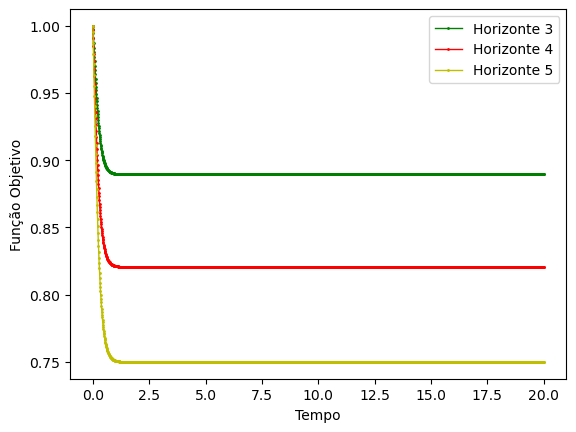

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0])/abs(valoresFuncaoObjetivo4[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0])/abs(valoresFuncaoObjetivo5[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo1.png', format='png')
plt.show()

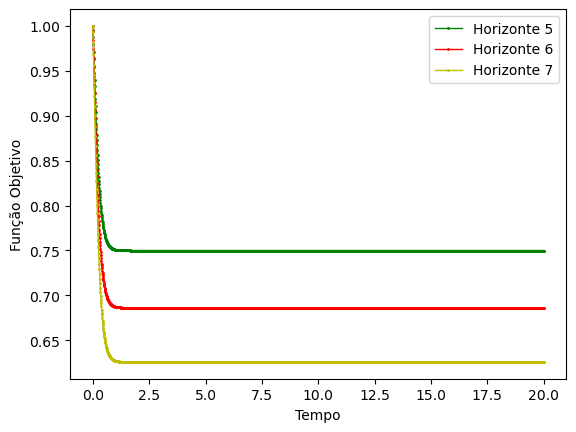

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0])/abs(valoresFuncaoObjetivo5[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0])/abs(valoresFuncaoObjetivo6[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0])/abs(valoresFuncaoObjetivo7[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo2.png', format='png')
plt.show()

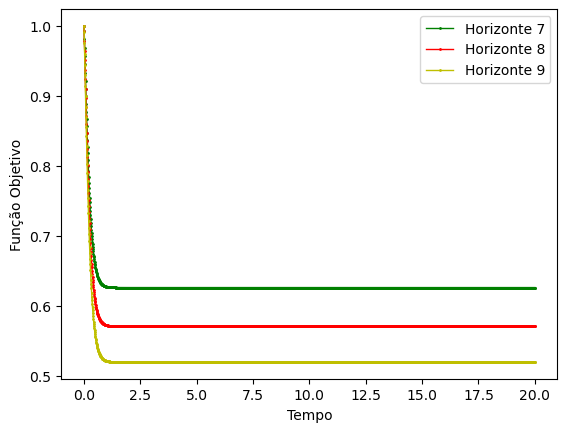

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0])/abs(valoresFuncaoObjetivo7[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0])/abs(valoresFuncaoObjetivo8[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0])/abs(valoresFuncaoObjetivo9[0][0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo3.png', format='png')
plt.show()

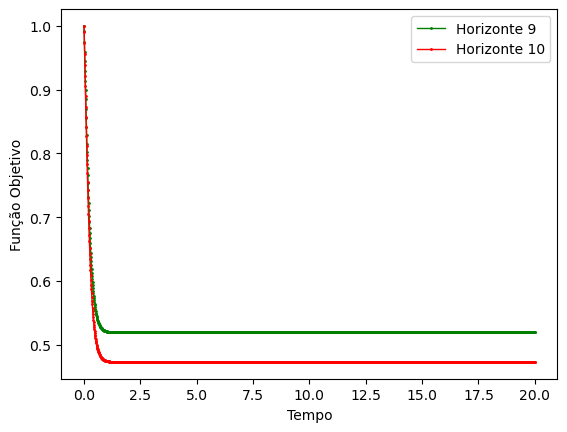

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0])/abs(valoresFuncaoObjetivo9[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0])/abs(valoresFuncaoObjetivo10[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo4.png', format='png')
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem do ajuste.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

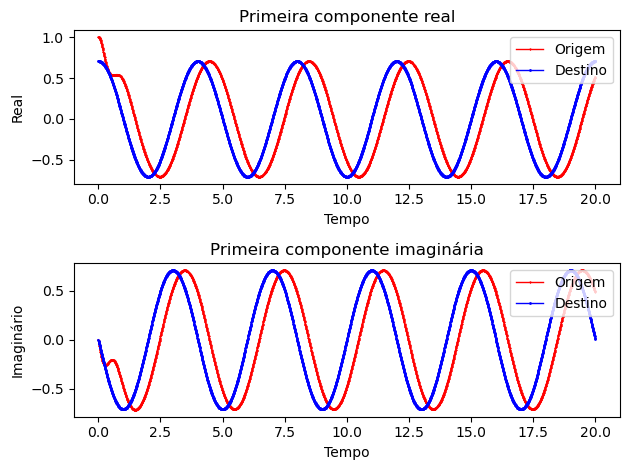

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

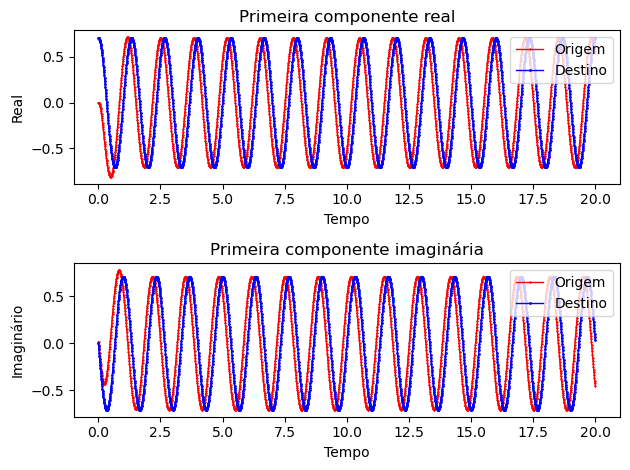

In [16]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

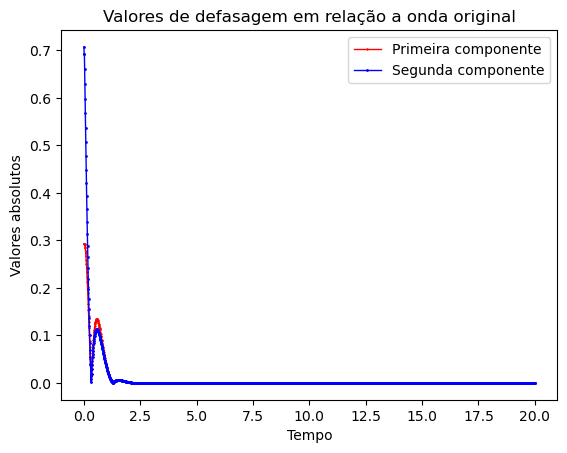

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

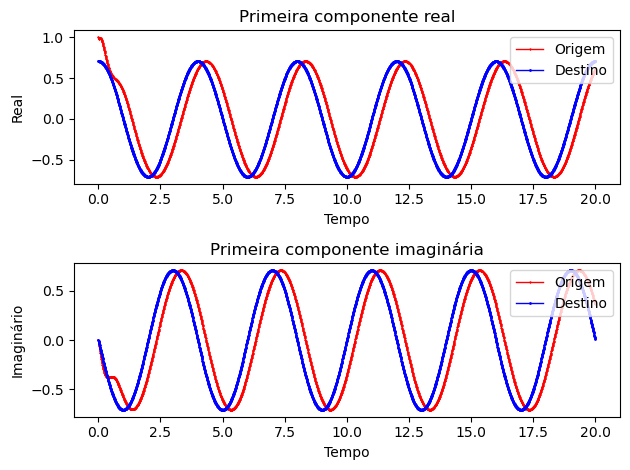

In [18]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

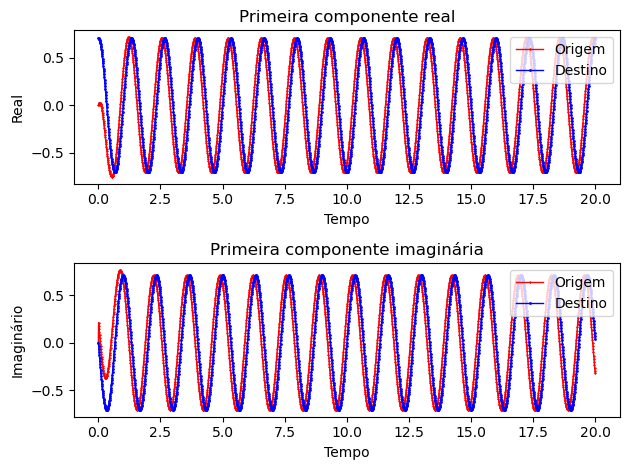

In [19]:
# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

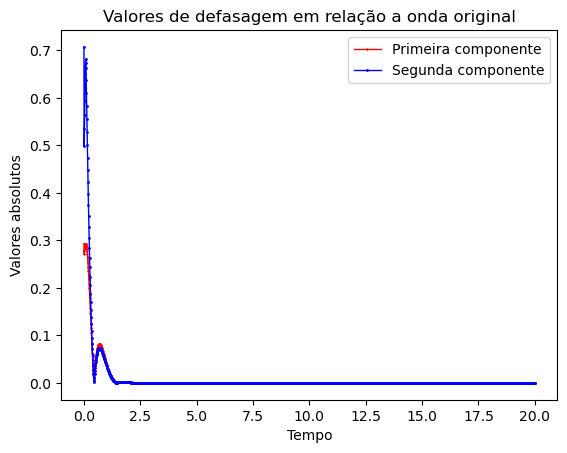

In [20]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [21]:
print(f"A defasagem para o horizonte 3, na sua primeira componente é:{abs(defasagem3[0][1999])}")
print(f"A defasagem para o horizonte 3, na sua segunda componente é:{abs(defasagem3[1][1999])}")
print(f"A defasagem para o horizonte 10, na sua primeira componente é:{abs(defasagem10[0][1999])}")
print(f"A defasagem para o horizonte 10, na sua segunda componente é:{abs(defasagem10[1][1999])}")

A defasagem para o horizonte 3, na sua primeira componente é:1.3367142344566929e-05
A defasagem para o horizonte 3, na sua segunda componente é:1.3479202473076768e-05
A defasagem para o horizonte 10, na sua primeira componente é:8.053180733247345e-05
A defasagem para o horizonte 10, na sua segunda componente é:7.932260794807355e-05


### Avaliação das constantes



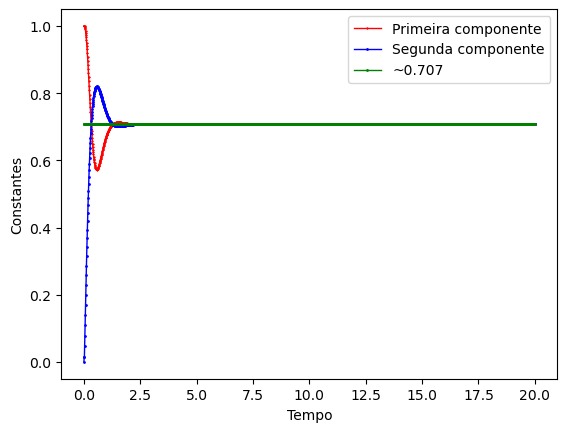

In [22]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

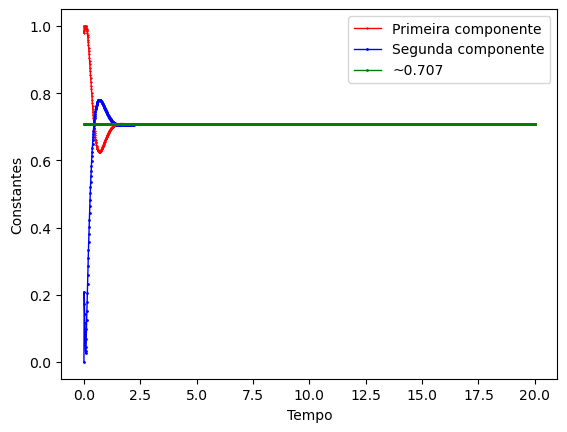

In [23]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

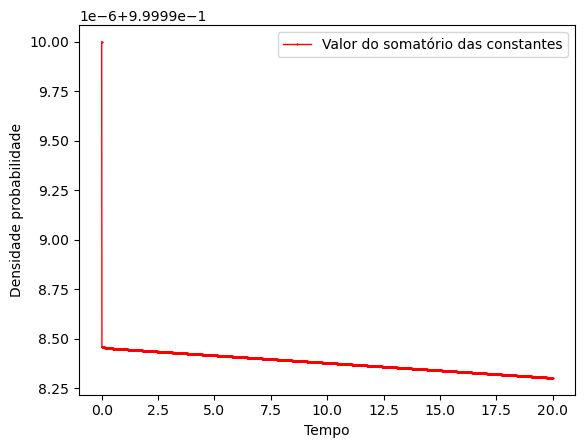

In [24]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()